In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 hu88k90i


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                    | 1/2934 [00:01<1:01:32,  1.26s/it]

  0%|                                                                                                                      | 2/2934 [00:01<30:15,  1.62it/s]

  0%|                                                                                                                      | 3/2934 [00:01<20:14,  2.41it/s]

  0%|▏                                                                                                                     | 4/2934 [00:01<15:31,  3.15it/s]

  0%|▏                                                                                                                     | 5/2934 [00:01<12:54,  3.78it/s]

  0%|▏                                                                                                                     | 6/2934 [00:02<11:20,  4.30it/s]

  0%|▎                                                                                                                     | 7/2934 [00:02<10:19,  4.72it/s]

  0%|▎                                                                                                                     | 8/2934 [00:02<09:40,  5.04it/s]

  0%|▎                                                                                                                     | 9/2934 [00:02<09:14,  5.28it/s]

  0%|▍                                                                                                                    | 10/2934 [00:02<08:56,  5.45it/s]

  0%|▍                                                                                                                    | 11/2934 [00:02<08:43,  5.58it/s]

  0%|▍                                                                                                                    | 12/2934 [00:03<08:35,  5.66it/s]

  0%|▌                                                                                                                    | 13/2934 [00:03<08:29,  5.73it/s]

  0%|▌                                                                                                                    | 14/2934 [00:03<08:25,  5.78it/s]

  1%|▌                                                                                                                    | 15/2934 [00:03<08:22,  5.81it/s]

  1%|▋                                                                                                                    | 16/2934 [00:03<08:19,  5.84it/s]

  1%|▋                                                                                                                    | 17/2934 [00:03<08:18,  5.85it/s]

  1%|▋                                                                                                                    | 18/2934 [00:04<08:17,  5.86it/s]

  1%|▊                                                                                                                    | 19/2934 [00:04<08:16,  5.88it/s]

  1%|▊                                                                                                                    | 20/2934 [00:04<08:15,  5.88it/s]

  1%|▊                                                                                                                    | 21/2934 [00:04<08:14,  5.89it/s]

  1%|▉                                                                                                                    | 22/2934 [00:04<08:14,  5.89it/s]

  1%|▉                                                                                                                    | 23/2934 [00:04<08:14,  5.89it/s]

  1%|▉                                                                                                                    | 24/2934 [00:05<08:13,  5.89it/s]

  1%|▉                                                                                                                    | 25/2934 [00:05<08:13,  5.89it/s]

  1%|█                                                                                                                    | 26/2934 [00:05<08:13,  5.89it/s]

  1%|█                                                                                                                    | 27/2934 [00:05<08:13,  5.89it/s]

  1%|█                                                                                                                    | 28/2934 [00:05<08:13,  5.89it/s]

  1%|█▏                                                                                                                   | 29/2934 [00:06<08:13,  5.89it/s]

  1%|█▏                                                                                                                   | 30/2934 [00:06<08:13,  5.89it/s]

  1%|█▏                                                                                                                   | 31/2934 [00:06<08:12,  5.89it/s]

  1%|█▎                                                                                                                   | 32/2934 [00:06<08:12,  5.89it/s]

  1%|█▎                                                                                                                   | 33/2934 [00:06<08:12,  5.90it/s]

  1%|█▎                                                                                                                   | 34/2934 [00:06<08:11,  5.90it/s]

  1%|█▍                                                                                                                   | 35/2934 [00:07<08:11,  5.90it/s]

  1%|█▍                                                                                                                   | 36/2934 [00:07<08:11,  5.89it/s]

  1%|█▍                                                                                                                   | 37/2934 [00:07<08:11,  5.89it/s]

  1%|█▌                                                                                                                   | 38/2934 [00:07<08:11,  5.89it/s]

  1%|█▌                                                                                                                   | 39/2934 [00:07<08:11,  5.89it/s]

  1%|█▌                                                                                                                   | 40/2934 [00:07<08:11,  5.89it/s]

  1%|█▋                                                                                                                   | 41/2934 [00:08<08:11,  5.89it/s]

  1%|█▋                                                                                                                   | 42/2934 [00:08<08:11,  5.89it/s]

  1%|█▋                                                                                                                   | 43/2934 [00:08<08:11,  5.89it/s]

  1%|█▊                                                                                                                   | 44/2934 [00:08<08:10,  5.89it/s]

  2%|█▊                                                                                                                   | 45/2934 [00:08<08:10,  5.89it/s]

  2%|█▊                                                                                                                   | 46/2934 [00:08<08:10,  5.88it/s]

  2%|█▊                                                                                                                   | 47/2934 [00:09<08:10,  5.88it/s]

  2%|█▉                                                                                                                   | 48/2934 [00:09<08:10,  5.88it/s]

  2%|█▉                                                                                                                   | 49/2934 [00:09<08:10,  5.89it/s]

  2%|█▉                                                                                                                   | 50/2934 [00:09<08:09,  5.89it/s]

  2%|██                                                                                                                   | 51/2934 [00:09<08:09,  5.89it/s]

  2%|██                                                                                                                   | 52/2934 [00:09<08:09,  5.89it/s]

  2%|██                                                                                                                   | 53/2934 [00:10<08:09,  5.88it/s]

  2%|██▏                                                                                                                  | 54/2934 [00:10<08:09,  5.88it/s]

  2%|██▏                                                                                                                  | 55/2934 [00:10<08:09,  5.89it/s]

  2%|██▏                                                                                                                  | 56/2934 [00:10<08:08,  5.89it/s]

  2%|██▎                                                                                                                  | 57/2934 [00:10<08:08,  5.89it/s]

  2%|██▎                                                                                                                  | 58/2934 [00:10<08:08,  5.89it/s]

  2%|██▎                                                                                                                  | 59/2934 [00:11<08:08,  5.89it/s]

  2%|██▍                                                                                                                  | 60/2934 [00:11<08:08,  5.88it/s]

  2%|██▍                                                                                                                  | 61/2934 [00:11<08:08,  5.88it/s]

  2%|██▍                                                                                                                  | 62/2934 [00:11<08:08,  5.88it/s]

  2%|██▌                                                                                                                  | 63/2934 [00:11<08:07,  5.89it/s]

  2%|██▌                                                                                                                  | 64/2934 [00:11<08:07,  5.89it/s]

  2%|██▌                                                                                                                  | 65/2934 [00:12<08:07,  5.89it/s]

  2%|██▋                                                                                                                  | 66/2934 [00:12<08:07,  5.89it/s]

  2%|██▋                                                                                                                  | 67/2934 [00:12<08:07,  5.88it/s]

  2%|██▋                                                                                                                  | 68/2934 [00:12<08:06,  5.89it/s]

  2%|██▊                                                                                                                  | 69/2934 [00:12<08:06,  5.89it/s]

  2%|██▊                                                                                                                  | 70/2934 [00:12<08:06,  5.89it/s]

  2%|██▊                                                                                                                  | 71/2934 [00:13<08:06,  5.89it/s]

  2%|██▊                                                                                                                  | 72/2934 [00:13<08:06,  5.89it/s]

  2%|██▉                                                                                                                  | 73/2934 [00:13<08:05,  5.89it/s]

  3%|██▉                                                                                                                  | 74/2934 [00:13<08:06,  5.88it/s]

  3%|██▉                                                                                                                  | 75/2934 [00:13<08:05,  5.88it/s]

  3%|███                                                                                                                  | 76/2934 [00:13<08:05,  5.89it/s]

  3%|███                                                                                                                  | 77/2934 [00:14<08:05,  5.89it/s]

  3%|███                                                                                                                  | 78/2934 [00:14<08:05,  5.89it/s]

  3%|███▏                                                                                                                 | 79/2934 [00:14<08:04,  5.89it/s]

  3%|███▏                                                                                                                 | 80/2934 [00:14<08:04,  5.89it/s]

  3%|███▏                                                                                                                 | 81/2934 [00:14<08:05,  5.88it/s]

  3%|███▎                                                                                                                 | 82/2934 [00:15<08:04,  5.88it/s]

  3%|███▎                                                                                                                 | 83/2934 [00:15<08:04,  5.89it/s]

  3%|███▎                                                                                                                 | 84/2934 [00:15<08:04,  5.89it/s]

  3%|███▍                                                                                                                 | 85/2934 [00:15<08:03,  5.89it/s]

  3%|███▍                                                                                                                 | 86/2934 [00:15<08:03,  5.89it/s]

  3%|███▍                                                                                                                 | 87/2934 [00:15<08:03,  5.89it/s]

  3%|███▌                                                                                                                 | 88/2934 [00:16<08:04,  5.88it/s]

  3%|███▌                                                                                                                 | 89/2934 [00:16<08:03,  5.88it/s]

  3%|███▌                                                                                                                 | 90/2934 [00:16<08:03,  5.88it/s]

  3%|███▋                                                                                                                 | 91/2934 [00:16<08:03,  5.88it/s]

  3%|███▋                                                                                                                 | 92/2934 [00:16<08:02,  5.88it/s]

  3%|███▋                                                                                                                 | 93/2934 [00:16<08:02,  5.88it/s]

  3%|███▋                                                                                                                 | 94/2934 [00:17<08:02,  5.88it/s]

  3%|███▊                                                                                                                 | 95/2934 [00:17<08:02,  5.88it/s]

  3%|███▊                                                                                                                 | 96/2934 [00:17<08:02,  5.88it/s]

  3%|███▊                                                                                                                 | 97/2934 [00:17<08:02,  5.88it/s]

  3%|███▉                                                                                                                 | 98/2934 [00:17<08:01,  5.89it/s]

  3%|███▉                                                                                                                 | 99/2934 [00:17<08:01,  5.89it/s]

  3%|███▉                                                                                                                | 100/2934 [00:18<08:00,  5.89it/s]

  3%|███▉                                                                                                                | 101/2934 [00:18<08:00,  5.90it/s]

  3%|████                                                                                                                | 102/2934 [00:18<08:00,  5.89it/s]

  4%|████                                                                                                                | 103/2934 [00:18<08:00,  5.89it/s]

  4%|████                                                                                                                | 104/2934 [00:18<07:59,  5.90it/s]

  4%|████▏                                                                                                               | 105/2934 [00:18<07:59,  5.90it/s]

  4%|████▏                                                                                                               | 106/2934 [00:19<07:59,  5.90it/s]

  4%|████▏                                                                                                               | 107/2934 [00:19<07:59,  5.90it/s]

  4%|████▎                                                                                                               | 108/2934 [00:19<07:59,  5.90it/s]

  4%|████▎                                                                                                               | 109/2934 [00:19<07:59,  5.89it/s]

  4%|████▎                                                                                                               | 110/2934 [00:19<07:59,  5.89it/s]

  4%|████▍                                                                                                               | 111/2934 [00:19<07:58,  5.90it/s]

  4%|████▍                                                                                                               | 112/2934 [00:20<07:58,  5.90it/s]

  4%|████▍                                                                                                               | 113/2934 [00:20<07:58,  5.90it/s]

  4%|████▌                                                                                                               | 114/2934 [00:20<07:58,  5.90it/s]

  4%|████▌                                                                                                               | 115/2934 [00:20<07:57,  5.90it/s]

  4%|████▌                                                                                                               | 116/2934 [00:20<07:58,  5.89it/s]

  4%|████▋                                                                                                               | 117/2934 [00:20<07:57,  5.90it/s]

  4%|████▋                                                                                                               | 118/2934 [00:21<07:57,  5.90it/s]

  4%|████▋                                                                                                               | 119/2934 [00:21<07:57,  5.90it/s]

  4%|████▋                                                                                                               | 120/2934 [00:21<07:57,  5.90it/s]

  4%|████▊                                                                                                               | 121/2934 [00:21<07:56,  5.90it/s]

  4%|████▊                                                                                                               | 122/2934 [00:21<07:56,  5.90it/s]

  4%|████▊                                                                                                               | 123/2934 [00:21<07:57,  5.89it/s]

  4%|████▉                                                                                                               | 124/2934 [00:22<07:56,  5.90it/s]

  4%|████▉                                                                                                               | 125/2934 [00:22<07:56,  5.90it/s]

  4%|████▉                                                                                                               | 126/2934 [00:22<07:56,  5.90it/s]

  4%|█████                                                                                                               | 127/2934 [00:22<07:55,  5.90it/s]

  4%|█████                                                                                                               | 128/2934 [00:22<07:55,  5.90it/s]

  4%|█████                                                                                                               | 129/2934 [00:22<07:55,  5.90it/s]

  4%|█████▏                                                                                                              | 130/2934 [00:23<07:55,  5.89it/s]

  4%|█████▏                                                                                                              | 131/2934 [00:23<07:55,  5.90it/s]

  4%|█████▏                                                                                                              | 132/2934 [00:23<07:55,  5.90it/s]

  5%|█████▎                                                                                                              | 133/2934 [00:23<07:54,  5.90it/s]

  5%|█████▎                                                                                                              | 134/2934 [00:23<07:54,  5.90it/s]

  5%|█████▎                                                                                                              | 135/2934 [00:24<07:54,  5.90it/s]

  5%|█████▍                                                                                                              | 136/2934 [00:24<07:54,  5.90it/s]

  5%|█████▍                                                                                                              | 137/2934 [00:24<07:54,  5.89it/s]

  5%|█████▍                                                                                                              | 138/2934 [00:24<07:54,  5.89it/s]

  5%|█████▍                                                                                                              | 139/2934 [00:24<07:53,  5.90it/s]

  5%|█████▌                                                                                                              | 140/2934 [00:24<07:53,  5.90it/s]

  5%|█████▌                                                                                                              | 141/2934 [00:25<07:53,  5.90it/s]

  5%|█████▌                                                                                                              | 142/2934 [00:25<07:53,  5.90it/s]

  5%|█████▋                                                                                                              | 143/2934 [00:25<07:52,  5.90it/s]

  5%|█████▋                                                                                                              | 144/2934 [00:25<07:53,  5.89it/s]

  5%|█████▋                                                                                                              | 145/2934 [00:25<07:53,  5.90it/s]

  5%|█████▊                                                                                                              | 146/2934 [00:25<07:52,  5.90it/s]

  5%|█████▊                                                                                                              | 147/2934 [00:26<07:52,  5.90it/s]

  5%|█████▊                                                                                                              | 148/2934 [00:26<07:52,  5.90it/s]

  5%|█████▉                                                                                                              | 149/2934 [00:26<07:51,  5.90it/s]

  5%|█████▉                                                                                                              | 150/2934 [00:26<07:51,  5.90it/s]

  5%|█████▉                                                                                                              | 151/2934 [00:26<07:52,  5.89it/s]

  5%|██████                                                                                                              | 152/2934 [00:26<07:51,  5.89it/s]

  5%|██████                                                                                                              | 153/2934 [00:27<07:51,  5.90it/s]

  5%|██████                                                                                                              | 154/2934 [00:27<07:51,  5.90it/s]

  5%|██████▏                                                                                                             | 155/2934 [00:27<07:51,  5.90it/s]

  5%|██████▏                                                                                                             | 156/2934 [00:27<07:50,  5.90it/s]

  5%|██████▏                                                                                                             | 157/2934 [00:27<07:50,  5.90it/s]

  5%|██████▏                                                                                                             | 158/2934 [00:27<07:51,  5.89it/s]

  5%|██████▎                                                                                                             | 159/2934 [00:28<07:50,  5.90it/s]

  5%|██████▎                                                                                                             | 160/2934 [00:28<07:50,  5.90it/s]

  5%|██████▎                                                                                                             | 161/2934 [00:28<07:50,  5.90it/s]

  6%|██████▍                                                                                                             | 162/2934 [00:28<07:49,  5.90it/s]

  6%|██████▍                                                                                                             | 163/2934 [00:28<07:49,  5.90it/s]

  6%|██████▍                                                                                                             | 164/2934 [00:28<07:49,  5.90it/s]

  6%|██████▌                                                                                                             | 165/2934 [00:29<07:49,  5.90it/s]

  6%|██████▌                                                                                                             | 166/2934 [00:29<07:48,  5.91it/s]

  6%|██████▌                                                                                                             | 167/2934 [00:29<07:47,  5.92it/s]

  6%|██████▋                                                                                                             | 168/2934 [00:29<07:46,  5.93it/s]

  6%|██████▋                                                                                                             | 169/2934 [00:29<07:45,  5.94it/s]

  6%|██████▋                                                                                                             | 170/2934 [00:29<07:45,  5.94it/s]

  6%|██████▊                                                                                                             | 171/2934 [00:30<07:45,  5.94it/s]

  6%|██████▊                                                                                                             | 172/2934 [00:30<07:45,  5.93it/s]

  6%|██████▊                                                                                                             | 173/2934 [00:30<07:46,  5.92it/s]

  6%|██████▉                                                                                                             | 174/2934 [00:30<07:46,  5.92it/s]

  6%|██████▉                                                                                                             | 175/2934 [00:30<07:46,  5.91it/s]

  6%|██████▉                                                                                                             | 176/2934 [00:30<07:46,  5.91it/s]

  6%|██████▉                                                                                                             | 177/2934 [00:31<07:46,  5.91it/s]

  6%|███████                                                                                                             | 178/2934 [00:31<07:46,  5.91it/s]

  6%|███████                                                                                                             | 179/2934 [00:31<07:47,  5.90it/s]

  6%|███████                                                                                                             | 180/2934 [00:31<07:46,  5.90it/s]

  6%|███████▏                                                                                                            | 181/2934 [00:31<07:46,  5.90it/s]

  6%|███████▏                                                                                                            | 182/2934 [00:31<07:46,  5.90it/s]

  6%|███████▏                                                                                                            | 183/2934 [00:32<07:46,  5.90it/s]

  6%|███████▎                                                                                                            | 184/2934 [00:32<07:46,  5.90it/s]

  6%|███████▎                                                                                                            | 185/2934 [00:32<07:45,  5.90it/s]

  6%|███████▎                                                                                                            | 186/2934 [00:32<07:46,  5.90it/s]

  6%|███████▍                                                                                                            | 187/2934 [00:32<07:45,  5.90it/s]

  6%|███████▍                                                                                                            | 188/2934 [00:32<07:45,  5.90it/s]

  6%|███████▍                                                                                                            | 189/2934 [00:33<07:44,  5.91it/s]

  6%|███████▌                                                                                                            | 190/2934 [00:33<07:44,  5.91it/s]

  7%|███████▌                                                                                                            | 191/2934 [00:33<07:44,  5.91it/s]

  7%|███████▌                                                                                                            | 192/2934 [00:33<07:43,  5.91it/s]

  7%|███████▋                                                                                                            | 193/2934 [00:33<07:44,  5.90it/s]

  7%|███████▋                                                                                                            | 194/2934 [00:34<07:44,  5.90it/s]

  7%|███████▋                                                                                                            | 195/2934 [00:34<07:43,  5.91it/s]

  7%|███████▋                                                                                                            | 196/2934 [00:34<07:43,  5.91it/s]

  7%|███████▊                                                                                                            | 197/2934 [00:34<07:43,  5.91it/s]

  7%|███████▊                                                                                                            | 198/2934 [00:34<07:43,  5.91it/s]

  7%|███████▊                                                                                                            | 199/2934 [00:34<07:42,  5.91it/s]

  7%|███████▉                                                                                                            | 200/2934 [00:35<07:43,  5.90it/s]

  7%|███████▉                                                                                                            | 201/2934 [00:35<07:42,  5.91it/s]

  7%|███████▉                                                                                                            | 202/2934 [00:35<07:42,  5.91it/s]

  7%|████████                                                                                                            | 203/2934 [00:35<07:42,  5.91it/s]

  7%|████████                                                                                                            | 204/2934 [00:35<07:41,  5.91it/s]

  7%|████████                                                                                                            | 205/2934 [00:35<07:41,  5.91it/s]

  7%|████████▏                                                                                                           | 206/2934 [00:36<07:41,  5.91it/s]

  7%|████████▏                                                                                                           | 207/2934 [00:36<07:41,  5.90it/s]

  7%|████████▏                                                                                                           | 208/2934 [00:36<07:41,  5.90it/s]

  7%|████████▎                                                                                                           | 209/2934 [00:36<07:41,  5.91it/s]

  7%|████████▎                                                                                                           | 210/2934 [00:36<07:40,  5.91it/s]

  7%|████████▎                                                                                                           | 211/2934 [00:36<07:40,  5.91it/s]

  7%|████████▍                                                                                                           | 212/2934 [00:37<07:40,  5.91it/s]

  7%|████████▍                                                                                                           | 213/2934 [00:37<07:40,  5.91it/s]

  7%|████████▍                                                                                                           | 214/2934 [00:37<07:40,  5.90it/s]

  7%|████████▌                                                                                                           | 215/2934 [00:37<07:40,  5.91it/s]

  7%|████████▌                                                                                                           | 216/2934 [00:37<07:40,  5.91it/s]

  7%|████████▌                                                                                                           | 217/2934 [00:37<07:39,  5.91it/s]

  7%|████████▌                                                                                                           | 218/2934 [00:38<07:39,  5.91it/s]

  7%|████████▋                                                                                                           | 219/2934 [00:38<07:39,  5.91it/s]

  7%|████████▋                                                                                                           | 220/2934 [00:38<07:39,  5.91it/s]

  8%|████████▋                                                                                                           | 221/2934 [00:38<07:39,  5.91it/s]

  8%|████████▊                                                                                                           | 222/2934 [00:38<07:37,  5.92it/s]

  8%|████████▊                                                                                                           | 223/2934 [00:38<07:36,  5.93it/s]

  8%|████████▊                                                                                                           | 224/2934 [00:39<07:36,  5.94it/s]

  8%|████████▉                                                                                                           | 225/2934 [00:39<07:35,  5.95it/s]

  8%|████████▉                                                                                                           | 226/2934 [00:39<07:35,  5.95it/s]

  8%|████████▉                                                                                                           | 227/2934 [00:39<07:34,  5.95it/s]

  8%|█████████                                                                                                           | 228/2934 [00:39<07:35,  5.94it/s]

  8%|█████████                                                                                                           | 229/2934 [00:39<07:35,  5.93it/s]

  8%|█████████                                                                                                           | 230/2934 [00:40<07:36,  5.93it/s]

  8%|█████████▏                                                                                                          | 231/2934 [00:40<07:36,  5.92it/s]

  8%|█████████▏                                                                                                          | 232/2934 [00:40<07:36,  5.92it/s]

  8%|█████████▏                                                                                                          | 233/2934 [00:40<07:36,  5.92it/s]

  8%|█████████▎                                                                                                          | 234/2934 [00:40<07:36,  5.92it/s]

  8%|█████████▎                                                                                                          | 235/2934 [00:40<07:36,  5.91it/s]

  8%|█████████▎                                                                                                          | 236/2934 [00:41<07:36,  5.91it/s]

  8%|█████████▎                                                                                                          | 237/2934 [00:41<07:36,  5.91it/s]

  8%|█████████▍                                                                                                          | 238/2934 [00:41<07:36,  5.91it/s]

  8%|█████████▍                                                                                                          | 239/2934 [00:41<07:35,  5.91it/s]

  8%|█████████▍                                                                                                          | 240/2934 [00:41<07:35,  5.91it/s]

  8%|█████████▌                                                                                                          | 241/2934 [00:41<07:35,  5.91it/s]

  8%|█████████▌                                                                                                          | 242/2934 [00:42<07:36,  5.90it/s]

  8%|█████████▌                                                                                                          | 243/2934 [00:42<07:35,  5.91it/s]

  8%|█████████▋                                                                                                          | 244/2934 [00:42<07:35,  5.91it/s]

  8%|█████████▋                                                                                                          | 245/2934 [00:42<07:35,  5.91it/s]

  8%|█████████▋                                                                                                          | 246/2934 [00:42<07:34,  5.91it/s]

  8%|█████████▊                                                                                                          | 247/2934 [00:42<07:34,  5.91it/s]

  8%|█████████▊                                                                                                          | 248/2934 [00:43<07:34,  5.91it/s]

  8%|█████████▊                                                                                                          | 249/2934 [00:43<07:35,  5.90it/s]

  9%|█████████▉                                                                                                          | 250/2934 [00:43<07:34,  5.90it/s]

  9%|█████████▉                                                                                                          | 251/2934 [00:43<07:34,  5.90it/s]

  9%|█████████▉                                                                                                          | 252/2934 [00:43<07:34,  5.90it/s]

  9%|██████████                                                                                                          | 253/2934 [00:43<07:33,  5.91it/s]

  9%|██████████                                                                                                          | 254/2934 [00:44<07:33,  5.91it/s]

  9%|██████████                                                                                                          | 255/2934 [00:44<07:33,  5.91it/s]

  9%|██████████                                                                                                          | 256/2934 [00:44<07:33,  5.91it/s]

  9%|██████████▏                                                                                                         | 257/2934 [00:44<07:32,  5.91it/s]

  9%|██████████▏                                                                                                         | 258/2934 [00:44<07:33,  5.90it/s]

  9%|██████████▏                                                                                                         | 259/2934 [00:44<07:32,  5.91it/s]

  9%|██████████▎                                                                                                         | 260/2934 [00:45<07:32,  5.91it/s]

  9%|██████████▎                                                                                                         | 261/2934 [00:45<07:32,  5.91it/s]

  9%|██████████▎                                                                                                         | 262/2934 [00:45<07:32,  5.91it/s]

  9%|██████████▍                                                                                                         | 263/2934 [00:45<07:31,  5.91it/s]

  9%|██████████▍                                                                                                         | 264/2934 [00:45<07:31,  5.91it/s]

  9%|██████████▍                                                                                                         | 265/2934 [00:46<07:32,  5.90it/s]

  9%|██████████▌                                                                                                         | 266/2934 [00:46<07:31,  5.91it/s]

  9%|██████████▌                                                                                                         | 267/2934 [00:46<07:31,  5.91it/s]

  9%|██████████▌                                                                                                         | 268/2934 [00:46<07:31,  5.91it/s]

  9%|██████████▋                                                                                                         | 269/2934 [00:46<07:31,  5.91it/s]

  9%|██████████▋                                                                                                         | 270/2934 [00:46<07:30,  5.91it/s]

  9%|██████████▋                                                                                                         | 271/2934 [00:47<07:30,  5.91it/s]

  9%|██████████▊                                                                                                         | 272/2934 [00:47<07:30,  5.91it/s]

  9%|██████████▊                                                                                                         | 273/2934 [00:47<07:29,  5.92it/s]

  9%|██████████▊                                                                                                         | 274/2934 [00:47<07:28,  5.93it/s]

  9%|██████████▊                                                                                                         | 275/2934 [00:47<07:27,  5.94it/s]

  9%|██████████▉                                                                                                         | 276/2934 [00:47<07:27,  5.94it/s]

  9%|██████████▉                                                                                                         | 277/2934 [00:48<07:26,  5.95it/s]

  9%|██████████▉                                                                                                         | 278/2934 [00:48<07:26,  5.95it/s]

 10%|███████████                                                                                                         | 279/2934 [00:48<07:26,  5.94it/s]

 10%|███████████                                                                                                         | 280/2934 [00:48<07:27,  5.93it/s]

 10%|███████████                                                                                                         | 281/2934 [00:48<07:27,  5.92it/s]

 10%|███████████▏                                                                                                        | 282/2934 [00:48<07:27,  5.92it/s]

 10%|███████████▏                                                                                                        | 283/2934 [00:49<07:27,  5.92it/s]

 10%|███████████▏                                                                                                        | 284/2934 [00:49<07:27,  5.92it/s]

 10%|███████████▎                                                                                                        | 285/2934 [00:49<07:28,  5.91it/s]

 10%|███████████▎                                                                                                        | 286/2934 [00:49<07:28,  5.91it/s]

 10%|███████████▎                                                                                                        | 287/2934 [00:49<07:27,  5.91it/s]

 10%|███████████▍                                                                                                        | 288/2934 [00:49<07:27,  5.91it/s]

 10%|███████████▍                                                                                                        | 289/2934 [00:50<07:27,  5.91it/s]

 10%|███████████▍                                                                                                        | 290/2934 [00:50<07:27,  5.90it/s]

 10%|███████████▌                                                                                                        | 291/2934 [00:50<07:28,  5.89it/s]

 10%|███████████▌                                                                                                        | 292/2934 [00:50<07:29,  5.88it/s]

 10%|███████████▌                                                                                                        | 293/2934 [00:50<07:29,  5.88it/s]

 10%|███████████▌                                                                                                        | 294/2934 [00:50<07:29,  5.88it/s]

 10%|███████████▋                                                                                                        | 295/2934 [00:51<07:29,  5.87it/s]

 10%|███████████▋                                                                                                        | 296/2934 [00:51<07:29,  5.87it/s]

 10%|███████████▋                                                                                                        | 297/2934 [00:51<07:28,  5.87it/s]

 10%|███████████▊                                                                                                        | 298/2934 [00:51<07:28,  5.87it/s]

 10%|███████████▊                                                                                                        | 299/2934 [00:51<07:29,  5.87it/s]

 10%|███████████▊                                                                                                        | 300/2934 [00:51<07:28,  5.87it/s]

 10%|███████████▉                                                                                                        | 301/2934 [00:52<07:28,  5.87it/s]

 10%|███████████▉                                                                                                        | 302/2934 [00:52<07:28,  5.87it/s]

 10%|███████████▉                                                                                                        | 303/2934 [00:52<07:28,  5.87it/s]

 10%|████████████                                                                                                        | 304/2934 [00:52<07:27,  5.87it/s]

 10%|████████████                                                                                                        | 305/2934 [00:52<07:27,  5.87it/s]

 10%|████████████                                                                                                        | 306/2934 [00:52<07:28,  5.87it/s]

 10%|████████████▏                                                                                                       | 307/2934 [00:53<07:27,  5.87it/s]

 10%|████████████▏                                                                                                       | 308/2934 [00:53<07:27,  5.87it/s]

 11%|████████████▏                                                                                                       | 309/2934 [00:53<07:27,  5.87it/s]

 11%|████████████▎                                                                                                       | 310/2934 [00:53<07:26,  5.87it/s]

 11%|████████████▎                                                                                                       | 311/2934 [00:53<07:26,  5.87it/s]

 11%|████████████▎                                                                                                       | 312/2934 [00:53<07:26,  5.87it/s]

 11%|████████████▎                                                                                                       | 313/2934 [00:54<07:26,  5.87it/s]

 11%|████████████▍                                                                                                       | 314/2934 [00:54<07:26,  5.87it/s]

 11%|████████████▍                                                                                                       | 315/2934 [00:54<07:26,  5.87it/s]

 11%|████████████▍                                                                                                       | 316/2934 [00:54<07:26,  5.87it/s]

 11%|████████████▌                                                                                                       | 317/2934 [00:54<07:26,  5.87it/s]

 11%|████████████▌                                                                                                       | 318/2934 [00:55<07:25,  5.87it/s]

 11%|████████████▌                                                                                                       | 319/2934 [00:55<07:25,  5.87it/s]

 11%|████████████▋                                                                                                       | 320/2934 [00:55<07:25,  5.87it/s]

 11%|████████████▋                                                                                                       | 321/2934 [00:55<07:24,  5.87it/s]

 11%|████████████▋                                                                                                       | 322/2934 [00:55<07:24,  5.87it/s]

 11%|████████████▊                                                                                                       | 323/2934 [00:55<07:24,  5.87it/s]

 11%|████████████▊                                                                                                       | 324/2934 [00:56<07:24,  5.87it/s]

 11%|████████████▊                                                                                                       | 325/2934 [00:56<07:24,  5.87it/s]

 11%|████████████▉                                                                                                       | 326/2934 [00:56<07:24,  5.87it/s]

 11%|████████████▉                                                                                                       | 327/2934 [00:56<07:23,  5.87it/s]

 11%|████████████▉                                                                                                       | 328/2934 [00:56<07:23,  5.88it/s]

 11%|█████████████                                                                                                       | 329/2934 [00:56<07:23,  5.87it/s]

 11%|█████████████                                                                                                       | 330/2934 [00:57<07:23,  5.87it/s]

 11%|█████████████                                                                                                       | 331/2934 [00:57<07:23,  5.87it/s]

 11%|█████████████▏                                                                                                      | 332/2934 [00:57<07:23,  5.87it/s]

 11%|█████████████▏                                                                                                      | 333/2934 [00:57<07:22,  5.87it/s]

 11%|█████████████▏                                                                                                      | 334/2934 [00:57<07:22,  5.87it/s]

 11%|█████████████▏                                                                                                      | 335/2934 [00:57<07:22,  5.87it/s]

 11%|█████████████▎                                                                                                      | 336/2934 [00:58<07:22,  5.87it/s]

 11%|█████████████▎                                                                                                      | 337/2934 [00:58<07:22,  5.87it/s]

 12%|█████████████▎                                                                                                      | 338/2934 [00:58<07:22,  5.87it/s]

 12%|█████████████▍                                                                                                      | 339/2934 [00:58<07:22,  5.87it/s]

 12%|█████████████▍                                                                                                      | 340/2934 [00:58<07:22,  5.87it/s]

 12%|█████████████▍                                                                                                      | 341/2934 [00:58<07:21,  5.87it/s]

 12%|█████████████▌                                                                                                      | 342/2934 [00:59<07:21,  5.87it/s]

 12%|█████████████▌                                                                                                      | 343/2934 [00:59<07:21,  5.87it/s]

 12%|█████████████▌                                                                                                      | 344/2934 [00:59<07:21,  5.87it/s]

 12%|█████████████▋                                                                                                      | 345/2934 [00:59<07:21,  5.87it/s]

 12%|█████████████▋                                                                                                      | 346/2934 [00:59<07:20,  5.87it/s]

 12%|█████████████▋                                                                                                      | 347/2934 [00:59<07:20,  5.87it/s]

 12%|█████████████▊                                                                                                      | 348/2934 [01:00<07:20,  5.87it/s]

 12%|█████████████▊                                                                                                      | 349/2934 [01:00<07:20,  5.87it/s]

 12%|█████████████▊                                                                                                      | 350/2934 [01:00<07:20,  5.87it/s]

 12%|█████████████▉                                                                                                      | 351/2934 [01:00<07:19,  5.87it/s]

 12%|█████████████▉                                                                                                      | 352/2934 [01:00<07:19,  5.87it/s]

 12%|█████████████▉                                                                                                      | 353/2934 [01:00<07:19,  5.87it/s]

 12%|█████████████▉                                                                                                      | 354/2934 [01:01<07:19,  5.87it/s]

 12%|██████████████                                                                                                      | 355/2934 [01:01<07:19,  5.87it/s]

 12%|██████████████                                                                                                      | 356/2934 [01:01<07:19,  5.87it/s]

 12%|██████████████                                                                                                      | 357/2934 [01:01<07:19,  5.87it/s]

 12%|██████████████▏                                                                                                     | 358/2934 [01:01<07:19,  5.87it/s]

 12%|██████████████▏                                                                                                     | 359/2934 [01:01<07:18,  5.87it/s]

 12%|██████████████▏                                                                                                     | 360/2934 [01:02<07:18,  5.87it/s]

 12%|██████████████▎                                                                                                     | 361/2934 [01:02<07:18,  5.87it/s]

 12%|██████████████▎                                                                                                     | 362/2934 [01:02<07:18,  5.87it/s]

 12%|██████████████▎                                                                                                     | 363/2934 [01:02<07:17,  5.87it/s]

 12%|██████████████▍                                                                                                     | 364/2934 [01:02<07:17,  5.87it/s]

 12%|██████████████▍                                                                                                     | 365/2934 [01:03<07:17,  5.87it/s]

 12%|██████████████▍                                                                                                     | 366/2934 [01:03<07:17,  5.87it/s]

 13%|██████████████▌                                                                                                     | 367/2934 [01:03<07:17,  5.87it/s]

 13%|██████████████▌                                                                                                     | 368/2934 [01:03<07:17,  5.87it/s]

 13%|██████████████▌                                                                                                     | 369/2934 [01:03<07:16,  5.87it/s]

 13%|██████████████▋                                                                                                     | 370/2934 [01:03<07:16,  5.87it/s]

 13%|██████████████▋                                                                                                     | 371/2934 [01:04<07:16,  5.87it/s]

 13%|██████████████▋                                                                                                     | 372/2934 [01:04<07:16,  5.87it/s]

 13%|██████████████▋                                                                                                     | 373/2934 [01:04<07:16,  5.87it/s]

 13%|██████████████▊                                                                                                     | 374/2934 [01:04<07:15,  5.87it/s]

 13%|██████████████▊                                                                                                     | 375/2934 [01:04<07:15,  5.87it/s]

 13%|██████████████▊                                                                                                     | 376/2934 [01:04<07:15,  5.87it/s]

 13%|██████████████▉                                                                                                     | 377/2934 [01:05<07:15,  5.87it/s]

 13%|██████████████▉                                                                                                     | 378/2934 [01:05<07:15,  5.87it/s]

 13%|██████████████▉                                                                                                     | 379/2934 [01:05<07:15,  5.87it/s]

 13%|███████████████                                                                                                     | 380/2934 [01:05<07:14,  5.87it/s]

 13%|███████████████                                                                                                     | 381/2934 [01:05<07:14,  5.87it/s]

 13%|███████████████                                                                                                     | 382/2934 [01:05<07:14,  5.87it/s]

 13%|███████████████▏                                                                                                    | 383/2934 [01:06<07:14,  5.87it/s]

 13%|███████████████▏                                                                                                    | 384/2934 [01:06<07:14,  5.87it/s]

 13%|███████████████▏                                                                                                    | 385/2934 [01:06<07:14,  5.87it/s]

 13%|███████████████▎                                                                                                    | 386/2934 [01:06<07:13,  5.87it/s]

 13%|███████████████▎                                                                                                    | 387/2934 [01:06<07:13,  5.87it/s]

 13%|███████████████▎                                                                                                    | 388/2934 [01:06<07:13,  5.87it/s]

 13%|███████████████▍                                                                                                    | 389/2934 [01:07<07:13,  5.87it/s]

 13%|███████████████▍                                                                                                    | 390/2934 [01:07<07:13,  5.87it/s]

 13%|███████████████▍                                                                                                    | 391/2934 [01:07<07:13,  5.87it/s]

 13%|███████████████▍                                                                                                    | 392/2934 [01:07<07:12,  5.87it/s]

 13%|███████████████▌                                                                                                    | 393/2934 [01:07<07:12,  5.87it/s]

 13%|███████████████▌                                                                                                    | 394/2934 [01:07<07:12,  5.87it/s]

 13%|███████████████▌                                                                                                    | 395/2934 [01:08<07:12,  5.87it/s]

 13%|███████████████▋                                                                                                    | 396/2934 [01:08<07:12,  5.87it/s]

 14%|███████████████▋                                                                                                    | 397/2934 [01:08<07:12,  5.87it/s]

 14%|███████████████▋                                                                                                    | 398/2934 [01:08<07:11,  5.87it/s]

 14%|███████████████▊                                                                                                    | 399/2934 [01:08<07:11,  5.87it/s]

 14%|███████████████▊                                                                                                    | 400/2934 [01:08<07:11,  5.87it/s]

 14%|███████████████▊                                                                                                    | 401/2934 [01:09<07:11,  5.87it/s]

 14%|███████████████▉                                                                                                    | 402/2934 [01:09<07:11,  5.87it/s]

 14%|███████████████▉                                                                                                    | 403/2934 [01:09<07:11,  5.87it/s]

 14%|███████████████▉                                                                                                    | 404/2934 [01:09<07:11,  5.87it/s]

 14%|████████████████                                                                                                    | 405/2934 [01:09<07:10,  5.87it/s]

 14%|████████████████                                                                                                    | 406/2934 [01:09<07:11,  5.86it/s]

 14%|████████████████                                                                                                    | 407/2934 [01:10<07:10,  5.86it/s]

 14%|████████████████▏                                                                                                   | 408/2934 [01:10<07:10,  5.87it/s]

 14%|████████████████▏                                                                                                   | 409/2934 [01:10<07:10,  5.87it/s]

 14%|████████████████▏                                                                                                   | 410/2934 [01:10<07:09,  5.87it/s]

 14%|████████████████▏                                                                                                   | 411/2934 [01:10<07:09,  5.87it/s]

 14%|████████████████▎                                                                                                   | 412/2934 [01:11<07:09,  5.88it/s]

 14%|████████████████▎                                                                                                   | 413/2934 [01:11<07:09,  5.87it/s]

 14%|████████████████▎                                                                                                   | 414/2934 [01:11<07:09,  5.87it/s]

 14%|████████████████▍                                                                                                   | 415/2934 [01:11<07:08,  5.88it/s]

 14%|████████████████▍                                                                                                   | 416/2934 [01:11<07:08,  5.88it/s]

 14%|████████████████▍                                                                                                   | 417/2934 [01:11<07:07,  5.88it/s]

 14%|████████████████▌                                                                                                   | 418/2934 [01:12<07:07,  5.88it/s]

 14%|████████████████▌                                                                                                   | 419/2934 [01:12<07:07,  5.88it/s]

 14%|████████████████▌                                                                                                   | 420/2934 [01:12<07:08,  5.87it/s]

 14%|████████████████▋                                                                                                   | 421/2934 [01:12<07:07,  5.88it/s]

 14%|████████████████▋                                                                                                   | 422/2934 [01:12<07:07,  5.88it/s]

 14%|████████████████▋                                                                                                   | 423/2934 [01:12<07:07,  5.88it/s]

 14%|████████████████▊                                                                                                   | 424/2934 [01:13<07:06,  5.88it/s]

 14%|████████████████▊                                                                                                   | 425/2934 [01:13<07:06,  5.88it/s]

 15%|████████████████▊                                                                                                   | 426/2934 [01:13<07:06,  5.89it/s]

 15%|████████████████▉                                                                                                   | 427/2934 [01:13<07:06,  5.88it/s]

 15%|████████████████▉                                                                                                   | 428/2934 [01:13<07:06,  5.88it/s]

 15%|████████████████▉                                                                                                   | 429/2934 [01:13<07:05,  5.88it/s]

 15%|█████████████████                                                                                                   | 430/2934 [01:14<07:05,  5.88it/s]

 15%|█████████████████                                                                                                   | 431/2934 [01:14<07:05,  5.88it/s]

 15%|█████████████████                                                                                                   | 432/2934 [01:14<07:05,  5.88it/s]

 15%|█████████████████                                                                                                   | 433/2934 [01:14<07:05,  5.88it/s]

 15%|█████████████████▏                                                                                                  | 434/2934 [01:14<07:04,  5.88it/s]

 15%|█████████████████▏                                                                                                  | 435/2934 [01:14<07:04,  5.88it/s]

 15%|█████████████████▏                                                                                                  | 436/2934 [01:15<07:04,  5.88it/s]

 15%|█████████████████▎                                                                                                  | 437/2934 [01:15<07:04,  5.88it/s]

 15%|█████████████████▎                                                                                                  | 438/2934 [01:15<07:04,  5.87it/s]

 15%|█████████████████▎                                                                                                  | 439/2934 [01:15<07:04,  5.88it/s]

 15%|█████████████████▍                                                                                                  | 440/2934 [01:15<07:04,  5.88it/s]

 15%|█████████████████▍                                                                                                  | 441/2934 [01:15<07:03,  5.88it/s]

 15%|█████████████████▍                                                                                                  | 442/2934 [01:16<07:03,  5.88it/s]

 15%|█████████████████▌                                                                                                  | 443/2934 [01:16<07:03,  5.88it/s]

 15%|█████████████████▌                                                                                                  | 444/2934 [01:16<07:03,  5.88it/s]

 15%|█████████████████▌                                                                                                  | 445/2934 [01:16<07:03,  5.88it/s]

 15%|█████████████████▋                                                                                                  | 446/2934 [01:16<07:02,  5.88it/s]

 15%|█████████████████▋                                                                                                  | 447/2934 [01:16<07:02,  5.88it/s]

 15%|█████████████████▋                                                                                                  | 448/2934 [01:17<07:02,  5.88it/s]

 15%|█████████████████▊                                                                                                  | 449/2934 [01:17<07:02,  5.88it/s]

 15%|█████████████████▊                                                                                                  | 450/2934 [01:17<07:02,  5.88it/s]

 15%|█████████████████▊                                                                                                  | 451/2934 [01:17<07:01,  5.89it/s]

 15%|█████████████████▊                                                                                                  | 452/2934 [01:17<07:01,  5.89it/s]

 15%|█████████████████▉                                                                                                  | 453/2934 [01:17<07:02,  5.87it/s]

 15%|█████████████████▉                                                                                                  | 454/2934 [01:18<07:01,  5.88it/s]

 16%|█████████████████▉                                                                                                  | 455/2934 [01:18<07:01,  5.88it/s]

 16%|██████████████████                                                                                                  | 456/2934 [01:18<07:01,  5.88it/s]

 16%|██████████████████                                                                                                  | 457/2934 [01:18<07:00,  5.89it/s]

 16%|██████████████████                                                                                                  | 458/2934 [01:18<07:00,  5.89it/s]

 16%|██████████████████▏                                                                                                 | 459/2934 [01:19<07:00,  5.88it/s]

 16%|██████████████████▏                                                                                                 | 460/2934 [01:19<07:00,  5.88it/s]

 16%|██████████████████▏                                                                                                 | 461/2934 [01:19<07:00,  5.89it/s]

 16%|██████████████████▎                                                                                                 | 462/2934 [01:19<07:00,  5.88it/s]

 16%|██████████████████▎                                                                                                 | 463/2934 [01:19<06:59,  5.89it/s]

 16%|██████████████████▎                                                                                                 | 464/2934 [01:19<06:59,  5.88it/s]

 16%|██████████████████▍                                                                                                 | 465/2934 [01:20<06:59,  5.89it/s]

 16%|██████████████████▍                                                                                                 | 466/2934 [01:20<06:59,  5.89it/s]

 16%|██████████████████▍                                                                                                 | 467/2934 [01:20<06:59,  5.89it/s]

 16%|██████████████████▌                                                                                                 | 468/2934 [01:20<06:59,  5.88it/s]

 16%|██████████████████▌                                                                                                 | 469/2934 [01:20<06:58,  5.89it/s]

 16%|██████████████████▌                                                                                                 | 470/2934 [01:20<06:58,  5.88it/s]

 16%|██████████████████▌                                                                                                 | 471/2934 [01:21<06:58,  5.88it/s]

 16%|██████████████████▋                                                                                                 | 472/2934 [01:21<06:58,  5.88it/s]

 16%|██████████████████▋                                                                                                 | 473/2934 [01:21<06:58,  5.88it/s]

 16%|██████████████████▋                                                                                                 | 474/2934 [01:21<06:58,  5.88it/s]

 16%|██████████████████▊                                                                                                 | 475/2934 [01:21<06:58,  5.88it/s]

 16%|██████████████████▊                                                                                                 | 476/2934 [01:21<06:57,  5.88it/s]

 16%|██████████████████▊                                                                                                 | 477/2934 [01:22<06:57,  5.88it/s]

 16%|██████████████████▉                                                                                                 | 478/2934 [01:22<06:57,  5.88it/s]

 16%|██████████████████▉                                                                                                 | 479/2934 [01:22<06:57,  5.88it/s]

 16%|██████████████████▉                                                                                                 | 480/2934 [01:22<06:57,  5.88it/s]

 16%|███████████████████                                                                                                 | 481/2934 [01:22<06:56,  5.88it/s]

 16%|███████████████████                                                                                                 | 482/2934 [01:22<06:56,  5.88it/s]

 16%|███████████████████                                                                                                 | 483/2934 [01:23<06:56,  5.88it/s]

 16%|███████████████████▏                                                                                                | 484/2934 [01:23<06:56,  5.88it/s]

 17%|███████████████████▏                                                                                                | 485/2934 [01:23<06:56,  5.88it/s]

 17%|███████████████████▏                                                                                                | 486/2934 [01:23<06:56,  5.88it/s]

 17%|███████████████████▎                                                                                                | 487/2934 [01:23<06:55,  5.89it/s]

 17%|███████████████████▎                                                                                                | 488/2934 [01:23<06:55,  5.89it/s]

 17%|███████████████████▎                                                                                                | 489/2934 [01:24<06:55,  5.89it/s]

 17%|███████████████████▎                                                                                                | 490/2934 [01:24<06:55,  5.89it/s]

 17%|███████████████████▍                                                                                                | 491/2934 [01:24<06:55,  5.89it/s]

 17%|███████████████████▍                                                                                                | 492/2934 [01:24<06:54,  5.89it/s]

 17%|███████████████████▍                                                                                                | 493/2934 [01:24<06:54,  5.89it/s]

 17%|███████████████████▌                                                                                                | 494/2934 [01:24<06:54,  5.89it/s]

 17%|███████████████████▌                                                                                                | 495/2934 [01:25<06:54,  5.88it/s]

 17%|███████████████████▌                                                                                                | 496/2934 [01:25<06:54,  5.89it/s]

 17%|███████████████████▋                                                                                                | 497/2934 [01:25<06:54,  5.88it/s]

 17%|███████████████████▋                                                                                                | 498/2934 [01:25<06:54,  5.88it/s]

 17%|███████████████████▋                                                                                                | 499/2934 [01:25<06:53,  5.88it/s]

 17%|███████████████████▊                                                                                                | 500/2934 [01:25<06:53,  5.88it/s]

 17%|███████████████████▊                                                                                                | 501/2934 [01:26<06:53,  5.89it/s]

 17%|███████████████████▊                                                                                                | 502/2934 [01:26<06:53,  5.88it/s]

 17%|███████████████████▉                                                                                                | 503/2934 [01:26<06:53,  5.88it/s]

 17%|███████████████████▉                                                                                                | 504/2934 [01:26<06:52,  5.88it/s]

 17%|███████████████████▉                                                                                                | 505/2934 [01:26<06:52,  5.88it/s]

 17%|████████████████████                                                                                                | 506/2934 [01:26<06:52,  5.88it/s]

 17%|████████████████████                                                                                                | 507/2934 [01:27<06:52,  5.88it/s]

 17%|████████████████████                                                                                                | 508/2934 [01:27<06:52,  5.88it/s]

 17%|████████████████████                                                                                                | 509/2934 [01:27<06:52,  5.88it/s]

 17%|████████████████████▏                                                                                               | 510/2934 [01:27<06:52,  5.88it/s]

 17%|████████████████████▏                                                                                               | 511/2934 [01:27<06:52,  5.88it/s]

 17%|████████████████████▏                                                                                               | 512/2934 [01:28<06:51,  5.88it/s]

 17%|████████████████████▎                                                                                               | 513/2934 [01:28<06:51,  5.88it/s]

 18%|████████████████████▎                                                                                               | 514/2934 [01:28<06:51,  5.89it/s]

 18%|████████████████████▎                                                                                               | 515/2934 [01:28<06:51,  5.89it/s]

 18%|████████████████████▍                                                                                               | 516/2934 [01:28<06:50,  5.89it/s]

 18%|████████████████████▍                                                                                               | 517/2934 [01:28<06:50,  5.88it/s]

 18%|████████████████████▍                                                                                               | 518/2934 [01:29<06:50,  5.89it/s]

 18%|████████████████████▌                                                                                               | 519/2934 [01:29<06:50,  5.89it/s]

 18%|████████████████████▌                                                                                               | 520/2934 [01:29<06:50,  5.89it/s]

 18%|████████████████████▌                                                                                               | 521/2934 [01:29<06:49,  5.89it/s]

 18%|████████████████████▋                                                                                               | 522/2934 [01:29<06:49,  5.88it/s]

 18%|████████████████████▋                                                                                               | 523/2934 [01:29<06:49,  5.89it/s]

 18%|████████████████████▋                                                                                               | 524/2934 [01:30<06:49,  5.89it/s]

 18%|████████████████████▊                                                                                               | 525/2934 [01:30<06:49,  5.89it/s]

 18%|████████████████████▊                                                                                               | 526/2934 [01:30<06:49,  5.89it/s]

 18%|████████████████████▊                                                                                               | 527/2934 [01:30<06:48,  5.89it/s]

 18%|████████████████████▉                                                                                               | 528/2934 [01:30<06:48,  5.88it/s]

 18%|████████████████████▉                                                                                               | 529/2934 [01:30<06:48,  5.88it/s]

 18%|████████████████████▉                                                                                               | 530/2934 [01:31<06:48,  5.88it/s]

 18%|████████████████████▉                                                                                               | 531/2934 [01:31<06:48,  5.88it/s]

 18%|█████████████████████                                                                                               | 532/2934 [01:31<06:48,  5.88it/s]

 18%|█████████████████████                                                                                               | 533/2934 [01:31<06:48,  5.88it/s]

 18%|█████████████████████                                                                                               | 534/2934 [01:31<06:47,  5.88it/s]

 18%|█████████████████████▏                                                                                              | 535/2934 [01:31<06:47,  5.88it/s]

 18%|█████████████████████▏                                                                                              | 536/2934 [01:32<06:47,  5.88it/s]

 18%|█████████████████████▏                                                                                              | 537/2934 [01:32<06:47,  5.88it/s]

 18%|█████████████████████▎                                                                                              | 538/2934 [01:32<06:47,  5.88it/s]

 18%|█████████████████████▎                                                                                              | 539/2934 [01:32<06:47,  5.88it/s]

 18%|█████████████████████▎                                                                                              | 540/2934 [01:32<06:46,  5.88it/s]

 18%|█████████████████████▍                                                                                              | 541/2934 [01:32<06:46,  5.88it/s]

 18%|█████████████████████▍                                                                                              | 542/2934 [01:33<06:46,  5.88it/s]

 19%|█████████████████████▍                                                                                              | 543/2934 [01:33<06:46,  5.89it/s]

 19%|█████████████████████▌                                                                                              | 544/2934 [01:33<06:46,  5.88it/s]

 19%|█████████████████████▌                                                                                              | 545/2934 [01:33<06:45,  5.89it/s]

 19%|█████████████████████▌                                                                                              | 546/2934 [01:33<06:45,  5.89it/s]

 19%|█████████████████████▋                                                                                              | 547/2934 [01:33<06:45,  5.89it/s]

 19%|█████████████████████▋                                                                                              | 548/2934 [01:34<06:45,  5.88it/s]

 19%|█████████████████████▋                                                                                              | 549/2934 [01:34<06:45,  5.89it/s]

 19%|█████████████████████▋                                                                                              | 550/2934 [01:34<06:45,  5.89it/s]

 19%|█████████████████████▊                                                                                              | 551/2934 [01:34<06:44,  5.89it/s]

 19%|█████████████████████▊                                                                                              | 552/2934 [01:34<06:44,  5.89it/s]

 19%|█████████████████████▊                                                                                              | 553/2934 [01:34<06:44,  5.88it/s]

 19%|█████████████████████▉                                                                                              | 554/2934 [01:35<06:44,  5.89it/s]

 19%|█████████████████████▉                                                                                              | 555/2934 [01:35<06:44,  5.88it/s]

 19%|█████████████████████▉                                                                                              | 556/2934 [01:35<06:44,  5.88it/s]

 19%|██████████████████████                                                                                              | 557/2934 [01:35<06:44,  5.88it/s]

 19%|██████████████████████                                                                                              | 558/2934 [01:35<06:43,  5.88it/s]

 19%|██████████████████████                                                                                              | 559/2934 [01:36<06:43,  5.88it/s]

 19%|██████████████████████▏                                                                                             | 560/2934 [01:36<06:43,  5.88it/s]

 19%|██████████████████████▏                                                                                             | 561/2934 [01:36<06:43,  5.88it/s]

 19%|██████████████████████▏                                                                                             | 562/2934 [01:36<06:43,  5.88it/s]

 19%|██████████████████████▎                                                                                             | 563/2934 [01:36<06:42,  5.89it/s]

 19%|██████████████████████▎                                                                                             | 564/2934 [01:36<06:42,  5.88it/s]

 19%|██████████████████████▎                                                                                             | 565/2934 [01:37<06:42,  5.88it/s]

 19%|██████████████████████▍                                                                                             | 566/2934 [01:37<06:42,  5.88it/s]

 19%|██████████████████████▍                                                                                             | 567/2934 [01:37<06:42,  5.88it/s]

 19%|██████████████████████▍                                                                                             | 568/2934 [01:37<06:42,  5.88it/s]

 19%|██████████████████████▍                                                                                             | 569/2934 [01:37<06:41,  5.88it/s]

 19%|██████████████████████▌                                                                                             | 570/2934 [01:37<06:41,  5.88it/s]

 19%|██████████████████████▌                                                                                             | 571/2934 [01:38<06:41,  5.88it/s]

 19%|██████████████████████▌                                                                                             | 572/2934 [01:38<06:41,  5.88it/s]

 20%|██████████████████████▋                                                                                             | 573/2934 [01:38<06:41,  5.88it/s]

 20%|██████████████████████▋                                                                                             | 574/2934 [01:38<06:42,  5.87it/s]

 20%|██████████████████████▋                                                                                             | 575/2934 [01:38<06:41,  5.87it/s]

 20%|██████████████████████▊                                                                                             | 576/2934 [01:38<06:41,  5.88it/s]

 20%|██████████████████████▊                                                                                             | 577/2934 [01:39<06:40,  5.88it/s]

 20%|██████████████████████▊                                                                                             | 578/2934 [01:39<06:40,  5.88it/s]

 20%|██████████████████████▉                                                                                             | 579/2934 [01:39<06:40,  5.89it/s]

 20%|██████████████████████▉                                                                                             | 580/2934 [01:39<06:39,  5.89it/s]

 20%|██████████████████████▉                                                                                             | 581/2934 [01:39<06:39,  5.89it/s]

 20%|███████████████████████                                                                                             | 582/2934 [01:39<06:39,  5.89it/s]

 20%|███████████████████████                                                                                             | 583/2934 [01:40<06:39,  5.89it/s]

 20%|███████████████████████                                                                                             | 584/2934 [01:40<06:39,  5.88it/s]

 20%|███████████████████████▏                                                                                            | 585/2934 [01:40<06:39,  5.89it/s]

 20%|███████████████████████▏                                                                                            | 586/2934 [01:40<06:38,  5.89it/s]

 20%|███████████████████████▏                                                                                            | 587/2934 [01:40<06:38,  5.89it/s]

 20%|███████████████████████▏                                                                                            | 588/2934 [01:40<06:38,  5.88it/s]

 20%|███████████████████████▎                                                                                            | 589/2934 [01:41<06:38,  5.89it/s]

 20%|███████████████████████▎                                                                                            | 590/2934 [01:41<06:38,  5.89it/s]

 20%|███████████████████████▎                                                                                            | 591/2934 [01:41<06:38,  5.89it/s]

 20%|███████████████████████▍                                                                                            | 592/2934 [01:41<06:37,  5.89it/s]

 20%|███████████████████████▍                                                                                            | 593/2934 [01:41<06:37,  5.89it/s]

 20%|███████████████████████▍                                                                                            | 594/2934 [01:41<06:37,  5.89it/s]

 20%|███████████████████████▌                                                                                            | 595/2934 [01:42<06:37,  5.88it/s]

 20%|███████████████████████▌                                                                                            | 596/2934 [01:42<06:37,  5.88it/s]

 20%|███████████████████████▌                                                                                            | 597/2934 [01:42<06:37,  5.88it/s]

 20%|███████████████████████▋                                                                                            | 598/2934 [01:42<06:37,  5.88it/s]

 20%|███████████████████████▋                                                                                            | 599/2934 [01:42<06:36,  5.88it/s]

 20%|███████████████████████▋                                                                                            | 600/2934 [01:42<06:36,  5.88it/s]

 20%|███████████████████████▊                                                                                            | 601/2934 [01:43<06:36,  5.88it/s]

 21%|███████████████████████▊                                                                                            | 602/2934 [01:43<06:36,  5.88it/s]

 21%|███████████████████████▊                                                                                            | 603/2934 [01:43<06:36,  5.89it/s]

 21%|███████████████████████▉                                                                                            | 604/2934 [01:43<06:35,  5.88it/s]

 21%|███████████████████████▉                                                                                            | 605/2934 [01:43<06:36,  5.88it/s]

 21%|███████████████████████▉                                                                                            | 606/2934 [01:43<06:36,  5.88it/s]

 21%|███████████████████████▉                                                                                            | 607/2934 [01:44<06:35,  5.88it/s]

 21%|████████████████████████                                                                                            | 608/2934 [01:44<06:35,  5.88it/s]

 21%|████████████████████████                                                                                            | 609/2934 [01:44<06:35,  5.88it/s]

 21%|████████████████████████                                                                                            | 610/2934 [01:44<06:35,  5.88it/s]

 21%|████████████████████████▏                                                                                           | 611/2934 [01:44<06:35,  5.88it/s]

 21%|████████████████████████▏                                                                                           | 612/2934 [01:45<06:35,  5.88it/s]

 21%|████████████████████████▏                                                                                           | 613/2934 [01:45<06:34,  5.88it/s]

 21%|████████████████████████▎                                                                                           | 614/2934 [01:45<06:34,  5.88it/s]

 21%|████████████████████████▎                                                                                           | 615/2934 [01:45<06:34,  5.88it/s]

 21%|████████████████████████▎                                                                                           | 616/2934 [01:45<06:34,  5.88it/s]

 21%|████████████████████████▍                                                                                           | 617/2934 [01:45<06:33,  5.89it/s]

 21%|████████████████████████▍                                                                                           | 618/2934 [01:46<06:33,  5.89it/s]

 21%|████████████████████████▍                                                                                           | 619/2934 [01:46<06:32,  5.90it/s]

 21%|████████████████████████▌                                                                                           | 620/2934 [01:46<06:32,  5.90it/s]

 21%|████████████████████████▌                                                                                           | 621/2934 [01:46<06:31,  5.90it/s]

 21%|████████████████████████▌                                                                                           | 622/2934 [01:46<06:31,  5.90it/s]

 21%|████████████████████████▋                                                                                           | 623/2934 [01:46<06:31,  5.90it/s]

 21%|████████████████████████▋                                                                                           | 624/2934 [01:47<06:31,  5.90it/s]

 21%|████████████████████████▋                                                                                           | 625/2934 [01:47<06:31,  5.90it/s]

 21%|████████████████████████▋                                                                                           | 626/2934 [01:47<06:30,  5.90it/s]

 21%|████████████████████████▊                                                                                           | 627/2934 [01:47<06:30,  5.91it/s]

 21%|████████████████████████▊                                                                                           | 628/2934 [01:47<06:30,  5.90it/s]

 21%|████████████████████████▊                                                                                           | 629/2934 [01:47<06:30,  5.91it/s]

 21%|████████████████████████▉                                                                                           | 630/2934 [01:48<06:30,  5.91it/s]

 22%|████████████████████████▉                                                                                           | 631/2934 [01:48<06:29,  5.91it/s]

 22%|████████████████████████▉                                                                                           | 632/2934 [01:48<06:29,  5.90it/s]

 22%|█████████████████████████                                                                                           | 633/2934 [01:48<06:29,  5.90it/s]

 22%|█████████████████████████                                                                                           | 634/2934 [01:48<06:29,  5.90it/s]

 22%|█████████████████████████                                                                                           | 635/2934 [01:48<06:29,  5.90it/s]

 22%|█████████████████████████▏                                                                                          | 636/2934 [01:49<06:29,  5.90it/s]

 22%|█████████████████████████▏                                                                                          | 637/2934 [01:49<06:29,  5.90it/s]

 22%|█████████████████████████▏                                                                                          | 638/2934 [01:49<06:28,  5.90it/s]

 22%|█████████████████████████▎                                                                                          | 639/2934 [01:49<06:28,  5.90it/s]

 22%|█████████████████████████▎                                                                                          | 640/2934 [01:49<06:28,  5.90it/s]

 22%|█████████████████████████▎                                                                                          | 641/2934 [01:49<06:28,  5.90it/s]

 22%|█████████████████████████▍                                                                                          | 642/2934 [01:50<06:28,  5.90it/s]

 22%|█████████████████████████▍                                                                                          | 643/2934 [01:50<06:28,  5.90it/s]

 22%|█████████████████████████▍                                                                                          | 644/2934 [01:50<06:27,  5.90it/s]

 22%|█████████████████████████▌                                                                                          | 645/2934 [01:50<06:27,  5.90it/s]

 22%|█████████████████████████▌                                                                                          | 646/2934 [01:50<06:28,  5.89it/s]

 22%|█████████████████████████▌                                                                                          | 647/2934 [01:50<06:28,  5.89it/s]

 22%|█████████████████████████▌                                                                                          | 648/2934 [01:51<06:28,  5.89it/s]

 22%|█████████████████████████▋                                                                                          | 649/2934 [01:51<06:27,  5.89it/s]

 22%|█████████████████████████▋                                                                                          | 650/2934 [01:51<06:27,  5.89it/s]

 22%|█████████████████████████▋                                                                                          | 651/2934 [01:51<06:27,  5.89it/s]

 22%|█████████████████████████▊                                                                                          | 652/2934 [01:51<06:27,  5.88it/s]

 22%|█████████████████████████▊                                                                                          | 653/2934 [01:51<06:27,  5.88it/s]

 22%|█████████████████████████▊                                                                                          | 654/2934 [01:52<06:27,  5.88it/s]

 22%|█████████████████████████▉                                                                                          | 655/2934 [01:52<06:27,  5.88it/s]

 22%|█████████████████████████▉                                                                                          | 656/2934 [01:52<06:27,  5.88it/s]

 22%|█████████████████████████▉                                                                                          | 657/2934 [01:52<06:27,  5.88it/s]

 22%|██████████████████████████                                                                                          | 658/2934 [01:52<06:27,  5.88it/s]

 22%|██████████████████████████                                                                                          | 659/2934 [01:52<06:26,  5.88it/s]

 22%|██████████████████████████                                                                                          | 660/2934 [01:53<06:26,  5.88it/s]

 23%|██████████████████████████▏                                                                                         | 661/2934 [01:53<06:26,  5.88it/s]

 23%|██████████████████████████▏                                                                                         | 662/2934 [01:53<06:26,  5.88it/s]

 23%|██████████████████████████▏                                                                                         | 663/2934 [01:53<06:26,  5.88it/s]

 23%|██████████████████████████▎                                                                                         | 664/2934 [01:53<06:26,  5.88it/s]

 23%|██████████████████████████▎                                                                                         | 665/2934 [01:54<06:26,  5.88it/s]

 23%|██████████████████████████▎                                                                                         | 666/2934 [01:54<06:25,  5.88it/s]

 23%|██████████████████████████▎                                                                                         | 667/2934 [01:54<06:25,  5.88it/s]

 23%|██████████████████████████▍                                                                                         | 668/2934 [01:54<06:25,  5.88it/s]

 23%|██████████████████████████▍                                                                                         | 669/2934 [01:54<06:25,  5.88it/s]

 23%|██████████████████████████▍                                                                                         | 670/2934 [01:54<06:25,  5.88it/s]

 23%|██████████████████████████▌                                                                                         | 671/2934 [01:55<06:24,  5.88it/s]

 23%|██████████████████████████▌                                                                                         | 672/2934 [01:55<06:25,  5.87it/s]

 23%|██████████████████████████▌                                                                                         | 673/2934 [01:55<06:24,  5.88it/s]

 23%|██████████████████████████▋                                                                                         | 674/2934 [01:55<06:24,  5.88it/s]

 23%|██████████████████████████▋                                                                                         | 675/2934 [01:55<06:24,  5.88it/s]

 23%|██████████████████████████▋                                                                                         | 676/2934 [01:55<06:24,  5.88it/s]

 23%|██████████████████████████▊                                                                                         | 677/2934 [01:56<06:24,  5.87it/s]

 23%|██████████████████████████▊                                                                                         | 678/2934 [01:56<06:23,  5.88it/s]

 23%|██████████████████████████▊                                                                                         | 679/2934 [01:56<06:23,  5.88it/s]

 23%|██████████████████████████▉                                                                                         | 680/2934 [01:56<06:23,  5.88it/s]

 23%|██████████████████████████▉                                                                                         | 681/2934 [01:56<06:23,  5.88it/s]

 23%|██████████████████████████▉                                                                                         | 682/2934 [01:56<06:23,  5.88it/s]

 23%|███████████████████████████                                                                                         | 683/2934 [01:57<06:22,  5.88it/s]

 23%|███████████████████████████                                                                                         | 684/2934 [01:57<06:22,  5.88it/s]

 23%|███████████████████████████                                                                                         | 685/2934 [01:57<06:22,  5.88it/s]

 23%|███████████████████████████                                                                                         | 686/2934 [01:57<06:22,  5.88it/s]

 23%|███████████████████████████▏                                                                                        | 687/2934 [01:57<06:22,  5.87it/s]

 23%|███████████████████████████▏                                                                                        | 688/2934 [01:57<06:22,  5.87it/s]

 23%|███████████████████████████▏                                                                                        | 689/2934 [01:58<06:22,  5.87it/s]

 24%|███████████████████████████▎                                                                                        | 690/2934 [01:58<06:21,  5.87it/s]

 24%|███████████████████████████▎                                                                                        | 691/2934 [01:58<06:21,  5.88it/s]

 24%|███████████████████████████▎                                                                                        | 692/2934 [01:58<06:21,  5.88it/s]

 24%|███████████████████████████▍                                                                                        | 693/2934 [01:58<06:21,  5.88it/s]

 24%|███████████████████████████▍                                                                                        | 694/2934 [01:58<06:21,  5.88it/s]

 24%|███████████████████████████▍                                                                                        | 695/2934 [01:59<06:20,  5.88it/s]

 24%|███████████████████████████▌                                                                                        | 696/2934 [01:59<06:20,  5.88it/s]

 24%|███████████████████████████▌                                                                                        | 697/2934 [01:59<06:20,  5.88it/s]

 24%|███████████████████████████▌                                                                                        | 698/2934 [01:59<06:20,  5.88it/s]

 24%|███████████████████████████▋                                                                                        | 699/2934 [01:59<06:20,  5.88it/s]

 24%|███████████████████████████▋                                                                                        | 700/2934 [01:59<06:19,  5.88it/s]

 24%|███████████████████████████▋                                                                                        | 701/2934 [02:00<06:19,  5.88it/s]

 24%|███████████████████████████▊                                                                                        | 702/2934 [02:00<06:19,  5.88it/s]

 24%|███████████████████████████▊                                                                                        | 703/2934 [02:00<06:19,  5.88it/s]

 24%|███████████████████████████▊                                                                                        | 704/2934 [02:00<06:19,  5.88it/s]

 24%|███████████████████████████▊                                                                                        | 705/2934 [02:00<06:19,  5.88it/s]

 24%|███████████████████████████▉                                                                                        | 706/2934 [02:00<06:19,  5.88it/s]

 24%|███████████████████████████▉                                                                                        | 707/2934 [02:01<06:18,  5.88it/s]

 24%|███████████████████████████▉                                                                                        | 708/2934 [02:01<06:18,  5.88it/s]

 24%|████████████████████████████                                                                                        | 709/2934 [02:01<06:18,  5.88it/s]

 24%|████████████████████████████                                                                                        | 710/2934 [02:01<06:18,  5.88it/s]

 24%|████████████████████████████                                                                                        | 711/2934 [02:01<06:18,  5.88it/s]

 24%|████████████████████████████▏                                                                                       | 712/2934 [02:02<06:17,  5.88it/s]

 24%|████████████████████████████▏                                                                                       | 713/2934 [02:02<06:17,  5.88it/s]

 24%|████████████████████████████▏                                                                                       | 714/2934 [02:02<06:17,  5.88it/s]

 24%|████████████████████████████▎                                                                                       | 715/2934 [02:02<06:17,  5.88it/s]

 24%|████████████████████████████▎                                                                                       | 716/2934 [02:02<06:17,  5.87it/s]

 24%|████████████████████████████▎                                                                                       | 717/2934 [02:02<06:17,  5.87it/s]

 24%|████████████████████████████▍                                                                                       | 718/2934 [02:03<06:17,  5.87it/s]

 25%|████████████████████████████▍                                                                                       | 719/2934 [02:03<06:16,  5.88it/s]

 25%|████████████████████████████▍                                                                                       | 720/2934 [02:03<06:16,  5.88it/s]

 25%|████████████████████████████▌                                                                                       | 721/2934 [02:03<06:16,  5.88it/s]

 25%|████████████████████████████▌                                                                                       | 722/2934 [02:03<06:16,  5.88it/s]

 25%|████████████████████████████▌                                                                                       | 723/2934 [02:03<06:16,  5.88it/s]

 25%|████████████████████████████▌                                                                                       | 724/2934 [02:04<06:15,  5.88it/s]

 25%|████████████████████████████▋                                                                                       | 725/2934 [02:04<06:15,  5.88it/s]

 25%|████████████████████████████▋                                                                                       | 726/2934 [02:04<06:15,  5.88it/s]

 25%|████████████████████████████▋                                                                                       | 727/2934 [02:04<06:16,  5.86it/s]

 25%|████████████████████████████▊                                                                                       | 728/2934 [02:04<06:16,  5.87it/s]

 25%|████████████████████████████▊                                                                                       | 729/2934 [02:04<06:15,  5.87it/s]

 25%|████████████████████████████▊                                                                                       | 730/2934 [02:05<06:15,  5.88it/s]

 25%|████████████████████████████▉                                                                                       | 731/2934 [02:05<06:14,  5.88it/s]

 25%|████████████████████████████▉                                                                                       | 732/2934 [02:05<06:14,  5.88it/s]

 25%|████████████████████████████▉                                                                                       | 733/2934 [02:05<06:13,  5.89it/s]

 25%|█████████████████████████████                                                                                       | 734/2934 [02:05<06:13,  5.89it/s]

 25%|█████████████████████████████                                                                                       | 735/2934 [02:05<06:13,  5.89it/s]

 25%|█████████████████████████████                                                                                       | 736/2934 [02:06<06:13,  5.89it/s]

 25%|█████████████████████████████▏                                                                                      | 737/2934 [02:06<06:13,  5.88it/s]

 25%|█████████████████████████████▏                                                                                      | 738/2934 [02:06<06:13,  5.88it/s]

 25%|█████████████████████████████▏                                                                                      | 739/2934 [02:06<06:13,  5.88it/s]

 25%|█████████████████████████████▎                                                                                      | 740/2934 [02:06<06:12,  5.88it/s]

 25%|█████████████████████████████▎                                                                                      | 741/2934 [02:06<06:12,  5.88it/s]

 25%|█████████████████████████████▎                                                                                      | 742/2934 [02:07<06:12,  5.88it/s]

 25%|█████████████████████████████▍                                                                                      | 743/2934 [02:07<06:12,  5.88it/s]

 25%|█████████████████████████████▍                                                                                      | 744/2934 [02:07<06:12,  5.88it/s]

 25%|█████████████████████████████▍                                                                                      | 745/2934 [02:07<06:12,  5.88it/s]

 25%|█████████████████████████████▍                                                                                      | 746/2934 [02:07<06:12,  5.88it/s]

 25%|█████████████████████████████▌                                                                                      | 747/2934 [02:07<06:11,  5.88it/s]

 25%|█████████████████████████████▌                                                                                      | 748/2934 [02:08<06:11,  5.88it/s]

 26%|█████████████████████████████▌                                                                                      | 749/2934 [02:08<06:11,  5.88it/s]

 26%|█████████████████████████████▋                                                                                      | 750/2934 [02:08<06:11,  5.88it/s]

 26%|█████████████████████████████▋                                                                                      | 751/2934 [02:08<06:11,  5.88it/s]

 26%|█████████████████████████████▋                                                                                      | 752/2934 [02:08<06:11,  5.88it/s]

 26%|█████████████████████████████▊                                                                                      | 753/2934 [02:08<06:10,  5.88it/s]

 26%|█████████████████████████████▊                                                                                      | 754/2934 [02:09<06:10,  5.88it/s]

 26%|█████████████████████████████▊                                                                                      | 755/2934 [02:09<06:10,  5.88it/s]

 26%|█████████████████████████████▉                                                                                      | 756/2934 [02:09<06:10,  5.88it/s]

 26%|█████████████████████████████▉                                                                                      | 757/2934 [02:09<06:10,  5.88it/s]

 26%|█████████████████████████████▉                                                                                      | 758/2934 [02:09<06:10,  5.88it/s]

 26%|██████████████████████████████                                                                                      | 759/2934 [02:09<06:09,  5.88it/s]

 26%|██████████████████████████████                                                                                      | 760/2934 [02:10<06:09,  5.88it/s]

 26%|██████████████████████████████                                                                                      | 761/2934 [02:10<06:09,  5.88it/s]

 26%|██████████████████████████████▏                                                                                     | 762/2934 [02:10<06:09,  5.88it/s]

 26%|██████████████████████████████▏                                                                                     | 763/2934 [02:10<06:09,  5.88it/s]

 26%|██████████████████████████████▏                                                                                     | 764/2934 [02:10<06:09,  5.88it/s]

 26%|██████████████████████████████▏                                                                                     | 765/2934 [02:11<06:08,  5.88it/s]

 26%|██████████████████████████████▎                                                                                     | 766/2934 [02:11<06:08,  5.88it/s]

 26%|██████████████████████████████▎                                                                                     | 767/2934 [02:11<06:08,  5.88it/s]

 26%|██████████████████████████████▎                                                                                     | 768/2934 [02:11<06:08,  5.88it/s]

 26%|██████████████████████████████▍                                                                                     | 769/2934 [02:11<06:08,  5.88it/s]

 26%|██████████████████████████████▍                                                                                     | 770/2934 [02:11<06:08,  5.88it/s]

 26%|██████████████████████████████▍                                                                                     | 771/2934 [02:12<06:08,  5.88it/s]

 26%|██████████████████████████████▌                                                                                     | 772/2934 [02:12<06:07,  5.88it/s]

 26%|██████████████████████████████▌                                                                                     | 773/2934 [02:12<06:07,  5.88it/s]

 26%|██████████████████████████████▌                                                                                     | 774/2934 [02:12<06:07,  5.88it/s]

 26%|██████████████████████████████▋                                                                                     | 775/2934 [02:12<06:07,  5.88it/s]

 26%|██████████████████████████████▋                                                                                     | 776/2934 [02:12<06:07,  5.88it/s]

 26%|██████████████████████████████▋                                                                                     | 777/2934 [02:13<06:06,  5.88it/s]

 27%|██████████████████████████████▊                                                                                     | 778/2934 [02:13<06:06,  5.88it/s]

 27%|██████████████████████████████▊                                                                                     | 779/2934 [02:13<06:06,  5.88it/s]

 27%|██████████████████████████████▊                                                                                     | 780/2934 [02:13<06:06,  5.88it/s]

 27%|██████████████████████████████▉                                                                                     | 781/2934 [02:13<06:06,  5.88it/s]

 27%|██████████████████████████████▉                                                                                     | 782/2934 [02:13<06:06,  5.88it/s]

 27%|██████████████████████████████▉                                                                                     | 783/2934 [02:14<06:05,  5.88it/s]

 27%|██████████████████████████████▉                                                                                     | 784/2934 [02:14<06:05,  5.88it/s]

 27%|███████████████████████████████                                                                                     | 785/2934 [02:14<06:05,  5.88it/s]

 27%|███████████████████████████████                                                                                     | 786/2934 [02:14<06:05,  5.88it/s]

 27%|███████████████████████████████                                                                                     | 787/2934 [02:14<06:05,  5.88it/s]

 27%|███████████████████████████████▏                                                                                    | 788/2934 [02:14<06:05,  5.88it/s]

 27%|███████████████████████████████▏                                                                                    | 789/2934 [02:15<06:04,  5.88it/s]

 27%|███████████████████████████████▏                                                                                    | 790/2934 [02:15<06:04,  5.88it/s]

 27%|███████████████████████████████▎                                                                                    | 791/2934 [02:15<06:04,  5.88it/s]

 27%|███████████████████████████████▎                                                                                    | 792/2934 [02:15<06:04,  5.88it/s]

 27%|███████████████████████████████▎                                                                                    | 793/2934 [02:15<06:04,  5.88it/s]

 27%|███████████████████████████████▍                                                                                    | 794/2934 [02:15<06:03,  5.88it/s]

 27%|███████████████████████████████▍                                                                                    | 795/2934 [02:16<06:03,  5.88it/s]

 27%|███████████████████████████████▍                                                                                    | 796/2934 [02:16<06:03,  5.88it/s]

 27%|███████████████████████████████▌                                                                                    | 797/2934 [02:16<06:03,  5.88it/s]

 27%|███████████████████████████████▌                                                                                    | 798/2934 [02:16<06:03,  5.88it/s]

 27%|███████████████████████████████▌                                                                                    | 799/2934 [02:16<06:03,  5.88it/s]

 27%|███████████████████████████████▋                                                                                    | 800/2934 [02:16<06:03,  5.88it/s]

 27%|███████████████████████████████▋                                                                                    | 801/2934 [02:17<06:02,  5.88it/s]

 27%|███████████████████████████████▋                                                                                    | 802/2934 [02:17<06:02,  5.88it/s]

 27%|███████████████████████████████▋                                                                                    | 803/2934 [02:17<06:02,  5.88it/s]

 27%|███████████████████████████████▊                                                                                    | 804/2934 [02:17<06:02,  5.88it/s]

 27%|███████████████████████████████▊                                                                                    | 805/2934 [02:17<06:02,  5.88it/s]

 27%|███████████████████████████████▊                                                                                    | 806/2934 [02:17<06:02,  5.88it/s]

 28%|███████████████████████████████▉                                                                                    | 807/2934 [02:18<06:01,  5.88it/s]

 28%|███████████████████████████████▉                                                                                    | 808/2934 [02:18<06:01,  5.88it/s]

 28%|███████████████████████████████▉                                                                                    | 809/2934 [02:18<06:01,  5.87it/s]

 28%|████████████████████████████████                                                                                    | 810/2934 [02:18<06:01,  5.88it/s]

 28%|████████████████████████████████                                                                                    | 811/2934 [02:18<06:01,  5.88it/s]

 28%|████████████████████████████████                                                                                    | 812/2934 [02:19<06:01,  5.88it/s]

 28%|████████████████████████████████▏                                                                                   | 813/2934 [02:19<06:00,  5.88it/s]

 28%|████████████████████████████████▏                                                                                   | 814/2934 [02:19<06:00,  5.88it/s]

 28%|████████████████████████████████▏                                                                                   | 815/2934 [02:19<06:00,  5.88it/s]

 28%|████████████████████████████████▎                                                                                   | 816/2934 [02:19<06:00,  5.88it/s]

 28%|████████████████████████████████▎                                                                                   | 817/2934 [02:19<06:00,  5.88it/s]

 28%|████████████████████████████████▎                                                                                   | 818/2934 [02:20<06:01,  5.85it/s]

 28%|████████████████████████████████▍                                                                                   | 819/2934 [02:20<06:00,  5.86it/s]

 28%|████████████████████████████████▍                                                                                   | 820/2934 [02:20<06:00,  5.87it/s]

 28%|████████████████████████████████▍                                                                                   | 821/2934 [02:20<05:59,  5.88it/s]

 28%|████████████████████████████████▍                                                                                   | 822/2934 [02:20<05:58,  5.89it/s]

 28%|████████████████████████████████▌                                                                                   | 823/2934 [02:20<05:58,  5.89it/s]

 28%|████████████████████████████████▌                                                                                   | 824/2934 [02:21<05:57,  5.89it/s]

 28%|████████████████████████████████▌                                                                                   | 825/2934 [02:21<05:57,  5.90it/s]

 28%|████████████████████████████████▋                                                                                   | 826/2934 [02:21<05:57,  5.90it/s]

 28%|████████████████████████████████▋                                                                                   | 827/2934 [02:21<05:57,  5.90it/s]

 28%|████████████████████████████████▋                                                                                   | 828/2934 [02:21<05:56,  5.90it/s]

 28%|████████████████████████████████▊                                                                                   | 829/2934 [02:21<05:56,  5.90it/s]

 28%|████████████████████████████████▊                                                                                   | 830/2934 [02:22<05:56,  5.90it/s]

 28%|████████████████████████████████▊                                                                                   | 831/2934 [02:22<05:56,  5.90it/s]

 28%|████████████████████████████████▉                                                                                   | 832/2934 [02:22<05:56,  5.90it/s]

 28%|████████████████████████████████▉                                                                                   | 833/2934 [02:22<05:56,  5.90it/s]

 28%|████████████████████████████████▉                                                                                   | 834/2934 [02:22<05:56,  5.90it/s]

 28%|█████████████████████████████████                                                                                   | 835/2934 [02:22<05:55,  5.90it/s]

 28%|█████████████████████████████████                                                                                   | 836/2934 [02:23<05:55,  5.90it/s]

 29%|█████████████████████████████████                                                                                   | 837/2934 [02:23<05:55,  5.90it/s]

 29%|█████████████████████████████████▏                                                                                  | 838/2934 [02:23<05:55,  5.90it/s]

 29%|█████████████████████████████████▏                                                                                  | 839/2934 [02:23<05:55,  5.90it/s]

 29%|█████████████████████████████████▏                                                                                  | 840/2934 [02:23<05:55,  5.90it/s]

 29%|█████████████████████████████████▎                                                                                  | 841/2934 [02:23<05:54,  5.90it/s]

 29%|█████████████████████████████████▎                                                                                  | 842/2934 [02:24<05:54,  5.90it/s]

 29%|█████████████████████████████████▎                                                                                  | 843/2934 [02:24<05:54,  5.90it/s]

 29%|█████████████████████████████████▎                                                                                  | 844/2934 [02:24<05:54,  5.90it/s]

 29%|█████████████████████████████████▍                                                                                  | 845/2934 [02:24<05:54,  5.90it/s]

 29%|█████████████████████████████████▍                                                                                  | 846/2934 [02:24<05:54,  5.89it/s]

 29%|█████████████████████████████████▍                                                                                  | 847/2934 [02:24<05:54,  5.89it/s]

 29%|█████████████████████████████████▌                                                                                  | 848/2934 [02:25<05:54,  5.89it/s]

 29%|█████████████████████████████████▌                                                                                  | 849/2934 [02:25<05:53,  5.89it/s]

 29%|█████████████████████████████████▌                                                                                  | 850/2934 [02:25<05:53,  5.89it/s]

 29%|█████████████████████████████████▋                                                                                  | 851/2934 [02:25<05:53,  5.89it/s]

 29%|█████████████████████████████████▋                                                                                  | 852/2934 [02:25<05:53,  5.89it/s]

 29%|█████████████████████████████████▋                                                                                  | 853/2934 [02:25<05:52,  5.90it/s]

 29%|█████████████████████████████████▊                                                                                  | 854/2934 [02:26<05:52,  5.90it/s]

 29%|█████████████████████████████████▊                                                                                  | 855/2934 [02:26<05:52,  5.90it/s]

 29%|█████████████████████████████████▊                                                                                  | 856/2934 [02:26<05:52,  5.90it/s]

 29%|█████████████████████████████████▉                                                                                  | 857/2934 [02:26<05:52,  5.90it/s]

 29%|█████████████████████████████████▉                                                                                  | 858/2934 [02:26<05:52,  5.90it/s]

 29%|█████████████████████████████████▉                                                                                  | 859/2934 [02:26<05:51,  5.90it/s]

 29%|██████████████████████████████████                                                                                  | 860/2934 [02:27<05:51,  5.90it/s]

 29%|██████████████████████████████████                                                                                  | 861/2934 [02:27<05:51,  5.90it/s]

 29%|██████████████████████████████████                                                                                  | 862/2934 [02:27<05:51,  5.90it/s]

 29%|██████████████████████████████████                                                                                  | 863/2934 [02:27<05:51,  5.90it/s]

 29%|██████████████████████████████████▏                                                                                 | 864/2934 [02:27<05:51,  5.90it/s]

 29%|██████████████████████████████████▏                                                                                 | 865/2934 [02:28<05:50,  5.90it/s]

 30%|██████████████████████████████████▏                                                                                 | 866/2934 [02:28<05:50,  5.90it/s]

 30%|██████████████████████████████████▎                                                                                 | 867/2934 [02:28<05:50,  5.90it/s]

 30%|██████████████████████████████████▎                                                                                 | 868/2934 [02:28<05:50,  5.90it/s]

 30%|██████████████████████████████████▎                                                                                 | 869/2934 [02:28<05:50,  5.90it/s]

 30%|██████████████████████████████████▍                                                                                 | 870/2934 [02:28<05:50,  5.90it/s]

 30%|██████████████████████████████████▍                                                                                 | 871/2934 [02:29<05:49,  5.90it/s]

 30%|██████████████████████████████████▍                                                                                 | 872/2934 [02:29<05:49,  5.90it/s]

 30%|██████████████████████████████████▌                                                                                 | 873/2934 [02:29<05:49,  5.90it/s]

 30%|██████████████████████████████████▌                                                                                 | 874/2934 [02:29<05:49,  5.90it/s]

 30%|██████████████████████████████████▌                                                                                 | 875/2934 [02:29<05:49,  5.90it/s]

 30%|██████████████████████████████████▋                                                                                 | 876/2934 [02:29<05:48,  5.90it/s]

 30%|██████████████████████████████████▋                                                                                 | 877/2934 [02:30<05:48,  5.90it/s]

 30%|██████████████████████████████████▋                                                                                 | 878/2934 [02:30<05:48,  5.90it/s]

 30%|██████████████████████████████████▊                                                                                 | 879/2934 [02:30<05:48,  5.90it/s]

 30%|██████████████████████████████████▊                                                                                 | 880/2934 [02:30<05:48,  5.90it/s]

 30%|██████████████████████████████████▊                                                                                 | 881/2934 [02:30<05:48,  5.90it/s]

 30%|██████████████████████████████████▊                                                                                 | 882/2934 [02:30<05:47,  5.90it/s]

 30%|██████████████████████████████████▉                                                                                 | 883/2934 [02:31<05:47,  5.90it/s]

 30%|██████████████████████████████████▉                                                                                 | 884/2934 [02:31<05:47,  5.90it/s]

 30%|██████████████████████████████████▉                                                                                 | 885/2934 [02:31<05:47,  5.90it/s]

 30%|███████████████████████████████████                                                                                 | 886/2934 [02:31<05:47,  5.90it/s]

 30%|███████████████████████████████████                                                                                 | 887/2934 [02:31<05:47,  5.90it/s]

 30%|███████████████████████████████████                                                                                 | 888/2934 [02:31<05:46,  5.90it/s]

 30%|███████████████████████████████████▏                                                                                | 889/2934 [02:32<05:46,  5.90it/s]

 30%|███████████████████████████████████▏                                                                                | 890/2934 [02:32<05:46,  5.90it/s]

 30%|███████████████████████████████████▏                                                                                | 891/2934 [02:32<05:46,  5.90it/s]

 30%|███████████████████████████████████▎                                                                                | 892/2934 [02:32<05:46,  5.90it/s]

 30%|███████████████████████████████████▎                                                                                | 893/2934 [02:32<05:46,  5.90it/s]

 30%|███████████████████████████████████▎                                                                                | 894/2934 [02:32<05:45,  5.90it/s]

 31%|███████████████████████████████████▍                                                                                | 895/2934 [02:33<05:45,  5.90it/s]

 31%|███████████████████████████████████▍                                                                                | 896/2934 [02:33<05:45,  5.90it/s]

 31%|███████████████████████████████████▍                                                                                | 897/2934 [02:33<05:45,  5.90it/s]

 31%|███████████████████████████████████▌                                                                                | 898/2934 [02:33<05:45,  5.89it/s]

 31%|███████████████████████████████████▌                                                                                | 899/2934 [02:33<05:45,  5.89it/s]

 31%|███████████████████████████████████▌                                                                                | 900/2934 [02:33<05:45,  5.89it/s]

 31%|███████████████████████████████████▌                                                                                | 901/2934 [02:34<05:44,  5.90it/s]

 31%|███████████████████████████████████▋                                                                                | 902/2934 [02:34<05:44,  5.90it/s]

 31%|███████████████████████████████████▋                                                                                | 903/2934 [02:34<05:44,  5.90it/s]

 31%|███████████████████████████████████▋                                                                                | 904/2934 [02:34<05:44,  5.90it/s]

 31%|███████████████████████████████████▊                                                                                | 905/2934 [02:34<05:43,  5.90it/s]

 31%|███████████████████████████████████▊                                                                                | 906/2934 [02:34<05:43,  5.90it/s]

 31%|███████████████████████████████████▊                                                                                | 907/2934 [02:35<05:43,  5.90it/s]

 31%|███████████████████████████████████▉                                                                                | 908/2934 [02:35<05:43,  5.90it/s]

 31%|███████████████████████████████████▉                                                                                | 909/2934 [02:35<05:43,  5.90it/s]

 31%|███████████████████████████████████▉                                                                                | 910/2934 [02:35<05:43,  5.90it/s]

 31%|████████████████████████████████████                                                                                | 911/2934 [02:35<05:42,  5.90it/s]

 31%|████████████████████████████████████                                                                                | 912/2934 [02:35<05:42,  5.90it/s]

 31%|████████████████████████████████████                                                                                | 913/2934 [02:36<05:42,  5.90it/s]

 31%|████████████████████████████████████▏                                                                               | 914/2934 [02:36<05:42,  5.90it/s]

 31%|████████████████████████████████████▏                                                                               | 915/2934 [02:36<05:42,  5.90it/s]

 31%|████████████████████████████████████▏                                                                               | 916/2934 [02:36<05:42,  5.90it/s]

 31%|████████████████████████████████████▎                                                                               | 917/2934 [02:36<05:42,  5.90it/s]

 31%|████████████████████████████████████▎                                                                               | 918/2934 [02:36<05:41,  5.90it/s]

 31%|████████████████████████████████████▎                                                                               | 919/2934 [02:37<05:41,  5.90it/s]

 31%|████████████████████████████████████▎                                                                               | 920/2934 [02:37<05:41,  5.90it/s]

 31%|████████████████████████████████████▍                                                                               | 921/2934 [02:37<05:42,  5.87it/s]

 31%|████████████████████████████████████▍                                                                               | 922/2934 [02:37<05:41,  5.89it/s]

 31%|████████████████████████████████████▍                                                                               | 923/2934 [02:37<05:40,  5.90it/s]

 31%|████████████████████████████████████▌                                                                               | 924/2934 [02:38<05:40,  5.90it/s]

 32%|████████████████████████████████████▌                                                                               | 925/2934 [02:38<05:40,  5.90it/s]

 32%|████████████████████████████████████▌                                                                               | 926/2934 [02:38<05:40,  5.90it/s]

 32%|████████████████████████████████████▋                                                                               | 927/2934 [02:38<05:40,  5.90it/s]

 32%|████████████████████████████████████▋                                                                               | 928/2934 [02:38<05:39,  5.90it/s]

 32%|████████████████████████████████████▋                                                                               | 929/2934 [02:38<05:39,  5.90it/s]

 32%|████████████████████████████████████▊                                                                               | 930/2934 [02:39<05:39,  5.90it/s]

 32%|████████████████████████████████████▊                                                                               | 931/2934 [02:39<05:39,  5.90it/s]

 32%|████████████████████████████████████▊                                                                               | 932/2934 [02:39<05:39,  5.90it/s]

 32%|████████████████████████████████████▉                                                                               | 933/2934 [02:39<05:39,  5.90it/s]

 32%|████████████████████████████████████▉                                                                               | 934/2934 [02:39<05:39,  5.90it/s]

 32%|████████████████████████████████████▉                                                                               | 935/2934 [02:39<05:39,  5.90it/s]

 32%|█████████████████████████████████████                                                                               | 936/2934 [02:40<05:38,  5.90it/s]

 32%|█████████████████████████████████████                                                                               | 937/2934 [02:40<05:38,  5.90it/s]

 32%|█████████████████████████████████████                                                                               | 938/2934 [02:40<05:38,  5.90it/s]

 32%|█████████████████████████████████████                                                                               | 939/2934 [02:40<05:38,  5.90it/s]

 32%|█████████████████████████████████████▏                                                                              | 940/2934 [02:40<05:38,  5.90it/s]

 32%|█████████████████████████████████████▏                                                                              | 941/2934 [02:40<05:37,  5.90it/s]

 32%|█████████████████████████████████████▏                                                                              | 942/2934 [02:41<05:37,  5.90it/s]

 32%|█████████████████████████████████████▎                                                                              | 943/2934 [02:41<05:37,  5.90it/s]

 32%|█████████████████████████████████████▎                                                                              | 944/2934 [02:41<05:37,  5.90it/s]

 32%|█████████████████████████████████████▎                                                                              | 945/2934 [02:41<05:37,  5.90it/s]

 32%|█████████████████████████████████████▍                                                                              | 946/2934 [02:41<05:36,  5.90it/s]

 32%|█████████████████████████████████████▍                                                                              | 947/2934 [02:41<05:36,  5.90it/s]

 32%|█████████████████████████████████████▍                                                                              | 948/2934 [02:42<05:36,  5.90it/s]

 32%|█████████████████████████████████████▌                                                                              | 949/2934 [02:42<05:36,  5.90it/s]

 32%|█████████████████████████████████████▌                                                                              | 950/2934 [02:42<05:36,  5.90it/s]

 32%|█████████████████████████████████████▌                                                                              | 951/2934 [02:42<05:36,  5.90it/s]

 32%|█████████████████████████████████████▋                                                                              | 952/2934 [02:42<05:36,  5.90it/s]

 32%|█████████████████████████████████████▋                                                                              | 953/2934 [02:42<05:35,  5.90it/s]

 33%|█████████████████████████████████████▋                                                                              | 954/2934 [02:43<05:35,  5.90it/s]

 33%|█████████████████████████████████████▊                                                                              | 955/2934 [02:43<05:35,  5.90it/s]

 33%|█████████████████████████████████████▊                                                                              | 956/2934 [02:43<05:35,  5.90it/s]

 33%|█████████████████████████████████████▊                                                                              | 957/2934 [02:43<05:35,  5.90it/s]

 33%|█████████████████████████████████████▉                                                                              | 958/2934 [02:43<05:35,  5.90it/s]

 33%|█████████████████████████████████████▉                                                                              | 959/2934 [02:43<05:34,  5.90it/s]

 33%|█████████████████████████████████████▉                                                                              | 960/2934 [02:44<05:34,  5.90it/s]

 33%|█████████████████████████████████████▉                                                                              | 961/2934 [02:44<05:34,  5.90it/s]

 33%|██████████████████████████████████████                                                                              | 962/2934 [02:44<05:34,  5.90it/s]

 33%|██████████████████████████████████████                                                                              | 963/2934 [02:44<05:34,  5.89it/s]

 33%|██████████████████████████████████████                                                                              | 964/2934 [02:44<05:34,  5.89it/s]

 33%|██████████████████████████████████████▏                                                                             | 965/2934 [02:44<05:33,  5.90it/s]

 33%|██████████████████████████████████████▏                                                                             | 966/2934 [02:45<05:33,  5.90it/s]

 33%|██████████████████████████████████████▏                                                                             | 967/2934 [02:45<05:33,  5.89it/s]

 33%|██████████████████████████████████████▎                                                                             | 968/2934 [02:45<05:33,  5.89it/s]

 33%|██████████████████████████████████████▎                                                                             | 969/2934 [02:45<05:33,  5.89it/s]

 33%|██████████████████████████████████████▎                                                                             | 970/2934 [02:45<05:33,  5.89it/s]

 33%|██████████████████████████████████████▍                                                                             | 971/2934 [02:45<05:32,  5.90it/s]

 33%|██████████████████████████████████████▍                                                                             | 972/2934 [02:46<05:32,  5.89it/s]

 33%|██████████████████████████████████████▍                                                                             | 973/2934 [02:46<05:32,  5.89it/s]

 33%|██████████████████████████████████████▌                                                                             | 974/2934 [02:46<05:32,  5.90it/s]

 33%|██████████████████████████████████████▌                                                                             | 975/2934 [02:46<05:32,  5.90it/s]

 33%|██████████████████████████████████████▌                                                                             | 976/2934 [02:46<05:32,  5.90it/s]

 33%|██████████████████████████████████████▋                                                                             | 977/2934 [02:46<05:31,  5.90it/s]

 33%|██████████████████████████████████████▋                                                                             | 978/2934 [02:47<05:31,  5.90it/s]

 33%|██████████████████████████████████████▋                                                                             | 979/2934 [02:47<05:31,  5.90it/s]

 33%|██████████████████████████████████████▋                                                                             | 980/2934 [02:47<05:31,  5.90it/s]

 33%|██████████████████████████████████████▊                                                                             | 981/2934 [02:47<05:31,  5.90it/s]

 33%|██████████████████████████████████████▊                                                                             | 982/2934 [02:47<05:31,  5.90it/s]

 34%|██████████████████████████████████████▊                                                                             | 983/2934 [02:48<05:30,  5.90it/s]

 34%|██████████████████████████████████████▉                                                                             | 984/2934 [02:48<05:30,  5.90it/s]

 34%|██████████████████████████████████████▉                                                                             | 985/2934 [02:48<05:30,  5.90it/s]

 34%|██████████████████████████████████████▉                                                                             | 986/2934 [02:48<05:30,  5.90it/s]

 34%|███████████████████████████████████████                                                                             | 987/2934 [02:48<05:30,  5.90it/s]

 34%|███████████████████████████████████████                                                                             | 988/2934 [02:48<05:29,  5.90it/s]

 34%|███████████████████████████████████████                                                                             | 989/2934 [02:49<05:29,  5.90it/s]

 34%|███████████████████████████████████████▏                                                                            | 990/2934 [02:49<05:29,  5.90it/s]

 34%|███████████████████████████████████████▏                                                                            | 991/2934 [02:49<05:29,  5.90it/s]

 34%|███████████████████████████████████████▏                                                                            | 992/2934 [02:49<05:29,  5.90it/s]

 34%|███████████████████████████████████████▎                                                                            | 993/2934 [02:49<05:29,  5.90it/s]

 34%|███████████████████████████████████████▎                                                                            | 994/2934 [02:49<05:28,  5.90it/s]

 34%|███████████████████████████████████████▎                                                                            | 995/2934 [02:50<05:28,  5.90it/s]

 34%|███████████████████████████████████████▍                                                                            | 996/2934 [02:50<05:28,  5.90it/s]

 34%|███████████████████████████████████████▍                                                                            | 997/2934 [02:50<05:28,  5.90it/s]

 34%|███████████████████████████████████████▍                                                                            | 998/2934 [02:50<05:28,  5.90it/s]

 34%|███████████████████████████████████████▍                                                                            | 999/2934 [02:50<05:28,  5.90it/s]

 34%|███████████████████████████████████████▏                                                                           | 1000/2934 [02:50<05:27,  5.90it/s]

 34%|███████████████████████████████████████▏                                                                           | 1001/2934 [02:51<05:28,  5.89it/s]

 34%|███████████████████████████████████████▎                                                                           | 1002/2934 [02:51<05:28,  5.88it/s]

 34%|███████████████████████████████████████▎                                                                           | 1003/2934 [02:51<05:28,  5.88it/s]

 34%|███████████████████████████████████████▎                                                                           | 1004/2934 [02:51<05:28,  5.88it/s]

 34%|███████████████████████████████████████▍                                                                           | 1005/2934 [02:51<05:28,  5.88it/s]

 34%|███████████████████████████████████████▍                                                                           | 1006/2934 [02:51<05:28,  5.87it/s]

 34%|███████████████████████████████████████▍                                                                           | 1007/2934 [02:52<05:28,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                           | 1008/2934 [02:52<05:27,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                           | 1009/2934 [02:52<05:27,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                           | 1010/2934 [02:52<05:27,  5.87it/s]

 34%|███████████████████████████████████████▋                                                                           | 1011/2934 [02:52<05:27,  5.87it/s]

 34%|███████████████████████████████████████▋                                                                           | 1012/2934 [02:52<05:27,  5.87it/s]

 35%|███████████████████████████████████████▋                                                                           | 1013/2934 [02:53<05:27,  5.87it/s]

 35%|███████████████████████████████████████▋                                                                           | 1014/2934 [02:53<05:27,  5.87it/s]

 35%|███████████████████████████████████████▊                                                                           | 1015/2934 [02:53<05:26,  5.87it/s]

 35%|███████████████████████████████████████▊                                                                           | 1016/2934 [02:53<05:26,  5.87it/s]

 35%|███████████████████████████████████████▊                                                                           | 1017/2934 [02:53<05:26,  5.87it/s]

 35%|███████████████████████████████████████▉                                                                           | 1018/2934 [02:53<05:26,  5.87it/s]

 35%|███████████████████████████████████████▉                                                                           | 1019/2934 [02:54<05:26,  5.87it/s]

 35%|███████████████████████████████████████▉                                                                           | 1020/2934 [02:54<05:25,  5.87it/s]

 35%|████████████████████████████████████████                                                                           | 1021/2934 [02:54<05:25,  5.87it/s]

 35%|████████████████████████████████████████                                                                           | 1022/2934 [02:54<05:25,  5.87it/s]

 35%|████████████████████████████████████████                                                                           | 1023/2934 [02:54<05:25,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                          | 1024/2934 [02:54<05:25,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                          | 1025/2934 [02:55<05:25,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                          | 1026/2934 [02:55<05:24,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 1027/2934 [02:55<05:24,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 1028/2934 [02:55<05:24,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 1029/2934 [02:55<05:24,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 1030/2934 [02:56<05:25,  5.86it/s]

 35%|████████████████████████████████████████▍                                                                          | 1031/2934 [02:56<05:24,  5.86it/s]

 35%|████████████████████████████████████████▍                                                                          | 1032/2934 [02:56<05:24,  5.86it/s]

 35%|████████████████████████████████████████▍                                                                          | 1033/2934 [02:56<05:24,  5.86it/s]

 35%|████████████████████████████████████████▌                                                                          | 1034/2934 [02:56<05:23,  5.87it/s]

 35%|████████████████████████████████████████▌                                                                          | 1035/2934 [02:56<05:23,  5.87it/s]

 35%|████████████████████████████████████████▌                                                                          | 1036/2934 [02:57<05:23,  5.87it/s]

 35%|████████████████████████████████████████▋                                                                          | 1037/2934 [02:57<05:24,  5.84it/s]

 35%|████████████████████████████████████████▋                                                                          | 1038/2934 [02:57<05:23,  5.86it/s]

 35%|████████████████████████████████████████▋                                                                          | 1039/2934 [02:57<05:23,  5.85it/s]

 35%|████████████████████████████████████████▊                                                                          | 1040/2934 [02:57<05:23,  5.86it/s]

 35%|████████████████████████████████████████▊                                                                          | 1041/2934 [02:57<05:22,  5.86it/s]

 36%|████████████████████████████████████████▊                                                                          | 1042/2934 [02:58<05:22,  5.87it/s]

 36%|████████████████████████████████████████▉                                                                          | 1043/2934 [02:58<05:22,  5.87it/s]

 36%|████████████████████████████████████████▉                                                                          | 1044/2934 [02:58<05:22,  5.86it/s]

 36%|████████████████████████████████████████▉                                                                          | 1045/2934 [02:58<05:22,  5.87it/s]

 36%|████████████████████████████████████████▉                                                                          | 1046/2934 [02:58<05:21,  5.87it/s]

 36%|█████████████████████████████████████████                                                                          | 1047/2934 [02:58<05:21,  5.87it/s]

 36%|█████████████████████████████████████████                                                                          | 1048/2934 [02:59<05:21,  5.87it/s]

 36%|█████████████████████████████████████████                                                                          | 1049/2934 [02:59<05:21,  5.87it/s]

 36%|█████████████████████████████████████████▏                                                                         | 1050/2934 [02:59<05:21,  5.87it/s]

 36%|█████████████████████████████████████████▏                                                                         | 1051/2934 [02:59<05:20,  5.87it/s]

 36%|█████████████████████████████████████████▏                                                                         | 1052/2934 [02:59<05:20,  5.87it/s]

 36%|█████████████████████████████████████████▎                                                                         | 1053/2934 [02:59<05:20,  5.87it/s]

 36%|█████████████████████████████████████████▎                                                                         | 1054/2934 [03:00<05:20,  5.87it/s]

 36%|█████████████████████████████████████████▎                                                                         | 1055/2934 [03:00<05:20,  5.87it/s]

 36%|█████████████████████████████████████████▍                                                                         | 1056/2934 [03:00<05:20,  5.87it/s]

 36%|█████████████████████████████████████████▍                                                                         | 1057/2934 [03:00<05:19,  5.87it/s]

 36%|█████████████████████████████████████████▍                                                                         | 1058/2934 [03:00<05:19,  5.87it/s]

 36%|█████████████████████████████████████████▌                                                                         | 1059/2934 [03:00<05:19,  5.87it/s]

 36%|█████████████████████████████████████████▌                                                                         | 1060/2934 [03:01<05:19,  5.87it/s]

 36%|█████████████████████████████████████████▌                                                                         | 1061/2934 [03:01<05:19,  5.87it/s]

 36%|█████████████████████████████████████████▋                                                                         | 1062/2934 [03:01<05:18,  5.87it/s]

 36%|█████████████████████████████████████████▋                                                                         | 1063/2934 [03:01<05:18,  5.87it/s]

 36%|█████████████████████████████████████████▋                                                                         | 1064/2934 [03:01<05:18,  5.87it/s]

 36%|█████████████████████████████████████████▋                                                                         | 1065/2934 [03:01<05:18,  5.87it/s]

 36%|█████████████████████████████████████████▊                                                                         | 1066/2934 [03:02<05:18,  5.87it/s]

 36%|█████████████████████████████████████████▊                                                                         | 1067/2934 [03:02<05:17,  5.87it/s]

 36%|█████████████████████████████████████████▊                                                                         | 1068/2934 [03:02<05:17,  5.87it/s]

 36%|█████████████████████████████████████████▉                                                                         | 1069/2934 [03:02<05:17,  5.87it/s]

 36%|█████████████████████████████████████████▉                                                                         | 1070/2934 [03:02<05:17,  5.86it/s]

 37%|█████████████████████████████████████████▉                                                                         | 1071/2934 [03:02<05:17,  5.86it/s]

 37%|██████████████████████████████████████████                                                                         | 1072/2934 [03:03<05:17,  5.86it/s]

 37%|██████████████████████████████████████████                                                                         | 1073/2934 [03:03<05:17,  5.86it/s]

 37%|██████████████████████████████████████████                                                                         | 1074/2934 [03:03<05:17,  5.86it/s]

 37%|██████████████████████████████████████████▏                                                                        | 1075/2934 [03:03<05:17,  5.86it/s]

 37%|██████████████████████████████████████████▏                                                                        | 1076/2934 [03:03<05:16,  5.86it/s]

 37%|██████████████████████████████████████████▏                                                                        | 1077/2934 [03:04<05:16,  5.86it/s]

 37%|██████████████████████████████████████████▎                                                                        | 1078/2934 [03:04<05:16,  5.87it/s]

 37%|██████████████████████████████████████████▎                                                                        | 1079/2934 [03:04<05:16,  5.87it/s]

 37%|██████████████████████████████████████████▎                                                                        | 1080/2934 [03:04<05:15,  5.87it/s]

 37%|██████████████████████████████████████████▎                                                                        | 1081/2934 [03:04<05:15,  5.87it/s]

 37%|██████████████████████████████████████████▍                                                                        | 1082/2934 [03:04<05:15,  5.87it/s]

 37%|██████████████████████████████████████████▍                                                                        | 1083/2934 [03:05<05:15,  5.87it/s]

 37%|██████████████████████████████████████████▍                                                                        | 1084/2934 [03:05<05:15,  5.87it/s]

 37%|██████████████████████████████████████████▌                                                                        | 1085/2934 [03:05<05:14,  5.87it/s]

 37%|██████████████████████████████████████████▌                                                                        | 1086/2934 [03:05<05:14,  5.87it/s]

 37%|██████████████████████████████████████████▌                                                                        | 1087/2934 [03:05<05:14,  5.87it/s]

 37%|██████████████████████████████████████████▋                                                                        | 1088/2934 [03:05<05:14,  5.87it/s]

 37%|██████████████████████████████████████████▋                                                                        | 1089/2934 [03:06<05:14,  5.87it/s]

 37%|██████████████████████████████████████████▋                                                                        | 1090/2934 [03:06<05:14,  5.87it/s]

 37%|██████████████████████████████████████████▊                                                                        | 1091/2934 [03:06<05:13,  5.87it/s]

 37%|██████████████████████████████████████████▊                                                                        | 1092/2934 [03:06<05:13,  5.87it/s]

 37%|██████████████████████████████████████████▊                                                                        | 1093/2934 [03:06<05:13,  5.87it/s]

 37%|██████████████████████████████████████████▉                                                                        | 1094/2934 [03:06<05:13,  5.87it/s]

 37%|██████████████████████████████████████████▉                                                                        | 1095/2934 [03:07<05:13,  5.87it/s]

 37%|██████████████████████████████████████████▉                                                                        | 1096/2934 [03:07<05:13,  5.87it/s]

 37%|██████████████████████████████████████████▉                                                                        | 1097/2934 [03:07<05:12,  5.87it/s]

 37%|███████████████████████████████████████████                                                                        | 1098/2934 [03:07<05:12,  5.87it/s]

 37%|███████████████████████████████████████████                                                                        | 1099/2934 [03:07<05:12,  5.87it/s]

 37%|███████████████████████████████████████████                                                                        | 1100/2934 [03:07<05:12,  5.87it/s]

 38%|███████████████████████████████████████████▏                                                                       | 1101/2934 [03:08<05:12,  5.87it/s]

 38%|███████████████████████████████████████████▏                                                                       | 1102/2934 [03:08<05:12,  5.87it/s]

 38%|███████████████████████████████████████████▏                                                                       | 1103/2934 [03:08<05:11,  5.87it/s]

 38%|███████████████████████████████████████████▎                                                                       | 1104/2934 [03:08<05:11,  5.87it/s]

 38%|███████████████████████████████████████████▎                                                                       | 1105/2934 [03:08<05:11,  5.87it/s]

 38%|███████████████████████████████████████████▎                                                                       | 1106/2934 [03:08<05:11,  5.87it/s]

 38%|███████████████████████████████████████████▍                                                                       | 1107/2934 [03:09<05:11,  5.87it/s]

 38%|███████████████████████████████████████████▍                                                                       | 1108/2934 [03:09<05:11,  5.87it/s]

 38%|███████████████████████████████████████████▍                                                                       | 1109/2934 [03:09<05:10,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 1110/2934 [03:09<05:10,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 1111/2934 [03:09<05:10,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 1112/2934 [03:09<05:10,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 1113/2934 [03:10<05:10,  5.87it/s]

 38%|███████████████████████████████████████████▋                                                                       | 1114/2934 [03:10<05:10,  5.87it/s]

 38%|███████████████████████████████████████████▋                                                                       | 1115/2934 [03:10<05:16,  5.75it/s]

 38%|███████████████████████████████████████████▋                                                                       | 1116/2934 [03:10<05:14,  5.78it/s]

 38%|███████████████████████████████████████████▊                                                                       | 1117/2934 [03:10<05:12,  5.81it/s]

 38%|███████████████████████████████████████████▊                                                                       | 1118/2934 [03:11<05:11,  5.83it/s]

 38%|███████████████████████████████████████████▊                                                                       | 1119/2934 [03:11<05:10,  5.84it/s]

 38%|███████████████████████████████████████████▉                                                                       | 1120/2934 [03:11<05:10,  5.85it/s]

 38%|███████████████████████████████████████████▉                                                                       | 1121/2934 [03:11<05:09,  5.86it/s]

 38%|███████████████████████████████████████████▉                                                                       | 1122/2934 [03:11<05:08,  5.87it/s]

 38%|████████████████████████████████████████████                                                                       | 1123/2934 [03:11<05:08,  5.87it/s]

 38%|████████████████████████████████████████████                                                                       | 1124/2934 [03:12<05:07,  5.88it/s]

 38%|████████████████████████████████████████████                                                                       | 1125/2934 [03:12<05:07,  5.88it/s]

 38%|████████████████████████████████████████████▏                                                                      | 1126/2934 [03:12<05:07,  5.88it/s]

 38%|████████████████████████████████████████████▏                                                                      | 1127/2934 [03:12<05:07,  5.88it/s]

 38%|████████████████████████████████████████████▏                                                                      | 1128/2934 [03:12<05:06,  5.89it/s]

 38%|████████████████████████████████████████████▎                                                                      | 1129/2934 [03:12<05:06,  5.89it/s]

 39%|████████████████████████████████████████████▎                                                                      | 1130/2934 [03:13<05:06,  5.89it/s]

 39%|████████████████████████████████████████████▎                                                                      | 1131/2934 [03:13<05:06,  5.88it/s]

 39%|████████████████████████████████████████████▎                                                                      | 1132/2934 [03:13<05:06,  5.89it/s]

 39%|████████████████████████████████████████████▍                                                                      | 1133/2934 [03:13<05:05,  5.89it/s]

 39%|████████████████████████████████████████████▍                                                                      | 1134/2934 [03:13<05:05,  5.89it/s]

 39%|████████████████████████████████████████████▍                                                                      | 1135/2934 [03:13<05:05,  5.89it/s]

 39%|████████████████████████████████████████████▌                                                                      | 1136/2934 [03:14<05:05,  5.89it/s]

 39%|████████████████████████████████████████████▌                                                                      | 1137/2934 [03:14<05:05,  5.89it/s]

 39%|████████████████████████████████████████████▌                                                                      | 1138/2934 [03:14<05:05,  5.89it/s]

 39%|████████████████████████████████████████████▋                                                                      | 1139/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████▋                                                                      | 1140/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████▋                                                                      | 1141/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████▊                                                                      | 1142/2934 [03:15<05:04,  5.89it/s]

 39%|████████████████████████████████████████████▊                                                                      | 1143/2934 [03:15<05:04,  5.89it/s]

 39%|████████████████████████████████████████████▊                                                                      | 1144/2934 [03:15<05:04,  5.89it/s]

 39%|████████████████████████████████████████████▉                                                                      | 1145/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████▉                                                                      | 1146/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████▉                                                                      | 1147/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████▉                                                                      | 1148/2934 [03:16<05:03,  5.89it/s]

 39%|█████████████████████████████████████████████                                                                      | 1149/2934 [03:16<05:03,  5.89it/s]

 39%|█████████████████████████████████████████████                                                                      | 1150/2934 [03:16<05:02,  5.89it/s]

 39%|█████████████████████████████████████████████                                                                      | 1151/2934 [03:16<05:02,  5.89it/s]

 39%|█████████████████████████████████████████████▏                                                                     | 1152/2934 [03:16<05:02,  5.88it/s]

 39%|█████████████████████████████████████████████▏                                                                     | 1153/2934 [03:16<05:02,  5.89it/s]

 39%|█████████████████████████████████████████████▏                                                                     | 1154/2934 [03:17<05:02,  5.89it/s]

 39%|█████████████████████████████████████████████▎                                                                     | 1155/2934 [03:17<05:02,  5.89it/s]

 39%|█████████████████████████████████████████████▎                                                                     | 1156/2934 [03:17<05:02,  5.88it/s]

 39%|█████████████████████████████████████████████▎                                                                     | 1157/2934 [03:17<05:02,  5.88it/s]

 39%|█████████████████████████████████████████████▍                                                                     | 1158/2934 [03:17<05:01,  5.88it/s]

 40%|█████████████████████████████████████████████▍                                                                     | 1159/2934 [03:17<05:01,  5.89it/s]

 40%|█████████████████████████████████████████████▍                                                                     | 1160/2934 [03:18<05:01,  5.89it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 1161/2934 [03:18<05:01,  5.89it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 1162/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 1163/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 1164/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 1165/2934 [03:19<05:01,  5.88it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 1166/2934 [03:19<05:00,  5.88it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 1167/2934 [03:19<05:01,  5.86it/s]

 40%|█████████████████████████████████████████████▊                                                                     | 1168/2934 [03:19<05:00,  5.87it/s]

 40%|█████████████████████████████████████████████▊                                                                     | 1169/2934 [03:19<05:00,  5.88it/s]

 40%|█████████████████████████████████████████████▊                                                                     | 1170/2934 [03:19<05:00,  5.88it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 1171/2934 [03:20<04:59,  5.88it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 1172/2934 [03:20<04:59,  5.89it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 1173/2934 [03:20<04:59,  5.89it/s]

 40%|██████████████████████████████████████████████                                                                     | 1174/2934 [03:20<04:59,  5.88it/s]

 40%|██████████████████████████████████████████████                                                                     | 1175/2934 [03:20<04:58,  5.88it/s]

 40%|██████████████████████████████████████████████                                                                     | 1176/2934 [03:20<04:58,  5.89it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 1177/2934 [03:21<04:58,  5.89it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 1178/2934 [03:21<04:58,  5.89it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 1179/2934 [03:21<04:58,  5.88it/s]

 40%|██████████████████████████████████████████████▎                                                                    | 1180/2934 [03:21<04:58,  5.89it/s]

 40%|██████████████████████████████████████████████▎                                                                    | 1181/2934 [03:21<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████▎                                                                    | 1182/2934 [03:21<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████▎                                                                    | 1183/2934 [03:22<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 1184/2934 [03:22<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 1185/2934 [03:22<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 1186/2934 [03:22<04:56,  5.89it/s]

 40%|██████████████████████████████████████████████▌                                                                    | 1187/2934 [03:22<04:56,  5.89it/s]

 40%|██████████████████████████████████████████████▌                                                                    | 1188/2934 [03:22<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████▌                                                                    | 1189/2934 [03:23<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 1190/2934 [03:23<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 1191/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 1192/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████▊                                                                    | 1193/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████▊                                                                    | 1194/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████▊                                                                    | 1195/2934 [03:24<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 1196/2934 [03:24<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 1197/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 1198/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 1199/2934 [03:24<04:54,  5.89it/s]

 41%|███████████████████████████████████████████████                                                                    | 1200/2934 [03:24<04:54,  5.89it/s]

 41%|███████████████████████████████████████████████                                                                    | 1201/2934 [03:25<04:54,  5.89it/s]

 41%|███████████████████████████████████████████████                                                                    | 1202/2934 [03:25<04:54,  5.89it/s]

 41%|███████████████████████████████████████████████▏                                                                   | 1203/2934 [03:25<04:53,  5.89it/s]

 41%|███████████████████████████████████████████████▏                                                                   | 1204/2934 [03:25<04:54,  5.88it/s]

 41%|███████████████████████████████████████████████▏                                                                   | 1205/2934 [03:25<04:54,  5.88it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 1206/2934 [03:25<04:53,  5.88it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 1207/2934 [03:26<04:53,  5.88it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 1208/2934 [03:26<04:53,  5.88it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 1209/2934 [03:26<04:53,  5.88it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 1210/2934 [03:26<04:53,  5.88it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 1211/2934 [03:26<04:52,  5.88it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 1212/2934 [03:26<04:52,  5.88it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 1213/2934 [03:27<04:52,  5.88it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 1214/2934 [03:27<04:52,  5.88it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 1215/2934 [03:27<04:52,  5.88it/s]

 41%|███████████████████████████████████████████████▋                                                                   | 1216/2934 [03:27<04:51,  5.89it/s]

 41%|███████████████████████████████████████████████▋                                                                   | 1217/2934 [03:27<04:51,  5.88it/s]

 42%|███████████████████████████████████████████████▋                                                                   | 1218/2934 [03:28<04:51,  5.88it/s]

 42%|███████████████████████████████████████████████▊                                                                   | 1219/2934 [03:28<04:51,  5.89it/s]

 42%|███████████████████████████████████████████████▊                                                                   | 1220/2934 [03:28<04:51,  5.89it/s]

 42%|███████████████████████████████████████████████▊                                                                   | 1221/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 1222/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 1223/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 1224/2934 [03:29<04:50,  5.89it/s]

 42%|████████████████████████████████████████████████                                                                   | 1225/2934 [03:29<04:50,  5.89it/s]

 42%|████████████████████████████████████████████████                                                                   | 1226/2934 [03:29<04:50,  5.89it/s]

 42%|████████████████████████████████████████████████                                                                   | 1227/2934 [03:29<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1228/2934 [03:29<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1229/2934 [03:29<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1230/2934 [03:30<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1231/2934 [03:30<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 1232/2934 [03:30<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 1233/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 1234/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 1235/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 1236/2934 [03:31<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 1237/2934 [03:31<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 1238/2934 [03:31<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 1239/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 1240/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████▋                                                                  | 1241/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████▋                                                                  | 1242/2934 [03:32<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████▋                                                                  | 1243/2934 [03:32<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 1244/2934 [03:32<04:46,  5.89it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 1245/2934 [03:32<04:46,  5.89it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 1246/2934 [03:32<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 1247/2934 [03:32<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 1248/2934 [03:33<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 1249/2934 [03:33<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 1250/2934 [03:33<04:46,  5.89it/s]

 43%|█████████████████████████████████████████████████                                                                  | 1251/2934 [03:33<04:45,  5.89it/s]

 43%|█████████████████████████████████████████████████                                                                  | 1252/2934 [03:33<04:45,  5.89it/s]

 43%|█████████████████████████████████████████████████                                                                  | 1253/2934 [03:33<04:45,  5.89it/s]

 43%|█████████████████████████████████████████████████▏                                                                 | 1254/2934 [03:34<04:45,  5.89it/s]

 43%|█████████████████████████████████████████████████▏                                                                 | 1255/2934 [03:34<04:45,  5.89it/s]

 43%|█████████████████████████████████████████████████▏                                                                 | 1256/2934 [03:34<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 1257/2934 [03:34<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 1258/2934 [03:34<04:45,  5.88it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 1259/2934 [03:34<04:44,  5.88it/s]

 43%|█████████████████████████████████████████████████▍                                                                 | 1260/2934 [03:35<04:44,  5.88it/s]

 43%|█████████████████████████████████████████████████▍                                                                 | 1261/2934 [03:35<04:44,  5.88it/s]

 43%|█████████████████████████████████████████████████▍                                                                 | 1262/2934 [03:35<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 1263/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 1264/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 1265/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 1266/2934 [03:36<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████▋                                                                 | 1267/2934 [03:36<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████▋                                                                 | 1268/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████▋                                                                 | 1269/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 1270/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 1271/2934 [03:37<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 1272/2934 [03:37<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 1273/2934 [03:37<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 1274/2934 [03:37<04:41,  5.89it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 1275/2934 [03:37<04:41,  5.89it/s]

 43%|██████████████████████████████████████████████████                                                                 | 1276/2934 [03:37<04:41,  5.89it/s]

 44%|██████████████████████████████████████████████████                                                                 | 1277/2934 [03:38<04:41,  5.89it/s]

 44%|██████████████████████████████████████████████████                                                                 | 1278/2934 [03:38<04:41,  5.89it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 1279/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 1280/2934 [03:38<04:41,  5.88it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 1281/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 1282/2934 [03:38<04:40,  5.88it/s]

 44%|██████████████████████████████████████████████████▎                                                                | 1283/2934 [03:39<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████▎                                                                | 1284/2934 [03:39<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████▎                                                                | 1285/2934 [03:39<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 1286/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 1287/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 1288/2934 [03:39<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 1289/2934 [03:40<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 1290/2934 [03:40<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 1291/2934 [03:40<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████▋                                                                | 1292/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████▋                                                                | 1293/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████▋                                                                | 1294/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 1295/2934 [03:41<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 1296/2934 [03:41<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 1297/2934 [03:41<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 1298/2934 [03:41<04:37,  5.89it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 1299/2934 [03:41<04:37,  5.89it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 1300/2934 [03:41<04:37,  5.89it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 1301/2934 [03:42<04:37,  5.89it/s]

 44%|███████████████████████████████████████████████████                                                                | 1302/2934 [03:42<04:37,  5.89it/s]

 44%|███████████████████████████████████████████████████                                                                | 1303/2934 [03:42<04:36,  5.89it/s]

 44%|███████████████████████████████████████████████████                                                                | 1304/2934 [03:42<04:36,  5.89it/s]

 44%|███████████████████████████████████████████████████▏                                                               | 1305/2934 [03:42<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████▏                                                               | 1306/2934 [03:42<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████▏                                                               | 1307/2934 [03:43<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████▎                                                               | 1308/2934 [03:43<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████▎                                                               | 1309/2934 [03:43<04:35,  5.89it/s]

 45%|███████████████████████████████████████████████████▎                                                               | 1310/2934 [03:43<04:35,  5.89it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 1311/2934 [03:43<04:35,  5.89it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 1312/2934 [03:43<04:35,  5.88it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 1313/2934 [03:44<04:37,  5.85it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 1314/2934 [03:44<04:36,  5.86it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 1315/2934 [03:44<04:35,  5.87it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 1316/2934 [03:44<04:35,  5.88it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 1317/2934 [03:44<04:35,  5.88it/s]

 45%|███████████████████████████████████████████████████▋                                                               | 1318/2934 [03:44<04:34,  5.88it/s]

 45%|███████████████████████████████████████████████████▋                                                               | 1319/2934 [03:45<04:34,  5.89it/s]

 45%|███████████████████████████████████████████████████▋                                                               | 1320/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 1321/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 1322/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 1323/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 1324/2934 [03:46<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 1325/2934 [03:46<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 1326/2934 [03:46<04:33,  5.89it/s]

 45%|████████████████████████████████████████████████████                                                               | 1327/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████                                                               | 1328/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████                                                               | 1329/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 1330/2934 [03:47<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 1331/2934 [03:47<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 1332/2934 [03:47<04:31,  5.89it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 1333/2934 [03:47<04:31,  5.89it/s]

 45%|████████████████████████████████████████████████████▎                                                              | 1334/2934 [03:47<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████▎                                                              | 1335/2934 [03:47<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████▎                                                              | 1336/2934 [03:48<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 1337/2934 [03:48<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 1338/2934 [03:48<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 1339/2934 [03:48<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 1340/2934 [03:48<04:30,  5.90it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 1341/2934 [03:48<04:29,  5.90it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 1342/2934 [03:49<04:29,  5.90it/s]

 46%|████████████████████████████████████████████████████▋                                                              | 1343/2934 [03:49<04:29,  5.90it/s]

 46%|████████████████████████████████████████████████████▋                                                              | 1344/2934 [03:49<04:29,  5.90it/s]

 46%|████████████████████████████████████████████████████▋                                                              | 1345/2934 [03:49<04:29,  5.91it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 1346/2934 [03:49<04:28,  5.91it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 1347/2934 [03:49<04:28,  5.91it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 1348/2934 [03:50<04:28,  5.91it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 1349/2934 [03:50<04:28,  5.91it/s]

 46%|████████████████████████████████████████████████████▉                                                              | 1350/2934 [03:50<04:28,  5.91it/s]

 46%|████████████████████████████████████████████████████▉                                                              | 1351/2934 [03:50<04:28,  5.91it/s]

 46%|████████████████████████████████████████████████████▉                                                              | 1352/2934 [03:50<04:27,  5.91it/s]

 46%|█████████████████████████████████████████████████████                                                              | 1353/2934 [03:50<04:27,  5.91it/s]

 46%|█████████████████████████████████████████████████████                                                              | 1354/2934 [03:51<04:27,  5.91it/s]

 46%|█████████████████████████████████████████████████████                                                              | 1355/2934 [03:51<04:27,  5.91it/s]

 46%|█████████████████████████████████████████████████████▏                                                             | 1356/2934 [03:51<04:27,  5.91it/s]

 46%|█████████████████████████████████████████████████████▏                                                             | 1357/2934 [03:51<04:26,  5.91it/s]

 46%|█████████████████████████████████████████████████████▏                                                             | 1358/2934 [03:51<04:26,  5.91it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 1359/2934 [03:51<04:26,  5.91it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 1360/2934 [03:52<04:26,  5.91it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 1361/2934 [03:52<04:26,  5.90it/s]

 46%|█████████████████████████████████████████████████████▍                                                             | 1362/2934 [03:52<04:26,  5.90it/s]

 46%|█████████████████████████████████████████████████████▍                                                             | 1363/2934 [03:52<04:26,  5.91it/s]

 46%|█████████████████████████████████████████████████████▍                                                             | 1364/2934 [03:52<04:25,  5.90it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 1365/2934 [03:52<04:25,  5.90it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 1366/2934 [03:53<04:25,  5.91it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 1367/2934 [03:53<04:25,  5.91it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 1368/2934 [03:53<04:25,  5.91it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 1369/2934 [03:53<04:24,  5.91it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 1370/2934 [03:53<04:24,  5.91it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 1371/2934 [03:53<04:24,  5.91it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 1372/2934 [03:54<04:24,  5.91it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 1373/2934 [03:54<04:24,  5.91it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 1374/2934 [03:54<04:24,  5.91it/s]

 47%|█████████████████████████████████████████████████████▉                                                             | 1375/2934 [03:54<04:23,  5.91it/s]

 47%|█████████████████████████████████████████████████████▉                                                             | 1376/2934 [03:54<04:23,  5.91it/s]

 47%|█████████████████████████████████████████████████████▉                                                             | 1377/2934 [03:54<04:23,  5.91it/s]

 47%|██████████████████████████████████████████████████████                                                             | 1378/2934 [03:55<04:23,  5.91it/s]

 47%|██████████████████████████████████████████████████████                                                             | 1379/2934 [03:55<04:23,  5.91it/s]

 47%|██████████████████████████████████████████████████████                                                             | 1380/2934 [03:55<04:23,  5.91it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1381/2934 [03:55<04:22,  5.91it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1382/2934 [03:55<04:22,  5.90it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1383/2934 [03:56<04:22,  5.91it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1384/2934 [03:56<04:22,  5.91it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 1385/2934 [03:56<04:22,  5.91it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 1386/2934 [03:56<04:22,  5.90it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 1387/2934 [03:56<04:22,  5.90it/s]

 47%|██████████████████████████████████████████████████████▍                                                            | 1388/2934 [03:56<04:21,  5.91it/s]

 47%|██████████████████████████████████████████████████████▍                                                            | 1389/2934 [03:57<04:21,  5.90it/s]

 47%|██████████████████████████████████████████████████████▍                                                            | 1390/2934 [03:57<04:21,  5.90it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 1391/2934 [03:57<04:21,  5.91it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 1392/2934 [03:57<04:21,  5.90it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 1393/2934 [03:57<04:20,  5.91it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 1394/2934 [03:57<04:20,  5.90it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 1395/2934 [03:58<04:20,  5.90it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 1396/2934 [03:58<04:20,  5.90it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 1397/2934 [03:58<04:20,  5.90it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 1398/2934 [03:58<04:20,  5.90it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 1399/2934 [03:58<04:20,  5.90it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 1400/2934 [03:58<04:20,  5.89it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 1401/2934 [03:59<04:20,  5.89it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 1402/2934 [03:59<04:20,  5.88it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 1403/2934 [03:59<04:20,  5.88it/s]

 48%|███████████████████████████████████████████████████████                                                            | 1404/2934 [03:59<04:20,  5.88it/s]

 48%|███████████████████████████████████████████████████████                                                            | 1405/2934 [03:59<04:20,  5.88it/s]

 48%|███████████████████████████████████████████████████████                                                            | 1406/2934 [03:59<04:20,  5.88it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 1407/2934 [04:00<04:19,  5.88it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 1408/2934 [04:00<04:19,  5.88it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 1409/2934 [04:00<04:19,  5.87it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 1410/2934 [04:00<04:19,  5.87it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 1411/2934 [04:00<04:19,  5.88it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 1412/2934 [04:00<04:19,  5.88it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 1413/2934 [04:01<04:18,  5.87it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 1414/2934 [04:01<04:18,  5.87it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 1415/2934 [04:01<04:18,  5.87it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 1416/2934 [04:01<04:18,  5.87it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 1417/2934 [04:01<04:18,  5.87it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 1418/2934 [04:01<04:18,  5.87it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 1419/2934 [04:02<04:17,  5.88it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 1420/2934 [04:02<04:17,  5.88it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 1421/2934 [04:02<04:17,  5.88it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 1422/2934 [04:02<04:17,  5.87it/s]

 49%|███████████████████████████████████████████████████████▊                                                           | 1423/2934 [04:02<04:17,  5.88it/s]

 49%|███████████████████████████████████████████████████████▊                                                           | 1424/2934 [04:02<04:16,  5.88it/s]

 49%|███████████████████████████████████████████████████████▊                                                           | 1425/2934 [04:03<04:16,  5.87it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 1426/2934 [04:03<04:17,  5.87it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 1427/2934 [04:03<04:16,  5.87it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 1428/2934 [04:03<04:16,  5.87it/s]

 49%|████████████████████████████████████████████████████████                                                           | 1429/2934 [04:03<04:16,  5.87it/s]

 49%|████████████████████████████████████████████████████████                                                           | 1430/2934 [04:03<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████                                                           | 1431/2934 [04:04<04:16,  5.87it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 1432/2934 [04:04<04:15,  5.87it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 1433/2934 [04:04<04:15,  5.87it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 1434/2934 [04:04<04:15,  5.87it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 1435/2934 [04:04<04:15,  5.87it/s]

 49%|████████████████████████████████████████████████████████▎                                                          | 1436/2934 [04:05<04:15,  5.87it/s]

 49%|████████████████████████████████████████████████████████▎                                                          | 1437/2934 [04:05<04:14,  5.87it/s]

 49%|████████████████████████████████████████████████████████▎                                                          | 1438/2934 [04:05<04:14,  5.87it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 1439/2934 [04:05<04:14,  5.87it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 1440/2934 [04:05<04:14,  5.87it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 1441/2934 [04:05<04:14,  5.87it/s]

 49%|████████████████████████████████████████████████████████▌                                                          | 1442/2934 [04:06<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▌                                                          | 1443/2934 [04:06<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▌                                                          | 1444/2934 [04:06<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 1445/2934 [04:06<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 1446/2934 [04:06<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 1447/2934 [04:06<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 1448/2934 [04:07<04:13,  5.87it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 1449/2934 [04:07<04:12,  5.87it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 1450/2934 [04:07<04:12,  5.87it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 1451/2934 [04:07<04:12,  5.88it/s]

 49%|████████████████████████████████████████████████████████▉                                                          | 1452/2934 [04:07<04:12,  5.88it/s]

 50%|████████████████████████████████████████████████████████▉                                                          | 1453/2934 [04:07<04:12,  5.87it/s]

 50%|████████████████████████████████████████████████████████▉                                                          | 1454/2934 [04:08<04:11,  5.87it/s]

 50%|█████████████████████████████████████████████████████████                                                          | 1455/2934 [04:08<04:11,  5.88it/s]

 50%|█████████████████████████████████████████████████████████                                                          | 1456/2934 [04:08<04:11,  5.88it/s]

 50%|█████████████████████████████████████████████████████████                                                          | 1457/2934 [04:08<04:11,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 1458/2934 [04:08<04:11,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 1459/2934 [04:08<04:10,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 1460/2934 [04:09<04:10,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▎                                                         | 1461/2934 [04:09<04:10,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▎                                                         | 1462/2934 [04:09<04:10,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▎                                                         | 1463/2934 [04:09<04:10,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 1464/2934 [04:09<04:10,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 1465/2934 [04:09<04:09,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 1466/2934 [04:10<04:09,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 1467/2934 [04:10<04:09,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 1468/2934 [04:10<04:09,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 1469/2934 [04:10<04:09,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 1470/2934 [04:10<04:09,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▋                                                         | 1471/2934 [04:10<04:08,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▋                                                         | 1472/2934 [04:11<04:08,  5.88it/s]

 50%|█████████████████████████████████████████████████████████▋                                                         | 1473/2934 [04:11<04:09,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 1474/2934 [04:11<04:08,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 1475/2934 [04:11<04:08,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 1476/2934 [04:11<04:08,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▉                                                         | 1477/2934 [04:11<04:08,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▉                                                         | 1478/2934 [04:12<04:09,  5.84it/s]

 50%|█████████████████████████████████████████████████████████▉                                                         | 1479/2934 [04:12<04:08,  5.85it/s]

 50%|██████████████████████████████████████████████████████████                                                         | 1480/2934 [04:12<04:08,  5.86it/s]

 50%|██████████████████████████████████████████████████████████                                                         | 1481/2934 [04:12<04:07,  5.87it/s]

 51%|██████████████████████████████████████████████████████████                                                         | 1482/2934 [04:12<04:07,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 1483/2934 [04:13<04:06,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 1484/2934 [04:13<04:06,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 1485/2934 [04:13<04:06,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 1486/2934 [04:13<04:06,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 1487/2934 [04:13<04:06,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 1488/2934 [04:13<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 1489/2934 [04:14<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▍                                                        | 1490/2934 [04:14<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▍                                                        | 1491/2934 [04:14<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▍                                                        | 1492/2934 [04:14<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 1493/2934 [04:14<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 1494/2934 [04:14<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 1495/2934 [04:15<04:04,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▋                                                        | 1496/2934 [04:15<04:04,  5.88it/s]

 51%|██████████████████████████████████████████████████████████▋                                                        | 1497/2934 [04:15<04:05,  5.86it/s]

 51%|██████████████████████████████████████████████████████████▋                                                        | 1498/2934 [04:15<04:04,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1499/2934 [04:15<04:04,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1500/2934 [04:15<04:04,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1501/2934 [04:16<04:04,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1502/2934 [04:16<04:03,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▉                                                        | 1503/2934 [04:16<04:03,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▉                                                        | 1504/2934 [04:16<04:03,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▉                                                        | 1505/2934 [04:16<04:03,  5.88it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 1506/2934 [04:16<04:03,  5.88it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 1507/2934 [04:17<04:02,  5.88it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 1508/2934 [04:17<04:02,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▏                                                       | 1509/2934 [04:17<04:02,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▏                                                       | 1510/2934 [04:17<04:02,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▏                                                       | 1511/2934 [04:17<04:02,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 1512/2934 [04:17<04:02,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 1513/2934 [04:18<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 1514/2934 [04:18<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 1515/2934 [04:18<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 1516/2934 [04:18<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 1517/2934 [04:18<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 1518/2934 [04:18<04:00,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 1519/2934 [04:19<04:00,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 1520/2934 [04:19<04:00,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 1521/2934 [04:19<04:00,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▋                                                       | 1522/2934 [04:19<04:00,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▋                                                       | 1523/2934 [04:19<04:00,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▋                                                       | 1524/2934 [04:20<04:00,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 1525/2934 [04:20<03:59,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 1526/2934 [04:20<03:59,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 1527/2934 [04:20<03:59,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▉                                                       | 1528/2934 [04:20<03:59,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▉                                                       | 1529/2934 [04:20<03:59,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▉                                                       | 1530/2934 [04:21<03:59,  5.87it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 1531/2934 [04:21<03:58,  5.87it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 1532/2934 [04:21<03:59,  5.87it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 1533/2934 [04:21<03:58,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 1534/2934 [04:21<03:58,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 1535/2934 [04:21<03:58,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 1536/2934 [04:22<03:58,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 1537/2934 [04:22<03:57,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▎                                                      | 1538/2934 [04:22<03:57,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▎                                                      | 1539/2934 [04:22<03:57,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▎                                                      | 1540/2934 [04:22<03:57,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 1541/2934 [04:22<03:57,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 1542/2934 [04:23<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 1543/2934 [04:23<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▌                                                      | 1544/2934 [04:23<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▌                                                      | 1545/2934 [04:23<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▌                                                      | 1546/2934 [04:23<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 1547/2934 [04:23<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 1548/2934 [04:24<03:56,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 1549/2934 [04:24<03:55,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1550/2934 [04:24<03:55,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1551/2934 [04:24<03:55,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1552/2934 [04:24<03:55,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1553/2934 [04:24<03:55,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 1554/2934 [04:25<03:54,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 1555/2934 [04:25<03:54,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 1556/2934 [04:25<03:54,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████                                                      | 1557/2934 [04:25<03:54,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████                                                      | 1558/2934 [04:25<03:54,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████                                                      | 1559/2934 [04:25<03:54,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 1560/2934 [04:26<03:53,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 1561/2934 [04:26<03:53,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 1562/2934 [04:26<03:53,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                     | 1563/2934 [04:26<03:53,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                     | 1564/2934 [04:26<03:53,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                     | 1565/2934 [04:26<03:52,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1566/2934 [04:27<03:52,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1567/2934 [04:27<03:52,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1568/2934 [04:27<03:52,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1569/2934 [04:27<03:52,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1570/2934 [04:27<03:52,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1571/2934 [04:28<03:52,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1572/2934 [04:28<03:51,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1573/2934 [04:28<03:51,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1574/2934 [04:28<03:51,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1575/2934 [04:28<03:51,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1576/2934 [04:28<03:51,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1577/2934 [04:29<03:51,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1578/2934 [04:29<03:50,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1579/2934 [04:29<03:50,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1580/2934 [04:29<03:50,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1581/2934 [04:29<03:50,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 1582/2934 [04:29<03:50,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 1583/2934 [04:30<03:50,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 1584/2934 [04:30<03:49,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1585/2934 [04:30<03:49,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1586/2934 [04:30<03:49,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1587/2934 [04:30<03:49,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1588/2934 [04:30<03:49,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1589/2934 [04:31<03:48,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1590/2934 [04:31<03:48,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1591/2934 [04:31<03:48,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1592/2934 [04:31<03:48,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1593/2934 [04:31<03:48,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1594/2934 [04:31<03:48,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1595/2934 [04:32<03:47,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1596/2934 [04:32<03:47,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1597/2934 [04:32<03:47,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                    | 1598/2934 [04:32<03:47,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                    | 1599/2934 [04:32<03:47,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                    | 1600/2934 [04:32<03:47,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1601/2934 [04:33<03:46,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1602/2934 [04:33<03:46,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1603/2934 [04:33<03:46,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1604/2934 [04:33<03:46,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1605/2934 [04:33<03:46,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1606/2934 [04:33<03:46,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1607/2934 [04:34<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1608/2934 [04:34<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1609/2934 [04:34<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1610/2934 [04:34<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1611/2934 [04:34<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1612/2934 [04:34<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1613/2934 [04:35<03:45,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1614/2934 [04:35<03:44,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1615/2934 [04:35<03:44,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1616/2934 [04:35<03:44,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1617/2934 [04:35<03:44,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1618/2934 [04:36<03:43,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1619/2934 [04:36<03:43,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1620/2934 [04:36<03:42,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1621/2934 [04:36<03:42,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1622/2934 [04:36<03:42,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1623/2934 [04:36<03:42,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1624/2934 [04:37<03:41,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1625/2934 [04:37<03:41,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1626/2934 [04:37<03:41,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                   | 1627/2934 [04:37<03:41,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                   | 1628/2934 [04:37<03:41,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                   | 1629/2934 [04:37<03:40,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1630/2934 [04:38<03:40,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1631/2934 [04:38<03:40,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1632/2934 [04:38<03:40,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1633/2934 [04:38<03:40,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1634/2934 [04:38<03:40,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1635/2934 [04:38<03:40,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1636/2934 [04:39<03:40,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1637/2934 [04:39<03:39,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1638/2934 [04:39<03:39,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1639/2934 [04:39<03:39,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1640/2934 [04:39<03:39,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1641/2934 [04:39<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1642/2934 [04:40<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 1643/2934 [04:40<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 1644/2934 [04:40<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 1645/2934 [04:40<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1646/2934 [04:40<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1647/2934 [04:40<03:38,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1648/2934 [04:41<03:37,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1649/2934 [04:41<03:37,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1650/2934 [04:41<03:37,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1651/2934 [04:41<03:37,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1652/2934 [04:41<03:37,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1653/2934 [04:41<03:36,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1654/2934 [04:42<03:36,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1655/2934 [04:42<03:36,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1656/2934 [04:42<03:36,  5.91it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1657/2934 [04:42<03:36,  5.91it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                  | 1658/2934 [04:42<03:36,  5.91it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1659/2934 [04:42<03:35,  5.91it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1660/2934 [04:43<03:35,  5.91it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1661/2934 [04:43<03:35,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1662/2934 [04:43<03:35,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1663/2934 [04:43<03:36,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1664/2934 [04:43<03:35,  5.89it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1665/2934 [04:43<03:35,  5.89it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1666/2934 [04:44<03:35,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1667/2934 [04:44<03:34,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1668/2934 [04:44<03:34,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1669/2934 [04:44<03:34,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1670/2934 [04:44<03:34,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1671/2934 [04:44<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 1672/2934 [04:45<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 1673/2934 [04:45<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 1674/2934 [04:45<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1675/2934 [04:45<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1676/2934 [04:45<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1677/2934 [04:46<03:33,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1678/2934 [04:46<03:32,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1679/2934 [04:46<03:32,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1680/2934 [04:46<03:32,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1681/2934 [04:46<03:32,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1682/2934 [04:46<03:32,  5.90it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1683/2934 [04:47<03:31,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1684/2934 [04:47<03:31,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1685/2934 [04:47<03:31,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1686/2934 [04:47<03:31,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1687/2934 [04:47<03:31,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1688/2934 [04:47<03:31,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1689/2934 [04:48<03:30,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1690/2934 [04:48<03:30,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1691/2934 [04:48<03:30,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1692/2934 [04:48<03:30,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1693/2934 [04:48<03:30,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1694/2934 [04:48<03:30,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1695/2934 [04:49<03:29,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1696/2934 [04:49<03:29,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1697/2934 [04:49<03:29,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1698/2934 [04:49<03:29,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1699/2934 [04:49<03:29,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1700/2934 [04:49<03:29,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1701/2934 [04:50<03:28,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1702/2934 [04:50<03:28,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1703/2934 [04:50<03:28,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1704/2934 [04:50<03:28,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1705/2934 [04:50<03:28,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1706/2934 [04:50<03:27,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 1707/2934 [04:51<03:27,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 1708/2934 [04:51<03:27,  5.91it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 1709/2934 [04:51<03:27,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1710/2934 [04:51<03:27,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1711/2934 [04:51<03:27,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1712/2934 [04:51<03:27,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 1713/2934 [04:52<03:26,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 1714/2934 [04:52<03:26,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 1715/2934 [04:52<03:26,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                               | 1716/2934 [04:52<03:26,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                               | 1717/2934 [04:52<03:26,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                               | 1718/2934 [04:52<03:26,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1719/2934 [04:53<03:25,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1720/2934 [04:53<03:25,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1721/2934 [04:53<03:25,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1722/2934 [04:53<03:25,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 1723/2934 [04:53<03:25,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 1724/2934 [04:53<03:24,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 1725/2934 [04:54<03:24,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1726/2934 [04:54<03:24,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1727/2934 [04:54<03:24,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1728/2934 [04:54<03:24,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1729/2934 [04:54<03:24,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1730/2934 [04:54<03:23,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1731/2934 [04:55<03:23,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 1732/2934 [04:55<03:23,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 1733/2934 [04:55<03:23,  5.91it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 1734/2934 [04:55<03:23,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1735/2934 [04:55<03:22,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1736/2934 [04:55<03:22,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1737/2934 [04:56<03:22,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1738/2934 [04:56<03:22,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1739/2934 [04:56<03:22,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1740/2934 [04:56<03:22,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1741/2934 [04:56<03:22,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1742/2934 [04:57<03:22,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1743/2934 [04:57<03:21,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1744/2934 [04:57<03:21,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                              | 1745/2934 [04:57<03:21,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                              | 1746/2934 [04:57<03:21,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                              | 1747/2934 [04:57<03:21,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 1748/2934 [04:58<03:20,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 1749/2934 [04:58<03:20,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 1750/2934 [04:58<03:20,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1751/2934 [04:58<03:20,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1752/2934 [04:58<03:20,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1753/2934 [04:58<03:20,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1754/2934 [04:59<03:19,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1755/2934 [04:59<03:19,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1756/2934 [04:59<03:19,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1757/2934 [04:59<03:19,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1758/2934 [04:59<03:19,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1759/2934 [04:59<03:18,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1760/2934 [05:00<03:18,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1761/2934 [05:00<03:18,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1762/2934 [05:00<03:18,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1763/2934 [05:00<03:18,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1764/2934 [05:00<03:18,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1765/2934 [05:00<03:18,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1766/2934 [05:01<03:17,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 1767/2934 [05:01<03:17,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 1768/2934 [05:01<03:17,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 1769/2934 [05:01<03:17,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1770/2934 [05:01<03:17,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1771/2934 [05:01<03:17,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1772/2934 [05:02<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1773/2934 [05:02<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 1774/2934 [05:02<03:16,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 1775/2934 [05:02<03:16,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                             | 1776/2934 [05:02<03:16,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                             | 1777/2934 [05:02<03:16,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                             | 1778/2934 [05:03<03:16,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                             | 1779/2934 [05:03<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1780/2934 [05:03<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1781/2934 [05:03<03:15,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1782/2934 [05:03<03:15,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 1783/2934 [05:03<03:15,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 1784/2934 [05:04<03:14,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 1785/2934 [05:04<03:14,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1786/2934 [05:04<03:14,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1787/2934 [05:04<03:14,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1788/2934 [05:04<03:14,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1789/2934 [05:04<03:14,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1790/2934 [05:05<03:13,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1791/2934 [05:05<03:13,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1792/2934 [05:05<03:13,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1793/2934 [05:05<03:13,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1794/2934 [05:05<03:13,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1795/2934 [05:05<03:13,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1796/2934 [05:06<03:12,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1797/2934 [05:06<03:12,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1798/2934 [05:06<03:12,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1799/2934 [05:06<03:12,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1800/2934 [05:06<03:12,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1801/2934 [05:07<03:12,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 1802/2934 [05:07<03:11,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 1803/2934 [05:07<03:11,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 1804/2934 [05:07<03:11,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▋                                            | 1805/2934 [05:07<03:11,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1806/2934 [05:07<03:11,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1807/2934 [05:08<03:11,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1808/2934 [05:08<03:10,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1809/2934 [05:08<03:10,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1810/2934 [05:08<03:10,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1811/2934 [05:08<03:10,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1812/2934 [05:08<03:10,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1813/2934 [05:09<03:10,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1814/2934 [05:09<03:09,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1815/2934 [05:09<03:09,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1816/2934 [05:09<03:09,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1817/2934 [05:09<03:09,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 1818/2934 [05:09<03:09,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 1819/2934 [05:10<03:09,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 1820/2934 [05:10<03:08,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1821/2934 [05:10<03:08,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1822/2934 [05:10<03:08,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1823/2934 [05:10<03:08,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1824/2934 [05:10<03:08,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1825/2934 [05:11<03:08,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1826/2934 [05:11<03:07,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1827/2934 [05:11<03:07,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1828/2934 [05:11<03:07,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1829/2934 [05:11<03:07,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1830/2934 [05:11<03:07,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1831/2934 [05:12<03:07,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1832/2934 [05:12<03:06,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1833/2934 [05:12<03:06,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1834/2934 [05:12<03:06,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1835/2934 [05:12<03:06,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1836/2934 [05:12<03:06,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1837/2934 [05:13<03:06,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1838/2934 [05:13<03:05,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1839/2934 [05:13<03:05,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1840/2934 [05:13<03:05,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 1841/2934 [05:13<03:05,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 1842/2934 [05:13<03:05,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 1843/2934 [05:14<03:05,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1844/2934 [05:14<03:04,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1845/2934 [05:14<03:04,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1846/2934 [05:14<03:04,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 1847/2934 [05:14<03:04,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 1848/2934 [05:14<03:04,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 1849/2934 [05:15<03:04,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1850/2934 [05:15<03:03,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1851/2934 [05:15<03:03,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1852/2934 [05:15<03:03,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1853/2934 [05:15<03:03,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1854/2934 [05:15<03:03,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1855/2934 [05:16<03:02,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1856/2934 [05:16<03:02,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1857/2934 [05:16<03:02,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1858/2934 [05:16<03:02,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1859/2934 [05:16<03:02,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1860/2934 [05:17<03:01,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1861/2934 [05:17<03:01,  5.90it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1862/2934 [05:17<03:01,  5.90it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                          | 1863/2934 [05:17<03:01,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 1864/2934 [05:17<03:01,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 1865/2934 [05:17<03:01,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1866/2934 [05:18<03:01,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1867/2934 [05:18<03:00,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1868/2934 [05:18<03:00,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1869/2934 [05:18<03:00,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1870/2934 [05:18<03:00,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1871/2934 [05:18<03:01,  5.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1872/2934 [05:19<03:00,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 1873/2934 [05:19<03:00,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 1874/2934 [05:19<02:59,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 1875/2934 [05:19<02:59,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1876/2934 [05:19<02:59,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1877/2934 [05:19<02:59,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1878/2934 [05:20<02:59,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1879/2934 [05:20<02:58,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1880/2934 [05:20<02:58,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1881/2934 [05:20<02:58,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1882/2934 [05:20<02:58,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1883/2934 [05:20<02:58,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1884/2934 [05:21<02:58,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1885/2934 [05:21<02:57,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1886/2934 [05:21<02:57,  5.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1887/2934 [05:21<02:57,  5.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1888/2934 [05:21<02:57,  5.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1889/2934 [05:21<02:56,  5.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1890/2934 [05:22<02:56,  5.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1891/2934 [05:22<02:56,  5.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                        | 1892/2934 [05:22<02:56,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                        | 1893/2934 [05:22<02:56,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                        | 1894/2934 [05:22<02:56,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1895/2934 [05:22<02:55,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1896/2934 [05:23<02:55,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1897/2934 [05:23<02:55,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1898/2934 [05:23<02:55,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1899/2934 [05:23<02:55,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1900/2934 [05:23<02:55,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1901/2934 [05:23<02:54,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1902/2934 [05:24<02:54,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1903/2934 [05:24<02:54,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1904/2934 [05:24<02:54,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1905/2934 [05:24<02:54,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1906/2934 [05:24<02:54,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1907/2934 [05:24<02:53,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1908/2934 [05:25<02:53,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1909/2934 [05:25<02:53,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1910/2934 [05:25<02:53,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1911/2934 [05:25<02:53,  5.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1912/2934 [05:25<02:53,  5.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1913/2934 [05:25<02:53,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1914/2934 [05:26<02:52,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1915/2934 [05:26<02:52,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1916/2934 [05:26<02:52,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 1917/2934 [05:26<02:52,  5.91it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 1918/2934 [05:26<02:52,  5.91it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 1919/2934 [05:27<02:51,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 1920/2934 [05:27<02:51,  5.92it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 1921/2934 [05:27<02:50,  5.92it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                       | 1922/2934 [05:27<02:50,  5.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                       | 1923/2934 [05:27<02:50,  5.94it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1924/2934 [05:27<02:49,  5.94it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1925/2934 [05:28<02:49,  5.94it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1926/2934 [05:28<02:50,  5.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 1927/2934 [05:28<02:50,  5.91it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 1928/2934 [05:28<02:50,  5.90it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 1929/2934 [05:28<02:50,  5.90it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1930/2934 [05:28<02:50,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1931/2934 [05:29<02:50,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1932/2934 [05:29<02:50,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 1933/2934 [05:29<02:50,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 1934/2934 [05:29<02:50,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 1935/2934 [05:29<02:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1936/2934 [05:29<02:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1937/2934 [05:30<02:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1938/2934 [05:30<02:49,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1939/2934 [05:30<02:49,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1940/2934 [05:30<02:49,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1941/2934 [05:30<02:48,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1942/2934 [05:30<02:48,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1943/2934 [05:31<02:48,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1944/2934 [05:31<02:48,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1945/2934 [05:31<02:48,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1946/2934 [05:31<02:48,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1947/2934 [05:31<02:48,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1948/2934 [05:31<02:47,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1949/2934 [05:32<02:47,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1950/2934 [05:32<02:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1951/2934 [05:32<02:47,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 1952/2934 [05:32<02:47,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 1953/2934 [05:32<02:46,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 1954/2934 [05:32<02:46,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1955/2934 [05:33<02:46,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1956/2934 [05:33<02:46,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1957/2934 [05:33<02:46,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1958/2934 [05:33<02:46,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1959/2934 [05:33<02:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1960/2934 [05:33<02:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1961/2934 [05:34<02:45,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1962/2934 [05:34<02:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1963/2934 [05:34<02:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1964/2934 [05:34<02:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1965/2934 [05:34<02:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1966/2934 [05:34<02:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1967/2934 [05:35<02:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1968/2934 [05:35<02:44,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1969/2934 [05:35<02:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1970/2934 [05:35<02:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1971/2934 [05:35<02:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1972/2934 [05:36<02:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1973/2934 [05:36<02:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1974/2934 [05:36<02:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1975/2934 [05:36<02:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1976/2934 [05:36<02:42,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1977/2934 [05:36<02:42,  5.90it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1978/2934 [05:37<02:41,  5.91it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1979/2934 [05:37<02:41,  5.91it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1980/2934 [05:37<02:41,  5.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1981/2934 [05:37<02:40,  5.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1982/2934 [05:37<02:41,  5.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1983/2934 [05:37<02:41,  5.90it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1984/2934 [05:38<02:41,  5.90it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1985/2934 [05:38<02:41,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1986/2934 [05:38<02:40,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1987/2934 [05:38<02:41,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1988/2934 [05:38<02:40,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1989/2934 [05:38<02:40,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1990/2934 [05:39<02:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1991/2934 [05:39<02:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1992/2934 [05:39<02:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1993/2934 [05:39<02:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1994/2934 [05:39<02:39,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1995/2934 [05:39<02:39,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1996/2934 [05:40<02:39,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 1997/2934 [05:40<02:39,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 1998/2934 [05:40<02:39,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 1999/2934 [05:40<02:39,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2000/2934 [05:40<02:39,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2001/2934 [05:40<02:38,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2002/2934 [05:41<02:38,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 2003/2934 [05:41<02:38,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 2004/2934 [05:41<02:38,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 2005/2934 [05:41<02:38,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 2006/2934 [05:41<02:37,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 2007/2934 [05:41<02:37,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 2008/2934 [05:42<02:37,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 2009/2934 [05:42<02:37,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 2010/2934 [05:42<02:37,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 2011/2934 [05:42<02:37,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 2012/2934 [05:42<02:36,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                    | 2013/2934 [05:42<02:36,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                    | 2014/2934 [05:43<02:36,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                    | 2015/2934 [05:43<02:36,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 2016/2934 [05:43<02:36,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 2017/2934 [05:43<02:36,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 2018/2934 [05:43<02:35,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 2019/2934 [05:44<02:35,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 2020/2934 [05:44<02:35,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 2021/2934 [05:44<02:35,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 2022/2934 [05:44<02:35,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 2023/2934 [05:44<02:34,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 2024/2934 [05:44<02:34,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 2025/2934 [05:45<02:34,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 2026/2934 [05:45<02:34,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 2027/2934 [05:45<02:34,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 2028/2934 [05:45<02:34,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 2029/2934 [05:45<02:34,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 2030/2934 [05:45<02:33,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 2031/2934 [05:46<02:33,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 2032/2934 [05:46<02:33,  5.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 2033/2934 [05:46<02:32,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 2034/2934 [05:46<02:32,  5.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 2035/2934 [05:46<02:32,  5.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 2036/2934 [05:46<02:31,  5.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 2037/2934 [05:47<02:31,  5.92it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2038/2934 [05:47<02:31,  5.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2039/2934 [05:47<02:31,  5.90it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2040/2934 [05:47<02:31,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2041/2934 [05:47<02:31,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 2042/2934 [05:47<02:31,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 2043/2934 [05:48<02:31,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 2044/2934 [05:48<02:31,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 2045/2934 [05:48<02:31,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 2046/2934 [05:48<02:31,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 2047/2934 [05:48<02:30,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 2048/2934 [05:48<02:30,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 2049/2934 [05:49<02:30,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 2050/2934 [05:49<02:30,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 2051/2934 [05:49<02:30,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 2052/2934 [05:49<02:30,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 2053/2934 [05:49<02:29,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 2054/2934 [05:49<02:29,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 2055/2934 [05:50<02:29,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 2056/2934 [05:50<02:29,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 2057/2934 [05:50<02:29,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 2058/2934 [05:50<02:28,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 2059/2934 [05:50<02:28,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 2060/2934 [05:50<02:28,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 2061/2934 [05:51<02:28,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 2062/2934 [05:51<02:28,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 2063/2934 [05:51<02:28,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 2064/2934 [05:51<02:27,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 2065/2934 [05:51<02:27,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 2066/2934 [05:51<02:27,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                  | 2067/2934 [05:52<02:27,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                  | 2068/2934 [05:52<02:27,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████                                  | 2069/2934 [05:52<02:27,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 2070/2934 [05:52<02:26,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 2071/2934 [05:52<02:26,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 2072/2934 [05:53<02:26,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 2073/2934 [05:53<02:26,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 2074/2934 [05:53<02:26,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 2075/2934 [05:53<02:26,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 2076/2934 [05:53<02:25,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 2077/2934 [05:53<02:25,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 2078/2934 [05:54<02:25,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 2079/2934 [05:54<02:25,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2080/2934 [05:54<02:25,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2081/2934 [05:54<02:25,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2082/2934 [05:54<02:24,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 2083/2934 [05:54<02:24,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 2084/2934 [05:55<02:24,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 2085/2934 [05:55<02:24,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 2086/2934 [05:55<02:24,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 2087/2934 [05:55<02:24,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 2088/2934 [05:55<02:23,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 2089/2934 [05:55<02:23,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 2090/2934 [05:56<02:22,  5.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 2091/2934 [05:56<02:22,  5.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 2092/2934 [05:56<02:22,  5.92it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 2093/2934 [05:56<02:22,  5.92it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 2094/2934 [05:56<02:22,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 2095/2934 [05:56<02:22,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 2096/2934 [05:57<02:22,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 2097/2934 [05:57<02:22,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▏                                | 2098/2934 [05:57<02:22,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 2099/2934 [05:57<02:21,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 2100/2934 [05:57<02:21,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 2101/2934 [05:57<02:21,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 2102/2934 [05:58<02:21,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 2103/2934 [05:58<02:21,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 2104/2934 [05:58<02:21,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 2105/2934 [05:58<02:22,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 2106/2934 [05:58<02:21,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 2107/2934 [05:58<02:21,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 2108/2934 [05:59<02:20,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 2109/2934 [05:59<02:20,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 2110/2934 [05:59<02:20,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 2111/2934 [05:59<02:20,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 2112/2934 [05:59<02:19,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 2113/2934 [05:59<02:19,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 2114/2934 [06:00<02:19,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 2115/2934 [06:00<02:19,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 2116/2934 [06:00<02:19,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 2117/2934 [06:00<02:18,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2118/2934 [06:00<02:18,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2119/2934 [06:01<02:18,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2120/2934 [06:01<02:18,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 2121/2934 [06:01<02:18,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 2122/2934 [06:01<02:17,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 2123/2934 [06:01<02:17,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 2124/2934 [06:01<02:17,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 2125/2934 [06:02<02:16,  5.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 2126/2934 [06:02<02:16,  5.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 2127/2934 [06:02<02:16,  5.92it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 2128/2934 [06:02<02:16,  5.91it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 2129/2934 [06:02<02:16,  5.90it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 2130/2934 [06:02<02:16,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 2131/2934 [06:03<02:16,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 2132/2934 [06:03<02:16,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 2133/2934 [06:03<02:16,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 2134/2934 [06:03<02:16,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 2135/2934 [06:03<02:16,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 2136/2934 [06:03<02:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 2137/2934 [06:04<02:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 2138/2934 [06:04<02:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 2139/2934 [06:04<02:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 2140/2934 [06:04<02:14,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 2141/2934 [06:04<02:14,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 2142/2934 [06:04<02:14,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 2143/2934 [06:05<02:14,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 2144/2934 [06:05<02:14,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 2145/2934 [06:05<02:14,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 2146/2934 [06:05<02:13,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 2147/2934 [06:05<02:13,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 2148/2934 [06:05<02:13,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 2149/2934 [06:06<02:13,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 2150/2934 [06:06<02:13,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 2151/2934 [06:06<02:13,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 2152/2934 [06:06<02:12,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 2153/2934 [06:06<02:12,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 2154/2934 [06:06<02:12,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 2155/2934 [06:07<02:12,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2156/2934 [06:07<02:12,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2157/2934 [06:07<02:12,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2158/2934 [06:07<02:12,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2159/2934 [06:07<02:11,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2160/2934 [06:07<02:11,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2161/2934 [06:08<02:11,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2162/2934 [06:08<02:11,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 2163/2934 [06:08<02:11,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 2164/2934 [06:08<02:10,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 2165/2934 [06:08<02:10,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 2166/2934 [06:08<02:10,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 2167/2934 [06:09<02:10,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 2168/2934 [06:09<02:10,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 2169/2934 [06:09<02:09,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 2170/2934 [06:09<02:09,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 2171/2934 [06:09<02:09,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 2172/2934 [06:10<02:09,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 2173/2934 [06:10<02:09,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 2174/2934 [06:10<02:09,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 2175/2934 [06:10<02:08,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 2176/2934 [06:10<02:08,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 2177/2934 [06:10<02:08,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 2178/2934 [06:11<02:08,  5.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 2179/2934 [06:11<02:07,  5.91it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 2180/2934 [06:11<02:07,  5.92it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 2181/2934 [06:11<02:07,  5.93it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 2182/2934 [06:11<02:06,  5.93it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 2183/2934 [06:11<02:06,  5.93it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 2184/2934 [06:12<02:06,  5.92it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 2185/2934 [06:12<02:06,  5.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 2186/2934 [06:12<02:06,  5.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 2187/2934 [06:12<02:06,  5.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 2188/2934 [06:12<02:06,  5.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 2189/2934 [06:12<02:06,  5.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 2190/2934 [06:13<02:06,  5.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 2191/2934 [06:13<02:06,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 2192/2934 [06:13<02:05,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 2193/2934 [06:13<02:05,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 2194/2934 [06:13<02:05,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 2195/2934 [06:13<02:05,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 2196/2934 [06:14<02:05,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 2197/2934 [06:14<02:05,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 2198/2934 [06:14<02:05,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 2199/2934 [06:14<02:04,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 2200/2934 [06:14<02:04,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2201/2934 [06:14<02:04,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2202/2934 [06:15<02:04,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2203/2934 [06:15<02:04,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 2204/2934 [06:15<02:03,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 2205/2934 [06:15<02:04,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 2206/2934 [06:15<02:03,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 2207/2934 [06:15<02:03,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 2208/2934 [06:16<02:03,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 2209/2934 [06:16<02:03,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 2210/2934 [06:16<02:02,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 2211/2934 [06:16<02:02,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 2212/2934 [06:16<02:02,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 2213/2934 [06:16<02:02,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 2214/2934 [06:17<02:02,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 2215/2934 [06:17<02:02,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 2216/2934 [06:17<02:01,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 2217/2934 [06:17<02:01,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 2218/2934 [06:17<02:01,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 2219/2934 [06:17<02:01,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 2220/2934 [06:18<02:01,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 2221/2934 [06:18<02:01,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 2222/2934 [06:18<02:00,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 2223/2934 [06:18<02:00,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 2224/2934 [06:18<02:00,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 2225/2934 [06:19<02:00,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 2226/2934 [06:19<02:00,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 2227/2934 [06:19<02:00,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 2228/2934 [06:19<01:59,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 2229/2934 [06:19<01:59,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 2230/2934 [06:19<01:59,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 2231/2934 [06:20<01:59,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 2232/2934 [06:20<01:59,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 2233/2934 [06:20<01:59,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 2234/2934 [06:20<01:58,  5.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 2235/2934 [06:20<01:58,  5.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 2236/2934 [06:20<01:57,  5.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 2237/2934 [06:21<01:57,  5.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 2238/2934 [06:21<01:57,  5.93it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2239/2934 [06:21<01:57,  5.93it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2240/2934 [06:21<01:57,  5.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2241/2934 [06:21<01:57,  5.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 2242/2934 [06:21<01:57,  5.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 2243/2934 [06:22<01:57,  5.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 2244/2934 [06:22<01:56,  5.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 2245/2934 [06:22<01:56,  5.90it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 2246/2934 [06:22<01:56,  5.90it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 2247/2934 [06:22<01:56,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 2248/2934 [06:22<01:56,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 2249/2934 [06:23<01:56,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 2250/2934 [06:23<01:56,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 2251/2934 [06:23<01:55,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 2252/2934 [06:23<01:55,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 2253/2934 [06:23<01:55,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 2254/2934 [06:23<01:55,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 2255/2934 [06:24<01:55,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 2256/2934 [06:24<01:55,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 2257/2934 [06:24<01:54,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2258/2934 [06:24<01:54,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2259/2934 [06:24<01:54,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2260/2934 [06:24<01:54,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2261/2934 [06:25<01:54,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▋                          | 2262/2934 [06:25<01:54,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▋                          | 2263/2934 [06:25<01:54,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▋                          | 2264/2934 [06:25<01:53,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 2265/2934 [06:25<01:53,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 2266/2934 [06:25<01:53,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 2267/2934 [06:26<01:53,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 2268/2934 [06:26<01:53,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 2269/2934 [06:26<01:52,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 2270/2934 [06:26<01:52,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 2271/2934 [06:26<01:52,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 2272/2934 [06:26<01:52,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 2273/2934 [06:27<01:52,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 2274/2934 [06:27<01:52,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 2275/2934 [06:27<01:52,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 2276/2934 [06:27<01:51,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 2277/2934 [06:27<01:51,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2278/2934 [06:27<01:51,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2279/2934 [06:28<01:51,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2280/2934 [06:28<01:51,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2281/2934 [06:28<01:50,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2282/2934 [06:28<01:50,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2283/2934 [06:28<01:50,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 2284/2934 [06:29<01:50,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 2285/2934 [06:29<01:50,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 2286/2934 [06:29<01:50,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 2287/2934 [06:29<01:49,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 2288/2934 [06:29<01:49,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 2289/2934 [06:29<01:49,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 2290/2934 [06:30<01:49,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 2291/2934 [06:30<01:48,  5.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 2292/2934 [06:30<01:48,  5.91it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 2293/2934 [06:30<01:48,  5.91it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 2294/2934 [06:30<01:48,  5.92it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 2295/2934 [06:30<01:47,  5.93it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 2296/2934 [06:31<01:47,  5.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 2297/2934 [06:31<01:47,  5.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 2298/2934 [06:31<01:47,  5.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 2299/2934 [06:31<01:47,  5.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 2300/2934 [06:31<01:47,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 2301/2934 [06:31<01:47,  5.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 2302/2934 [06:32<01:47,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 2303/2934 [06:32<01:47,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2934 [06:32<01:47,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 2305/2934 [06:32<01:46,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 2306/2934 [06:32<01:46,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 2307/2934 [06:32<01:46,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 2308/2934 [06:33<01:46,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2309/2934 [06:33<01:46,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2310/2934 [06:33<01:46,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2311/2934 [06:33<01:45,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2312/2934 [06:33<01:45,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 2313/2934 [06:33<01:45,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 2314/2934 [06:34<01:45,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 2315/2934 [06:34<01:45,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2316/2934 [06:34<01:44,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2317/2934 [06:34<01:44,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2318/2934 [06:34<01:44,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2319/2934 [06:34<01:44,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2320/2934 [06:35<01:44,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2321/2934 [06:35<01:44,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 2322/2934 [06:35<01:43,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 2323/2934 [06:35<01:43,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 2324/2934 [06:35<01:43,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2325/2934 [06:35<01:43,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2326/2934 [06:36<01:43,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2327/2934 [06:36<01:43,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2328/2934 [06:36<01:42,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 2329/2934 [06:36<01:42,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 2330/2934 [06:36<01:42,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 2331/2934 [06:36<01:42,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 2332/2934 [06:37<01:42,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 2333/2934 [06:37<01:42,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 2334/2934 [06:37<01:41,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                       | 2335/2934 [06:37<01:41,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                       | 2336/2934 [06:37<01:41,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                       | 2337/2934 [06:38<01:41,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 2338/2934 [06:38<01:41,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 2339/2934 [06:38<01:41,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 2340/2934 [06:38<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 2341/2934 [06:38<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 2342/2934 [06:38<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 2343/2934 [06:39<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 2344/2934 [06:39<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 2345/2934 [06:39<01:40,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 2346/2934 [06:39<01:39,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 2347/2934 [06:39<01:39,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 2348/2934 [06:39<01:39,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 2349/2934 [06:40<01:39,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 2350/2934 [06:40<01:39,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2351/2934 [06:40<01:38,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2352/2934 [06:40<01:38,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2353/2934 [06:40<01:38,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2354/2934 [06:40<01:38,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2355/2934 [06:41<01:38,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2356/2934 [06:41<01:38,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2357/2934 [06:41<01:38,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2358/2934 [06:41<01:38,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2359/2934 [06:41<01:38,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2360/2934 [06:41<01:37,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2361/2934 [06:42<01:37,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2362/2934 [06:42<01:37,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2363/2934 [06:42<01:37,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2364/2934 [06:42<01:37,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2365/2934 [06:42<01:36,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2366/2934 [06:42<01:36,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2367/2934 [06:43<01:36,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2368/2934 [06:43<01:36,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2369/2934 [06:43<01:36,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2370/2934 [06:43<01:36,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2371/2934 [06:43<01:35,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2372/2934 [06:43<01:35,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 2373/2934 [06:44<01:35,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 2374/2934 [06:44<01:35,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 2375/2934 [06:44<01:35,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2376/2934 [06:44<01:35,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2377/2934 [06:44<01:35,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2378/2934 [06:44<01:34,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2379/2934 [06:45<01:34,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2380/2934 [06:45<01:34,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2381/2934 [06:45<01:34,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2382/2934 [06:45<01:34,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2383/2934 [06:45<01:33,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2384/2934 [06:46<01:33,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2385/2934 [06:46<01:33,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2386/2934 [06:46<01:33,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2387/2934 [06:46<01:33,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2388/2934 [06:46<01:32,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2389/2934 [06:46<01:32,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2390/2934 [06:47<01:32,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2391/2934 [06:47<01:32,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2392/2934 [06:47<01:32,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2393/2934 [06:47<01:32,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2394/2934 [06:47<01:31,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2395/2934 [06:47<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2396/2934 [06:48<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2397/2934 [06:48<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2398/2934 [06:48<01:31,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2399/2934 [06:48<01:31,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2400/2934 [06:48<01:30,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2401/2934 [06:48<01:30,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2402/2934 [06:49<01:30,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2403/2934 [06:49<01:30,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2404/2934 [06:49<01:30,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2405/2934 [06:49<01:30,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2406/2934 [06:49<01:29,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2407/2934 [06:49<01:29,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2408/2934 [06:50<01:29,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2409/2934 [06:50<01:29,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2410/2934 [06:50<01:29,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2411/2934 [06:50<01:28,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2412/2934 [06:50<01:28,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2413/2934 [06:50<01:28,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2414/2934 [06:51<01:28,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2415/2934 [06:51<01:28,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2416/2934 [06:51<01:28,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2417/2934 [06:51<01:27,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2418/2934 [06:51<01:27,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2419/2934 [06:51<01:27,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2420/2934 [06:52<01:27,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2421/2934 [06:52<01:27,  5.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2422/2934 [06:52<01:26,  5.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2423/2934 [06:52<01:26,  5.91it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 2424/2934 [06:52<01:26,  5.91it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 2425/2934 [06:52<01:26,  5.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 2426/2934 [06:53<01:25,  5.91it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2427/2934 [06:53<01:25,  5.90it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2428/2934 [06:53<01:25,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2429/2934 [06:53<01:25,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2430/2934 [06:53<01:25,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2431/2934 [06:54<01:25,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2432/2934 [06:54<01:25,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2433/2934 [06:54<01:25,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2434/2934 [06:54<01:25,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2435/2934 [06:54<01:24,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2436/2934 [06:54<01:24,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2437/2934 [06:55<01:24,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2438/2934 [06:55<01:24,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2439/2934 [06:55<01:24,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2440/2934 [06:55<01:24,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2441/2934 [06:55<01:23,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2442/2934 [06:55<01:23,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2443/2934 [06:56<01:23,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2444/2934 [06:56<01:23,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2445/2934 [06:56<01:23,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2446/2934 [06:56<01:23,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2447/2934 [06:56<01:22,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2448/2934 [06:56<01:22,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2449/2934 [06:57<01:22,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 2450/2934 [06:57<01:22,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 2451/2934 [06:57<01:22,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 2452/2934 [06:57<01:22,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2453/2934 [06:57<01:21,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2454/2934 [06:57<01:21,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2455/2934 [06:58<01:21,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2456/2934 [06:58<01:21,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2457/2934 [06:58<01:21,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2458/2934 [06:58<01:21,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2459/2934 [06:58<01:20,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2460/2934 [06:58<01:20,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2461/2934 [06:59<01:20,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2462/2934 [06:59<01:20,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2463/2934 [06:59<01:20,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2464/2934 [06:59<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2465/2934 [06:59<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2466/2934 [06:59<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2467/2934 [07:00<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2468/2934 [07:00<01:19,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2469/2934 [07:00<01:19,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2470/2934 [07:00<01:18,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2471/2934 [07:00<01:18,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2472/2934 [07:00<01:18,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2473/2934 [07:01<01:18,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2474/2934 [07:01<01:18,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 2475/2934 [07:01<01:18,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 2476/2934 [07:01<01:17,  5.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 2477/2934 [07:01<01:17,  5.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2478/2934 [07:02<01:17,  5.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2479/2934 [07:02<01:17,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2480/2934 [07:02<01:16,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2481/2934 [07:02<01:16,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2482/2934 [07:02<01:16,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2483/2934 [07:02<01:16,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2484/2934 [07:03<01:16,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2485/2934 [07:03<01:16,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2486/2934 [07:03<01:16,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2487/2934 [07:03<01:16,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2488/2934 [07:03<01:15,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2489/2934 [07:03<01:15,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2490/2934 [07:04<01:15,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2491/2934 [07:04<01:15,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2492/2934 [07:04<01:15,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2493/2934 [07:04<01:15,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2494/2934 [07:04<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2495/2934 [07:04<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2496/2934 [07:05<01:14,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2497/2934 [07:05<01:14,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2498/2934 [07:05<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2499/2934 [07:05<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2500/2934 [07:05<01:13,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 2501/2934 [07:05<01:13,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 2502/2934 [07:06<01:13,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 2503/2934 [07:06<01:13,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2504/2934 [07:06<01:13,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2505/2934 [07:06<01:13,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2506/2934 [07:06<01:12,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2507/2934 [07:06<01:12,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2508/2934 [07:07<01:12,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2509/2934 [07:07<01:12,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2510/2934 [07:07<01:12,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2511/2934 [07:07<01:12,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2512/2934 [07:07<01:11,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2513/2934 [07:07<01:11,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2514/2934 [07:08<01:11,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2515/2934 [07:08<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2516/2934 [07:08<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2517/2934 [07:08<01:11,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2518/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2519/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2520/2934 [07:09<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2521/2934 [07:09<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2522/2934 [07:09<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2523/2934 [07:09<01:09,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2524/2934 [07:09<01:09,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2525/2934 [07:10<01:09,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 2526/2934 [07:10<01:09,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 2527/2934 [07:10<01:09,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 2528/2934 [07:10<01:09,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2529/2934 [07:10<01:08,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2530/2934 [07:10<01:08,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2531/2934 [07:11<01:08,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2532/2934 [07:11<01:08,  5.89it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2533/2934 [07:11<01:07,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2534/2934 [07:11<01:07,  5.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2535/2934 [07:11<01:07,  5.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2536/2934 [07:11<01:07,  5.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2537/2934 [07:12<01:07,  5.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2538/2934 [07:12<01:07,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2539/2934 [07:12<01:06,  5.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2540/2934 [07:12<01:06,  5.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2541/2934 [07:12<01:06,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2542/2934 [07:12<01:06,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2543/2934 [07:13<01:06,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2544/2934 [07:13<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2545/2934 [07:13<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2546/2934 [07:13<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2547/2934 [07:13<01:05,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2548/2934 [07:13<01:05,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2549/2934 [07:14<01:05,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2550/2934 [07:14<01:05,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2551/2934 [07:14<01:05,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 2552/2934 [07:14<01:05,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 2553/2934 [07:14<01:04,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 2554/2934 [07:14<01:04,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2555/2934 [07:15<01:04,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2556/2934 [07:15<01:04,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2557/2934 [07:15<01:04,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2558/2934 [07:15<01:03,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2559/2934 [07:15<01:03,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2560/2934 [07:15<01:03,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2561/2934 [07:16<01:03,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2562/2934 [07:16<01:03,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2563/2934 [07:16<01:03,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2564/2934 [07:16<01:02,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2565/2934 [07:16<01:02,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2566/2934 [07:16<01:02,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2567/2934 [07:17<01:02,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2568/2934 [07:17<01:02,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2569/2934 [07:17<01:02,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2570/2934 [07:17<01:01,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2571/2934 [07:17<01:01,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2572/2934 [07:17<01:01,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2573/2934 [07:18<01:01,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2574/2934 [07:18<01:01,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2575/2934 [07:18<01:01,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2576/2934 [07:18<01:00,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 2577/2934 [07:18<01:00,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 2578/2934 [07:19<01:00,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 2579/2934 [07:19<01:00,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 2580/2934 [07:19<01:00,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2581/2934 [07:19<01:00,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2582/2934 [07:19<00:59,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2583/2934 [07:19<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2584/2934 [07:20<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2585/2934 [07:20<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2586/2934 [07:20<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2587/2934 [07:20<00:59,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2588/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2589/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2590/2934 [07:21<00:58,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2591/2934 [07:21<00:58,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2592/2934 [07:21<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2593/2934 [07:21<00:58,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2594/2934 [07:21<00:57,  5.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2595/2934 [07:21<00:57,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2596/2934 [07:22<00:57,  5.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2597/2934 [07:22<00:57,  5.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2598/2934 [07:22<00:57,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2599/2934 [07:22<00:56,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2600/2934 [07:22<00:56,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2601/2934 [07:22<00:56,  5.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2602/2934 [07:23<00:56,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 2603/2934 [07:23<00:56,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 2604/2934 [07:23<00:56,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 2605/2934 [07:23<00:55,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2606/2934 [07:23<00:55,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2607/2934 [07:23<00:55,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2608/2934 [07:24<00:55,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2609/2934 [07:24<00:55,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2610/2934 [07:24<00:55,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2611/2934 [07:24<00:54,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2612/2934 [07:24<00:54,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2613/2934 [07:24<00:54,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2614/2934 [07:25<00:54,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2615/2934 [07:25<00:54,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2616/2934 [07:25<00:54,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2617/2934 [07:25<00:53,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2618/2934 [07:25<00:53,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2619/2934 [07:25<00:53,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2620/2934 [07:26<00:53,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2621/2934 [07:26<00:53,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2622/2934 [07:26<00:53,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2623/2934 [07:26<00:52,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2624/2934 [07:26<00:52,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2625/2934 [07:27<00:52,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2626/2934 [07:27<00:52,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2627/2934 [07:27<00:52,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 2628/2934 [07:27<00:52,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 2629/2934 [07:27<00:51,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 2630/2934 [07:27<00:51,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 2631/2934 [07:28<00:51,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2632/2934 [07:28<00:51,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2633/2934 [07:28<00:51,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2634/2934 [07:28<00:51,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2635/2934 [07:28<00:50,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2636/2934 [07:28<00:50,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2637/2934 [07:29<00:50,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2638/2934 [07:29<00:50,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2639/2934 [07:29<00:50,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2640/2934 [07:29<00:50,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2641/2934 [07:29<00:49,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2642/2934 [07:29<00:49,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2643/2934 [07:30<00:49,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2644/2934 [07:30<00:49,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2645/2934 [07:30<00:49,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2646/2934 [07:30<00:49,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2647/2934 [07:30<00:48,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2648/2934 [07:30<00:48,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2649/2934 [07:31<00:48,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2650/2934 [07:31<00:48,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2651/2934 [07:31<00:48,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2652/2934 [07:31<00:48,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2653/2934 [07:31<00:47,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2654/2934 [07:31<00:47,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2655/2934 [07:32<00:47,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2656/2934 [07:32<00:47,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2657/2934 [07:32<00:47,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2658/2934 [07:32<00:47,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2659/2934 [07:32<00:46,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2660/2934 [07:32<00:46,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2661/2934 [07:33<00:46,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2662/2934 [07:33<00:46,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2663/2934 [07:33<00:46,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2664/2934 [07:33<00:46,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2665/2934 [07:33<00:45,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2666/2934 [07:34<00:46,  5.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2667/2934 [07:34<00:45,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2668/2934 [07:34<00:45,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2669/2934 [07:34<00:45,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2670/2934 [07:34<00:44,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2671/2934 [07:34<00:44,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2672/2934 [07:35<00:44,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2673/2934 [07:35<00:44,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2674/2934 [07:35<00:44,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2675/2934 [07:35<00:44,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2676/2934 [07:35<00:43,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2677/2934 [07:35<00:43,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2678/2934 [07:36<00:43,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2679/2934 [07:36<00:43,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2680/2934 [07:36<00:43,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2681/2934 [07:36<00:43,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2682/2934 [07:36<00:42,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2683/2934 [07:36<00:42,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2684/2934 [07:37<00:42,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2685/2934 [07:37<00:42,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2686/2934 [07:37<00:42,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2687/2934 [07:37<00:42,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2688/2934 [07:37<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2689/2934 [07:37<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2690/2934 [07:38<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2691/2934 [07:38<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2692/2934 [07:38<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2693/2934 [07:38<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2694/2934 [07:38<00:40,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2695/2934 [07:38<00:40,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2696/2934 [07:39<00:40,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2697/2934 [07:39<00:40,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2698/2934 [07:39<00:40,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2699/2934 [07:39<00:40,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2700/2934 [07:39<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2701/2934 [07:39<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2702/2934 [07:40<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2703/2934 [07:40<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2704/2934 [07:40<00:39,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2705/2934 [07:40<00:38,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2706/2934 [07:40<00:38,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2707/2934 [07:40<00:38,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2708/2934 [07:41<00:38,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2709/2934 [07:41<00:38,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2710/2934 [07:41<00:38,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2711/2934 [07:41<00:37,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2712/2934 [07:41<00:37,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2713/2934 [07:42<00:37,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2714/2934 [07:42<00:37,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2715/2934 [07:42<00:37,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2716/2934 [07:42<00:37,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2717/2934 [07:42<00:36,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2718/2934 [07:42<00:36,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2719/2934 [07:43<00:36,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2720/2934 [07:43<00:36,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2721/2934 [07:43<00:36,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2722/2934 [07:43<00:36,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2723/2934 [07:43<00:35,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2724/2934 [07:43<00:35,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2725/2934 [07:44<00:35,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2726/2934 [07:44<00:35,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2727/2934 [07:44<00:35,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2728/2934 [07:44<00:35,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2729/2934 [07:44<00:34,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2730/2934 [07:44<00:34,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2731/2934 [07:45<00:34,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2732/2934 [07:45<00:34,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2733/2934 [07:45<00:34,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2734/2934 [07:45<00:34,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2735/2934 [07:45<00:33,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2736/2934 [07:45<00:33,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2737/2934 [07:46<00:33,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2738/2934 [07:46<00:33,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2739/2934 [07:46<00:33,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2740/2934 [07:46<00:33,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2741/2934 [07:46<00:32,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2742/2934 [07:46<00:32,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2743/2934 [07:47<00:32,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2744/2934 [07:47<00:32,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2745/2934 [07:47<00:32,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2746/2934 [07:47<00:32,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2747/2934 [07:47<00:31,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2748/2934 [07:47<00:31,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2749/2934 [07:48<00:31,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2750/2934 [07:48<00:31,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2751/2934 [07:48<00:31,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2752/2934 [07:48<00:31,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2753/2934 [07:48<00:30,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2754/2934 [07:48<00:30,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2755/2934 [07:49<00:30,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2756/2934 [07:49<00:30,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2757/2934 [07:49<00:30,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2758/2934 [07:49<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2759/2934 [07:49<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2760/2934 [07:50<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2761/2934 [07:50<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2762/2934 [07:50<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2763/2934 [07:50<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2764/2934 [07:50<00:28,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2765/2934 [07:50<00:28,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2766/2934 [07:51<00:28,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2767/2934 [07:51<00:28,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2768/2934 [07:51<00:28,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2769/2934 [07:51<00:28,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2770/2934 [07:51<00:27,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2771/2934 [07:51<00:27,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2772/2934 [07:52<00:27,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2773/2934 [07:52<00:27,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2774/2934 [07:52<00:27,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2775/2934 [07:52<00:27,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2776/2934 [07:52<00:26,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2777/2934 [07:52<00:26,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2778/2934 [07:53<00:26,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2779/2934 [07:53<00:26,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2780/2934 [07:53<00:26,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2781/2934 [07:53<00:26,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2782/2934 [07:53<00:25,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2783/2934 [07:53<00:25,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2784/2934 [07:54<00:25,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2785/2934 [07:54<00:25,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2786/2934 [07:54<00:25,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2787/2934 [07:54<00:25,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2788/2934 [07:54<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2789/2934 [07:54<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2790/2934 [07:55<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2791/2934 [07:55<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2792/2934 [07:55<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2793/2934 [07:55<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2794/2934 [07:55<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2795/2934 [07:55<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2796/2934 [07:56<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2797/2934 [07:56<00:23,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2798/2934 [07:56<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2799/2934 [07:56<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2800/2934 [07:56<00:22,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2801/2934 [07:57<00:22,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2802/2934 [07:57<00:22,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2803/2934 [07:57<00:22,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2804/2934 [07:57<00:22,  5.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2805/2934 [07:57<00:21,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2806/2934 [07:57<00:21,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2807/2934 [07:58<00:21,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2808/2934 [07:58<00:21,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2809/2934 [07:58<00:21,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2810/2934 [07:58<00:21,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2811/2934 [07:58<00:20,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2812/2934 [07:58<00:20,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2813/2934 [07:59<00:20,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2814/2934 [07:59<00:20,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2815/2934 [07:59<00:20,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2816/2934 [07:59<00:20,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2817/2934 [07:59<00:19,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2818/2934 [07:59<00:19,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2819/2934 [08:00<00:19,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2820/2934 [08:00<00:19,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2821/2934 [08:00<00:19,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2822/2934 [08:00<00:19,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2823/2934 [08:00<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2824/2934 [08:00<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2825/2934 [08:01<00:18,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2826/2934 [08:01<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2827/2934 [08:01<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2828/2934 [08:01<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2829/2934 [08:01<00:17,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2830/2934 [08:01<00:17,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2831/2934 [08:02<00:17,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2832/2934 [08:02<00:17,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2833/2934 [08:02<00:17,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2834/2934 [08:02<00:17,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2835/2934 [08:02<00:16,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2836/2934 [08:02<00:16,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2837/2934 [08:03<00:16,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2838/2934 [08:03<00:16,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2839/2934 [08:03<00:16,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2840/2934 [08:03<00:16,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2841/2934 [08:03<00:15,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2842/2934 [08:03<00:15,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2843/2934 [08:04<00:15,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2844/2934 [08:04<00:15,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2845/2934 [08:04<00:15,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2846/2934 [08:04<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2847/2934 [08:04<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2848/2934 [08:05<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2849/2934 [08:05<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2850/2934 [08:05<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2851/2934 [08:05<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2852/2934 [08:05<00:13,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2853/2934 [08:05<00:13,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2854/2934 [08:06<00:13,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2855/2934 [08:06<00:13,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2856/2934 [08:06<00:13,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2857/2934 [08:06<00:13,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2858/2934 [08:06<00:12,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2859/2934 [08:06<00:12,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2860/2934 [08:07<00:12,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2861/2934 [08:07<00:12,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2862/2934 [08:07<00:12,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2863/2934 [08:07<00:12,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2864/2934 [08:07<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2865/2934 [08:07<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2866/2934 [08:08<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2867/2934 [08:08<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2868/2934 [08:08<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2869/2934 [08:08<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2870/2934 [08:08<00:10,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2871/2934 [08:08<00:10,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2872/2934 [08:09<00:10,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2873/2934 [08:09<00:10,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2874/2934 [08:09<00:10,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2875/2934 [08:09<00:10,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2876/2934 [08:09<00:09,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2877/2934 [08:09<00:09,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2878/2934 [08:10<00:09,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2879/2934 [08:10<00:09,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2880/2934 [08:10<00:09,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2881/2934 [08:10<00:09,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2882/2934 [08:10<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2883/2934 [08:10<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2884/2934 [08:11<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2885/2934 [08:11<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2886/2934 [08:11<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2887/2934 [08:11<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2888/2934 [08:11<00:07,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2889/2934 [08:11<00:07,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2890/2934 [08:12<00:07,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2891/2934 [08:12<00:07,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2892/2934 [08:12<00:07,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2893/2934 [08:12<00:06,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2894/2934 [08:12<00:06,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2895/2934 [08:13<00:06,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2896/2934 [08:13<00:06,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2897/2934 [08:13<00:06,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2898/2934 [08:13<00:06,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2899/2934 [08:13<00:05,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2900/2934 [08:13<00:05,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2901/2934 [08:14<00:05,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2902/2934 [08:14<00:05,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2903/2934 [08:14<00:05,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2904/2934 [08:14<00:05,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2905/2934 [08:14<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2906/2934 [08:14<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2907/2934 [08:15<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2908/2934 [08:15<00:04,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2909/2934 [08:15<00:04,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2910/2934 [08:15<00:04,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2911/2934 [08:15<00:03,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2912/2934 [08:15<00:03,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2913/2934 [08:16<00:03,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2914/2934 [08:16<00:03,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2915/2934 [08:16<00:03,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2916/2934 [08:16<00:03,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2917/2934 [08:16<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2918/2934 [08:16<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2919/2934 [08:17<00:02,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2920/2934 [08:17<00:02,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2921/2934 [08:17<00:02,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2922/2934 [08:17<00:02,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2923/2934 [08:17<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2924/2934 [08:17<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2925/2934 [08:18<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2926/2934 [08:18<00:01,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2927/2934 [08:18<00:01,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2928/2934 [08:18<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2929/2934 [08:18<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2930/2934 [08:18<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2931/2934 [08:19<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [08:19<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [08:19<00:00,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [08:19<00:00,  5.87it/s]

train - OK


  0%|                                                                                                                               | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/380 [00:00<04:08,  1.53it/s]

  1%|▋                                                                                                                      | 2/380 [00:00<02:19,  2.70it/s]

  1%|▉                                                                                                                      | 3/380 [00:00<01:45,  3.58it/s]

  1%|█▎                                                                                                                     | 4/380 [00:01<01:28,  4.24it/s]

  1%|█▌                                                                                                                     | 5/380 [00:01<01:19,  4.71it/s]

  2%|█▉                                                                                                                     | 6/380 [00:01<01:14,  5.05it/s]

  2%|██▏                                                                                                                    | 7/380 [00:01<01:10,  5.29it/s]

  2%|██▌                                                                                                                    | 8/380 [00:01<01:08,  5.46it/s]

  2%|██▊                                                                                                                    | 9/380 [00:02<01:06,  5.58it/s]

  3%|███                                                                                                                   | 10/380 [00:02<01:05,  5.67it/s]

  3%|███▍                                                                                                                  | 11/380 [00:02<01:04,  5.73it/s]

  3%|███▋                                                                                                                  | 12/380 [00:02<01:03,  5.77it/s]

  3%|████                                                                                                                  | 13/380 [00:02<01:03,  5.81it/s]

  4%|████▎                                                                                                                 | 14/380 [00:02<01:02,  5.83it/s]

  4%|████▋                                                                                                                 | 15/380 [00:03<01:02,  5.84it/s]

  4%|████▉                                                                                                                 | 16/380 [00:03<01:02,  5.85it/s]

  4%|█████▎                                                                                                                | 17/380 [00:03<01:01,  5.86it/s]

  5%|█████▌                                                                                                                | 18/380 [00:03<01:01,  5.87it/s]

  5%|█████▉                                                                                                                | 19/380 [00:03<01:01,  5.87it/s]

  5%|██████▏                                                                                                               | 20/380 [00:03<01:01,  5.88it/s]

  6%|██████▌                                                                                                               | 21/380 [00:04<01:01,  5.88it/s]

  6%|██████▊                                                                                                               | 22/380 [00:04<01:00,  5.87it/s]

  6%|███████▏                                                                                                              | 23/380 [00:04<01:00,  5.88it/s]

  6%|███████▍                                                                                                              | 24/380 [00:04<01:00,  5.88it/s]

  7%|███████▊                                                                                                              | 25/380 [00:04<01:00,  5.88it/s]

  7%|████████                                                                                                              | 26/380 [00:04<01:00,  5.89it/s]

  7%|████████▍                                                                                                             | 27/380 [00:05<00:59,  5.89it/s]

  7%|████████▋                                                                                                             | 28/380 [00:05<00:59,  5.89it/s]

  8%|█████████                                                                                                             | 29/380 [00:05<00:59,  5.89it/s]

  8%|█████████▎                                                                                                            | 30/380 [00:05<00:59,  5.89it/s]

  8%|█████████▋                                                                                                            | 31/380 [00:05<00:59,  5.89it/s]

  8%|█████████▉                                                                                                            | 32/380 [00:05<00:59,  5.89it/s]

  9%|██████████▏                                                                                                           | 33/380 [00:06<00:58,  5.89it/s]

  9%|██████████▌                                                                                                           | 34/380 [00:06<00:58,  5.90it/s]

  9%|██████████▊                                                                                                           | 35/380 [00:06<00:58,  5.90it/s]

  9%|███████████▏                                                                                                          | 36/380 [00:06<00:58,  5.89it/s]

 10%|███████████▍                                                                                                          | 37/380 [00:06<00:58,  5.88it/s]

 10%|███████████▊                                                                                                          | 38/380 [00:06<00:58,  5.87it/s]

 10%|████████████                                                                                                          | 39/380 [00:07<00:58,  5.87it/s]

 11%|████████████▍                                                                                                         | 40/380 [00:07<00:57,  5.87it/s]

 11%|████████████▋                                                                                                         | 41/380 [00:07<00:57,  5.86it/s]

 11%|█████████████                                                                                                         | 42/380 [00:07<00:57,  5.86it/s]

 11%|█████████████▎                                                                                                        | 43/380 [00:07<00:57,  5.85it/s]

 12%|█████████████▋                                                                                                        | 44/380 [00:07<00:57,  5.85it/s]

 12%|█████████████▉                                                                                                        | 45/380 [00:08<00:57,  5.82it/s]

 12%|██████████████▎                                                                                                       | 46/380 [00:08<00:57,  5.82it/s]

 12%|██████████████▌                                                                                                       | 47/380 [00:08<00:57,  5.83it/s]

 13%|██████████████▉                                                                                                       | 48/380 [00:08<00:56,  5.83it/s]

 13%|███████████████▏                                                                                                      | 49/380 [00:08<00:56,  5.83it/s]

 13%|███████████████▌                                                                                                      | 50/380 [00:09<00:56,  5.84it/s]

 13%|███████████████▊                                                                                                      | 51/380 [00:09<00:56,  5.86it/s]

 14%|████████████████▏                                                                                                     | 52/380 [00:09<00:55,  5.87it/s]

 14%|████████████████▍                                                                                                     | 53/380 [00:09<00:55,  5.89it/s]

 14%|████████████████▊                                                                                                     | 54/380 [00:09<00:55,  5.89it/s]

 14%|█████████████████                                                                                                     | 55/380 [00:09<00:55,  5.90it/s]

 15%|█████████████████▍                                                                                                    | 56/380 [00:10<00:54,  5.91it/s]

 15%|█████████████████▋                                                                                                    | 57/380 [00:10<00:54,  5.89it/s]

 15%|██████████████████                                                                                                    | 58/380 [00:10<00:54,  5.89it/s]

 16%|██████████████████▎                                                                                                   | 59/380 [00:10<00:54,  5.88it/s]

 16%|██████████████████▋                                                                                                   | 60/380 [00:10<00:54,  5.88it/s]

 16%|██████████████████▉                                                                                                   | 61/380 [00:10<00:54,  5.88it/s]

 16%|███████████████████▎                                                                                                  | 62/380 [00:11<00:54,  5.88it/s]

 17%|███████████████████▌                                                                                                  | 63/380 [00:11<00:53,  5.88it/s]

 17%|███████████████████▊                                                                                                  | 64/380 [00:11<00:53,  5.86it/s]

 17%|████████████████████▏                                                                                                 | 65/380 [00:11<00:53,  5.87it/s]

 17%|████████████████████▍                                                                                                 | 66/380 [00:11<00:53,  5.87it/s]

 18%|████████████████████▊                                                                                                 | 67/380 [00:11<00:53,  5.87it/s]

 18%|█████████████████████                                                                                                 | 68/380 [00:12<00:53,  5.87it/s]

 18%|█████████████████████▍                                                                                                | 69/380 [00:12<00:52,  5.87it/s]

 18%|█████████████████████▋                                                                                                | 70/380 [00:12<00:52,  5.87it/s]

 19%|██████████████████████                                                                                                | 71/380 [00:12<00:52,  5.86it/s]

 19%|██████████████████████▎                                                                                               | 72/380 [00:12<00:52,  5.87it/s]

 19%|██████████████████████▋                                                                                               | 73/380 [00:12<00:52,  5.87it/s]

 19%|██████████████████████▉                                                                                               | 74/380 [00:13<00:52,  5.87it/s]

 20%|███████████████████████▎                                                                                              | 75/380 [00:13<00:51,  5.87it/s]

 20%|███████████████████████▌                                                                                              | 76/380 [00:13<00:51,  5.87it/s]

 20%|███████████████████████▉                                                                                              | 77/380 [00:13<00:51,  5.87it/s]

 21%|████████████████████████▏                                                                                             | 78/380 [00:13<00:51,  5.86it/s]

 21%|████████████████████████▌                                                                                             | 79/380 [00:13<00:51,  5.86it/s]

 21%|████████████████████████▊                                                                                             | 80/380 [00:14<00:51,  5.86it/s]

 21%|█████████████████████████▏                                                                                            | 81/380 [00:14<00:51,  5.86it/s]

 22%|█████████████████████████▍                                                                                            | 82/380 [00:14<00:50,  5.86it/s]

 22%|█████████████████████████▊                                                                                            | 83/380 [00:14<00:50,  5.86it/s]

 22%|██████████████████████████                                                                                            | 84/380 [00:14<00:50,  5.86it/s]

 22%|██████████████████████████▍                                                                                           | 85/380 [00:14<00:50,  5.86it/s]

 23%|██████████████████████████▋                                                                                           | 86/380 [00:15<00:50,  5.86it/s]

 23%|███████████████████████████                                                                                           | 87/380 [00:15<00:49,  5.86it/s]

 23%|███████████████████████████▎                                                                                          | 88/380 [00:15<00:49,  5.86it/s]

 23%|███████████████████████████▋                                                                                          | 89/380 [00:15<00:49,  5.86it/s]

 24%|███████████████████████████▉                                                                                          | 90/380 [00:15<00:49,  5.87it/s]

 24%|████████████████████████████▎                                                                                         | 91/380 [00:15<00:49,  5.87it/s]

 24%|████████████████████████████▌                                                                                         | 92/380 [00:16<00:49,  5.86it/s]

 24%|████████████████████████████▉                                                                                         | 93/380 [00:16<00:48,  5.86it/s]

 25%|█████████████████████████████▏                                                                                        | 94/380 [00:16<00:48,  5.86it/s]

 25%|█████████████████████████████▌                                                                                        | 95/380 [00:16<00:48,  5.86it/s]

 25%|█████████████████████████████▊                                                                                        | 96/380 [00:16<00:48,  5.87it/s]

 26%|██████████████████████████████                                                                                        | 97/380 [00:17<00:48,  5.87it/s]

 26%|██████████████████████████████▍                                                                                       | 98/380 [00:17<00:48,  5.87it/s]

 26%|██████████████████████████████▋                                                                                       | 99/380 [00:17<00:47,  5.86it/s]

 26%|██████████████████████████████▊                                                                                      | 100/380 [00:17<00:47,  5.86it/s]

 27%|███████████████████████████████                                                                                      | 101/380 [00:17<00:47,  5.86it/s]

 27%|███████████████████████████████▍                                                                                     | 102/380 [00:17<00:47,  5.86it/s]

 27%|███████████████████████████████▋                                                                                     | 103/380 [00:18<00:47,  5.86it/s]

 27%|████████████████████████████████                                                                                     | 104/380 [00:18<00:47,  5.87it/s]

 28%|████████████████████████████████▎                                                                                    | 105/380 [00:18<00:46,  5.87it/s]

 28%|████████████████████████████████▋                                                                                    | 106/380 [00:18<00:46,  5.87it/s]

 28%|████████████████████████████████▉                                                                                    | 107/380 [00:18<00:46,  5.88it/s]

 28%|█████████████████████████████████▎                                                                                   | 108/380 [00:18<00:46,  5.90it/s]

 29%|█████████████████████████████████▌                                                                                   | 109/380 [00:19<00:45,  5.90it/s]

 29%|█████████████████████████████████▊                                                                                   | 110/380 [00:19<00:45,  5.91it/s]

 29%|██████████████████████████████████▏                                                                                  | 111/380 [00:19<00:45,  5.92it/s]

 29%|██████████████████████████████████▍                                                                                  | 112/380 [00:19<00:45,  5.92it/s]

 30%|██████████████████████████████████▊                                                                                  | 113/380 [00:19<00:45,  5.91it/s]

 30%|███████████████████████████████████                                                                                  | 114/380 [00:19<00:45,  5.90it/s]

 30%|███████████████████████████████████▍                                                                                 | 115/380 [00:20<00:44,  5.89it/s]

 31%|███████████████████████████████████▋                                                                                 | 116/380 [00:20<00:44,  5.89it/s]

 31%|████████████████████████████████████                                                                                 | 117/380 [00:20<00:44,  5.89it/s]

 31%|████████████████████████████████████▎                                                                                | 118/380 [00:20<00:44,  5.89it/s]

 31%|████████████████████████████████████▋                                                                                | 119/380 [00:20<00:44,  5.89it/s]

 32%|████████████████████████████████████▉                                                                                | 120/380 [00:20<00:44,  5.87it/s]

 32%|█████████████████████████████████████▎                                                                               | 121/380 [00:21<00:44,  5.88it/s]

 32%|█████████████████████████████████████▌                                                                               | 122/380 [00:21<00:43,  5.88it/s]

 32%|█████████████████████████████████████▊                                                                               | 123/380 [00:21<00:43,  5.88it/s]

 33%|██████████████████████████████████████▏                                                                              | 124/380 [00:21<00:43,  5.88it/s]

 33%|██████████████████████████████████████▍                                                                              | 125/380 [00:21<00:43,  5.88it/s]

 33%|██████████████████████████████████████▊                                                                              | 126/380 [00:21<00:43,  5.87it/s]

 33%|███████████████████████████████████████                                                                              | 127/380 [00:22<00:43,  5.86it/s]

 34%|███████████████████████████████████████▍                                                                             | 128/380 [00:22<00:43,  5.86it/s]

 34%|███████████████████████████████████████▋                                                                             | 129/380 [00:22<00:42,  5.86it/s]

 34%|████████████████████████████████████████                                                                             | 130/380 [00:22<00:42,  5.86it/s]

 34%|████████████████████████████████████████▎                                                                            | 131/380 [00:22<00:42,  5.86it/s]

 35%|████████████████████████████████████████▋                                                                            | 132/380 [00:22<00:42,  5.86it/s]

 35%|████████████████████████████████████████▉                                                                            | 133/380 [00:23<00:42,  5.86it/s]

 35%|█████████████████████████████████████████▎                                                                           | 134/380 [00:23<00:42,  5.85it/s]

 36%|█████████████████████████████████████████▌                                                                           | 135/380 [00:23<00:41,  5.85it/s]

 36%|█████████████████████████████████████████▊                                                                           | 136/380 [00:23<00:41,  5.85it/s]

 36%|██████████████████████████████████████████▏                                                                          | 137/380 [00:23<00:41,  5.85it/s]

 36%|██████████████████████████████████████████▍                                                                          | 138/380 [00:23<00:41,  5.85it/s]

 37%|██████████████████████████████████████████▊                                                                          | 139/380 [00:24<00:41,  5.85it/s]

 37%|███████████████████████████████████████████                                                                          | 140/380 [00:24<00:40,  5.85it/s]

 37%|███████████████████████████████████████████▍                                                                         | 141/380 [00:24<00:40,  5.85it/s]

 37%|███████████████████████████████████████████▋                                                                         | 142/380 [00:24<00:40,  5.86it/s]

 38%|████████████████████████████████████████████                                                                         | 143/380 [00:24<00:40,  5.86it/s]

 38%|████████████████████████████████████████████▎                                                                        | 144/380 [00:25<00:40,  5.87it/s]

 38%|████████████████████████████████████████████▋                                                                        | 145/380 [00:25<00:40,  5.87it/s]

 38%|████████████████████████████████████████████▉                                                                        | 146/380 [00:25<00:39,  5.87it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 147/380 [00:25<00:39,  5.87it/s]

 39%|█████████████████████████████████████████████▌                                                                       | 148/380 [00:25<00:39,  5.86it/s]

 39%|█████████████████████████████████████████████▉                                                                       | 149/380 [00:25<00:39,  5.86it/s]

 39%|██████████████████████████████████████████████▏                                                                      | 150/380 [00:26<00:39,  5.87it/s]

 40%|██████████████████████████████████████████████▍                                                                      | 151/380 [00:26<00:39,  5.87it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 152/380 [00:26<00:38,  5.87it/s]

 40%|███████████████████████████████████████████████                                                                      | 153/380 [00:26<00:38,  5.87it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 154/380 [00:26<00:38,  5.87it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 155/380 [00:26<00:38,  5.86it/s]

 41%|████████████████████████████████████████████████                                                                     | 156/380 [00:27<00:38,  5.87it/s]

 41%|████████████████████████████████████████████████▎                                                                    | 157/380 [00:27<00:37,  5.87it/s]

 42%|████████████████████████████████████████████████▋                                                                    | 158/380 [00:27<00:37,  5.87it/s]

 42%|████████████████████████████████████████████████▉                                                                    | 159/380 [00:27<00:37,  5.88it/s]

 42%|█████████████████████████████████████████████████▎                                                                   | 160/380 [00:27<00:37,  5.88it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 161/380 [00:27<00:37,  5.88it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 162/380 [00:28<00:37,  5.88it/s]

 43%|██████████████████████████████████████████████████▏                                                                  | 163/380 [00:28<00:36,  5.89it/s]

 43%|██████████████████████████████████████████████████▍                                                                  | 164/380 [00:28<00:36,  5.90it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 165/380 [00:28<00:36,  5.91it/s]

 44%|███████████████████████████████████████████████████                                                                  | 166/380 [00:28<00:36,  5.91it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 167/380 [00:28<00:35,  5.92it/s]

 44%|███████████████████████████████████████████████████▋                                                                 | 168/380 [00:29<00:35,  5.93it/s]

 44%|████████████████████████████████████████████████████                                                                 | 169/380 [00:29<00:35,  5.92it/s]

 45%|████████████████████████████████████████████████████▎                                                                | 170/380 [00:29<00:35,  5.91it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 171/380 [00:29<00:35,  5.91it/s]

 45%|████████████████████████████████████████████████████▉                                                                | 172/380 [00:29<00:35,  5.90it/s]

 46%|█████████████████████████████████████████████████████▎                                                               | 173/380 [00:29<00:35,  5.90it/s]

 46%|█████████████████████████████████████████████████████▌                                                               | 174/380 [00:30<00:34,  5.90it/s]

 46%|█████████████████████████████████████████████████████▉                                                               | 175/380 [00:30<00:34,  5.90it/s]

 46%|██████████████████████████████████████████████████████▏                                                              | 176/380 [00:30<00:34,  5.88it/s]

 47%|██████████████████████████████████████████████████████▍                                                              | 177/380 [00:30<00:34,  5.88it/s]

 47%|██████████████████████████████████████████████████████▊                                                              | 178/380 [00:30<00:34,  5.87it/s]

 47%|███████████████████████████████████████████████████████                                                              | 179/380 [00:30<00:34,  5.87it/s]

 47%|███████████████████████████████████████████████████████▍                                                             | 180/380 [00:31<00:34,  5.87it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 181/380 [00:31<00:33,  5.87it/s]

 48%|████████████████████████████████████████████████████████                                                             | 182/380 [00:31<00:33,  5.87it/s]

 48%|████████████████████████████████████████████████████████▎                                                            | 183/380 [00:31<00:33,  5.86it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 184/380 [00:31<00:33,  5.86it/s]

 49%|████████████████████████████████████████████████████████▉                                                            | 185/380 [00:31<00:33,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▎                                                           | 186/380 [00:32<00:33,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 187/380 [00:32<00:32,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▉                                                           | 188/380 [00:32<00:32,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▏                                                          | 189/380 [00:32<00:32,  5.85it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 190/380 [00:32<00:32,  5.84it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 191/380 [00:33<00:32,  5.84it/s]

 51%|███████████████████████████████████████████████████████████                                                          | 192/380 [00:33<00:32,  5.85it/s]

 51%|███████████████████████████████████████████████████████████▍                                                         | 193/380 [00:33<00:31,  5.85it/s]

 51%|███████████████████████████████████████████████████████████▋                                                         | 194/380 [00:33<00:31,  5.85it/s]

 51%|████████████████████████████████████████████████████████████                                                         | 195/380 [00:33<00:31,  5.85it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 196/380 [00:33<00:31,  5.85it/s]

 52%|████████████████████████████████████████████████████████████▋                                                        | 197/380 [00:34<00:31,  5.84it/s]

 52%|████████████████████████████████████████████████████████████▉                                                        | 198/380 [00:34<00:31,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                       | 199/380 [00:34<00:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 200/380 [00:34<00:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                       | 201/380 [00:34<00:30,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████▏                                                      | 202/380 [00:34<00:30,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████▌                                                      | 203/380 [00:35<00:30,  5.85it/s]

 54%|██████████████████████████████████████████████████████████████▊                                                      | 204/380 [00:35<00:30,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████                                                      | 205/380 [00:35<00:29,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 206/380 [00:35<00:29,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 207/380 [00:35<00:29,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 208/380 [00:35<00:29,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                    | 209/380 [00:36<00:29,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▋                                                    | 210/380 [00:36<00:28,  5.86it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                    | 211/380 [00:36<00:28,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 212/380 [00:36<00:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 213/380 [00:36<00:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▉                                                   | 214/380 [00:36<00:28,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 215/380 [00:37<00:28,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                  | 216/380 [00:37<00:27,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 217/380 [00:37<00:27,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████                                                  | 218/380 [00:37<00:27,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 219/380 [00:37<00:27,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 220/380 [00:37<00:27,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████                                                 | 221/380 [00:38<00:26,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 222/380 [00:38<00:26,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████▋                                                | 223/380 [00:38<00:26,  5.92it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                                | 224/380 [00:38<00:26,  5.92it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 225/380 [00:38<00:26,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 226/380 [00:38<00:26,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                               | 227/380 [00:39<00:25,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 228/380 [00:39<00:25,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 229/380 [00:39<00:25,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                              | 230/380 [00:39<00:25,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████                                              | 231/380 [00:39<00:25,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████▍                                             | 232/380 [00:39<00:25,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 233/380 [00:40<00:25,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 234/380 [00:40<00:24,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 235/380 [00:40<00:24,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 236/380 [00:40<00:24,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 237/380 [00:40<00:24,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                           | 238/380 [00:41<00:24,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                           | 239/380 [00:41<00:23,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 240/380 [00:41<00:23,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 241/380 [00:41<00:23,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 242/380 [00:41<00:23,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 243/380 [00:41<00:23,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 244/380 [00:42<00:23,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████▍                                         | 245/380 [00:42<00:22,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 246/380 [00:42<00:22,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 247/380 [00:42<00:22,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 248/380 [00:42<00:22,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                        | 249/380 [00:42<00:22,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                        | 250/380 [00:43<00:22,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 251/380 [00:43<00:21,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 252/380 [00:43<00:21,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▉                                       | 253/380 [00:43<00:21,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 254/380 [00:43<00:21,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 255/380 [00:43<00:21,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 256/380 [00:44<00:21,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 257/380 [00:44<00:20,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 258/380 [00:44<00:20,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 259/380 [00:44<00:20,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████                                     | 260/380 [00:44<00:20,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 261/380 [00:44<00:20,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 262/380 [00:45<00:20,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▉                                    | 263/380 [00:45<00:19,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 264/380 [00:45<00:19,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 265/380 [00:45<00:19,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 266/380 [00:45<00:19,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 267/380 [00:45<00:19,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 268/380 [00:46<00:19,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 269/380 [00:46<00:18,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▏                                 | 270/380 [00:46<00:18,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 271/380 [00:46<00:18,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▋                                 | 272/380 [00:46<00:18,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 273/380 [00:46<00:18,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 274/380 [00:47<00:18,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 275/380 [00:47<00:17,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 276/380 [00:47<00:17,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 277/380 [00:47<00:17,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 278/380 [00:47<00:17,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 279/380 [00:47<00:17,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 280/380 [00:48<00:17,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 281/380 [00:48<00:16,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 282/380 [00:48<00:16,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 283/380 [00:48<00:16,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 284/380 [00:48<00:16,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 285/380 [00:49<00:16,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 286/380 [00:49<00:15,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 287/380 [00:49<00:15,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 288/380 [00:49<00:15,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 289/380 [00:49<00:15,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 290/380 [00:49<00:15,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 291/380 [00:50<00:15,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▉                           | 292/380 [00:50<00:14,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 293/380 [00:50<00:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 294/380 [00:50<00:14,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/380 [00:50<00:14,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/380 [00:50<00:14,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 297/380 [00:51<00:14,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 298/380 [00:51<00:13,  5.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 299/380 [00:51<00:13,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 300/380 [00:51<00:13,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 301/380 [00:51<00:13,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 302/380 [00:51<00:13,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 303/380 [00:52<00:13,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 304/380 [00:52<00:12,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 305/380 [00:52<00:12,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 306/380 [00:52<00:12,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 307/380 [00:52<00:12,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 308/380 [00:52<00:12,  5.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 309/380 [00:53<00:12,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 310/380 [00:53<00:11,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 311/380 [00:53<00:11,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 312/380 [00:53<00:11,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 313/380 [00:53<00:11,  5.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 314/380 [00:53<00:11,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 315/380 [00:54<00:11,  5.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 316/380 [00:54<00:10,  5.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 317/380 [00:54<00:10,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 318/380 [00:54<00:10,  5.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 319/380 [00:54<00:10,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 320/380 [00:54<00:10,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 321/380 [00:55<00:10,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 322/380 [00:55<00:09,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 323/380 [00:55<00:09,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 324/380 [00:55<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                 | 325/380 [00:55<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 326/380 [00:56<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 327/380 [00:56<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 328/380 [00:56<00:08,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 329/380 [00:56<00:08,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 330/380 [00:56<00:08,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 331/380 [00:56<00:08,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 332/380 [00:57<00:08,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 333/380 [00:57<00:08,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 334/380 [00:57<00:07,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 335/380 [00:57<00:07,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 336/380 [00:57<00:07,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 337/380 [00:57<00:07,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 338/380 [00:58<00:07,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 339/380 [00:58<00:06,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 340/380 [00:58<00:06,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 341/380 [00:58<00:06,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 342/380 [00:58<00:06,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 343/380 [00:58<00:06,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 344/380 [00:59<00:06,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 345/380 [00:59<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 346/380 [00:59<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 347/380 [00:59<00:05,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 348/380 [00:59<00:05,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 349/380 [00:59<00:05,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 350/380 [01:00<00:05,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 351/380 [01:00<00:04,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 352/380 [01:00<00:04,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 353/380 [01:00<00:04,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 354/380 [01:00<00:04,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 355/380 [01:00<00:04,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 356/380 [01:01<00:04,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 357/380 [01:01<00:03,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 358/380 [01:01<00:03,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 359/380 [01:01<00:03,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 360/380 [01:01<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 361/380 [01:01<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 362/380 [01:02<00:03,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 363/380 [01:02<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 364/380 [01:02<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 365/380 [01:02<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 366/380 [01:02<00:02,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 367/380 [01:02<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 368/380 [01:03<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 369/380 [01:03<00:01,  5.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 370/380 [01:03<00:01,  5.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 371/380 [01:03<00:01,  5.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 372/380 [01:03<00:01,  5.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 373/380 [01:04<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 374/380 [01:04<00:01,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 375/380 [01:04<00:00,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 376/380 [01:04<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 377/380 [01:04<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 378/380 [01:04<00:00,  5.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 379/380 [01:05<00:00,  5.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  6.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  5.81it/s]

val - OK


  0%|                                                                                                                               | 0/161 [00:00<?, ?it/s]

  1%|▋                                                                                                                      | 1/161 [00:00<01:50,  1.45it/s]

  1%|█▍                                                                                                                     | 2/161 [00:00<01:01,  2.60it/s]

  2%|██▏                                                                                                                    | 3/161 [00:01<00:45,  3.49it/s]

  2%|██▉                                                                                                                    | 4/161 [00:01<00:37,  4.16it/s]

  3%|███▋                                                                                                                   | 5/161 [00:01<00:33,  4.65it/s]

  4%|████▍                                                                                                                  | 6/161 [00:01<00:30,  5.00it/s]

  4%|█████▏                                                                                                                 | 7/161 [00:01<00:29,  5.26it/s]

  5%|█████▉                                                                                                                 | 8/161 [00:01<00:28,  5.44it/s]

  6%|██████▋                                                                                                                | 9/161 [00:02<00:27,  5.57it/s]

  6%|███████▎                                                                                                              | 10/161 [00:02<00:26,  5.67it/s]

  7%|████████                                                                                                              | 11/161 [00:02<00:26,  5.74it/s]

  7%|████████▊                                                                                                             | 12/161 [00:02<00:25,  5.78it/s]

  8%|█████████▌                                                                                                            | 13/161 [00:02<00:25,  5.81it/s]

  9%|██████████▎                                                                                                           | 14/161 [00:02<00:25,  5.84it/s]

  9%|██████████▉                                                                                                           | 15/161 [00:03<00:24,  5.85it/s]

 10%|███████████▋                                                                                                          | 16/161 [00:03<00:24,  5.86it/s]

 11%|████████████▍                                                                                                         | 17/161 [00:03<00:24,  5.88it/s]

 11%|█████████████▏                                                                                                        | 18/161 [00:03<00:24,  5.88it/s]

 12%|█████████████▉                                                                                                        | 19/161 [00:03<00:24,  5.89it/s]

 12%|██████████████▋                                                                                                       | 20/161 [00:03<00:23,  5.89it/s]

 13%|███████████████▍                                                                                                      | 21/161 [00:04<00:23,  5.89it/s]

 14%|████████████████                                                                                                      | 22/161 [00:04<00:23,  5.89it/s]

 14%|████████████████▊                                                                                                     | 23/161 [00:04<00:23,  5.89it/s]

 15%|█████████████████▌                                                                                                    | 24/161 [00:04<00:23,  5.88it/s]

 16%|██████████████████▎                                                                                                   | 25/161 [00:04<00:23,  5.88it/s]

 16%|███████████████████                                                                                                   | 26/161 [00:04<00:22,  5.87it/s]

 17%|███████████████████▊                                                                                                  | 27/161 [00:05<00:22,  5.87it/s]

 17%|████████████████████▌                                                                                                 | 28/161 [00:05<00:22,  5.87it/s]

 18%|█████████████████████▎                                                                                                | 29/161 [00:05<00:22,  5.86it/s]

 19%|█████████████████████▉                                                                                                | 30/161 [00:05<00:22,  5.87it/s]

 19%|██████████████████████▋                                                                                               | 31/161 [00:05<00:22,  5.87it/s]

 20%|███████████████████████▍                                                                                              | 32/161 [00:05<00:21,  5.87it/s]

 20%|████████████████████████▏                                                                                             | 33/161 [00:06<00:21,  5.87it/s]

 21%|████████████████████████▉                                                                                             | 34/161 [00:06<00:21,  5.88it/s]

 22%|█████████████████████████▋                                                                                            | 35/161 [00:06<00:21,  5.88it/s]

 22%|██████████████████████████▍                                                                                           | 36/161 [00:06<00:21,  5.88it/s]

 23%|███████████████████████████                                                                                           | 37/161 [00:06<00:21,  5.87it/s]

 24%|███████████████████████████▊                                                                                          | 38/161 [00:06<00:20,  5.87it/s]

 24%|████████████████████████████▌                                                                                         | 39/161 [00:07<00:20,  5.87it/s]

 25%|█████████████████████████████▎                                                                                        | 40/161 [00:07<00:20,  5.87it/s]

 25%|██████████████████████████████                                                                                        | 41/161 [00:07<00:20,  5.87it/s]

 26%|██████████████████████████████▊                                                                                       | 42/161 [00:07<00:20,  5.87it/s]

 27%|███████████████████████████████▌                                                                                      | 43/161 [00:07<00:20,  5.87it/s]

 27%|████████████████████████████████▏                                                                                     | 44/161 [00:08<00:19,  5.87it/s]

 28%|████████████████████████████████▉                                                                                     | 45/161 [00:08<00:19,  5.87it/s]

 29%|█████████████████████████████████▋                                                                                    | 46/161 [00:08<00:19,  5.87it/s]

 29%|██████████████████████████████████▍                                                                                   | 47/161 [00:08<00:19,  5.87it/s]

 30%|███████████████████████████████████▏                                                                                  | 48/161 [00:08<00:19,  5.85it/s]

 30%|███████████████████████████████████▉                                                                                  | 49/161 [00:08<00:19,  5.85it/s]

 31%|████████████████████████████████████▋                                                                                 | 50/161 [00:09<00:18,  5.85it/s]

 32%|█████████████████████████████████████▍                                                                                | 51/161 [00:09<00:18,  5.86it/s]

 32%|██████████████████████████████████████                                                                                | 52/161 [00:09<00:18,  5.86it/s]

 33%|██████████████████████████████████████▊                                                                               | 53/161 [00:09<00:18,  5.86it/s]

 34%|███████████████████████████████████████▌                                                                              | 54/161 [00:09<00:18,  5.87it/s]

 34%|████████████████████████████████████████▎                                                                             | 55/161 [00:09<00:18,  5.88it/s]

 35%|█████████████████████████████████████████                                                                             | 56/161 [00:10<00:17,  5.88it/s]

 35%|█████████████████████████████████████████▊                                                                            | 57/161 [00:10<00:17,  5.89it/s]

 36%|██████████████████████████████████████████▌                                                                           | 58/161 [00:10<00:17,  5.89it/s]

 37%|███████████████████████████████████████████▏                                                                          | 59/161 [00:10<00:17,  5.89it/s]

 37%|███████████████████████████████████████████▉                                                                          | 60/161 [00:10<00:17,  5.90it/s]

 38%|████████████████████████████████████████████▋                                                                         | 61/161 [00:10<00:16,  5.90it/s]

 39%|█████████████████████████████████████████████▍                                                                        | 62/161 [00:11<00:16,  5.89it/s]

 39%|██████████████████████████████████████████████▏                                                                       | 63/161 [00:11<00:16,  5.88it/s]

 40%|██████████████████████████████████████████████▉                                                                       | 64/161 [00:11<00:16,  5.87it/s]

 40%|███████████████████████████████████████████████▋                                                                      | 65/161 [00:11<00:16,  5.87it/s]

 41%|████████████████████████████████████████████████▎                                                                     | 66/161 [00:11<00:16,  5.87it/s]

 42%|█████████████████████████████████████████████████                                                                     | 67/161 [00:11<00:16,  5.87it/s]

 42%|█████████████████████████████████████████████████▊                                                                    | 68/161 [00:12<00:15,  5.87it/s]

 43%|██████████████████████████████████████████████████▌                                                                   | 69/161 [00:12<00:15,  5.87it/s]

 43%|███████████████████████████████████████████████████▎                                                                  | 70/161 [00:12<00:15,  5.87it/s]

 44%|████████████████████████████████████████████████████                                                                  | 71/161 [00:12<00:15,  5.88it/s]

 45%|████████████████████████████████████████████████████▊                                                                 | 72/161 [00:12<00:15,  5.88it/s]

 45%|█████████████████████████████████████████████████████▌                                                                | 73/161 [00:12<00:14,  5.88it/s]

 46%|██████████████████████████████████████████████████████▏                                                               | 74/161 [00:13<00:14,  5.88it/s]

 47%|██████████████████████████████████████████████████████▉                                                               | 75/161 [00:13<00:14,  5.88it/s]

 47%|███████████████████████████████████████████████████████▋                                                              | 76/161 [00:13<00:14,  5.89it/s]

 48%|████████████████████████████████████████████████████████▍                                                             | 77/161 [00:13<00:14,  5.89it/s]

 48%|█████████████████████████████████████████████████████████▏                                                            | 78/161 [00:13<00:14,  5.89it/s]

 49%|█████████████████████████████████████████████████████████▉                                                            | 79/161 [00:13<00:13,  5.89it/s]

 50%|██████████████████████████████████████████████████████████▋                                                           | 80/161 [00:14<00:13,  5.89it/s]

 50%|███████████████████████████████████████████████████████████▎                                                          | 81/161 [00:14<00:13,  5.89it/s]

 51%|████████████████████████████████████████████████████████████                                                          | 82/161 [00:14<00:13,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▊                                                         | 83/161 [00:14<00:13,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████▌                                                        | 84/161 [00:14<00:13,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████▎                                                       | 85/161 [00:14<00:12,  5.90it/s]

 53%|███████████████████████████████████████████████████████████████                                                       | 86/161 [00:15<00:12,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████▊                                                      | 87/161 [00:15<00:12,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████▍                                                     | 88/161 [00:15<00:12,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████▏                                                    | 89/161 [00:15<00:12,  5.90it/s]

 56%|█████████████████████████████████████████████████████████████████▉                                                    | 90/161 [00:15<00:12,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                   | 91/161 [00:15<00:11,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████▍                                                  | 92/161 [00:16<00:11,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████▏                                                 | 93/161 [00:16<00:11,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████▉                                                 | 94/161 [00:16<00:11,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████▋                                                | 95/161 [00:16<00:11,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                               | 96/161 [00:16<00:11,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████                                               | 97/161 [00:17<00:10,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████▊                                              | 98/161 [00:17<00:10,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████▌                                             | 99/161 [00:17<00:10,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 100/161 [00:17<00:10,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▍                                           | 101/161 [00:17<00:10,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                           | 102/161 [00:17<00:10,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 103/161 [00:18<00:09,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 104/161 [00:18<00:09,  5.90it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 105/161 [00:18<00:09,  5.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                        | 106/161 [00:18<00:09,  5.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 107/161 [00:18<00:09,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 108/161 [00:18<00:08,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 109/161 [00:19<00:08,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▉                                     | 110/161 [00:19<00:08,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 111/161 [00:19<00:08,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 112/161 [00:19<00:08,  5.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 113/161 [00:19<00:08,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 114/161 [00:19<00:07,  5.90it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 115/161 [00:20<00:07,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 116/161 [00:20<00:07,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 117/161 [00:20<00:07,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▊                               | 118/161 [00:20<00:07,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 119/161 [00:20<00:07,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 120/161 [00:20<00:06,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 121/161 [00:21<00:06,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 122/161 [00:21<00:06,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 123/161 [00:21<00:06,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 124/161 [00:21<00:06,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 125/161 [00:21<00:06,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 126/161 [00:21<00:05,  5.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 127/161 [00:22<00:05,  5.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 128/161 [00:22<00:05,  5.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▋                       | 129/161 [00:22<00:05,  5.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                      | 130/161 [00:22<00:05,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 131/161 [00:22<00:05,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 132/161 [00:22<00:04,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 133/161 [00:23<00:04,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 134/161 [00:23<00:04,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 135/161 [00:23<00:04,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 136/161 [00:23<00:04,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 137/161 [00:23<00:04,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 138/161 [00:23<00:03,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 139/161 [00:24<00:03,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 140/161 [00:24<00:03,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 141/161 [00:24<00:03,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 142/161 [00:24<00:03,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 143/161 [00:24<00:03,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 144/161 [00:25<00:02,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 145/161 [00:25<00:02,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 146/161 [00:25<00:02,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 147/161 [00:25<00:02,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 148/161 [00:25<00:02,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 149/161 [00:25<00:02,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 150/161 [00:26<00:01,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 151/161 [00:26<00:01,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 152/161 [00:26<00:01,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 153/161 [00:26<00:01,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/161 [00:26<00:01,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 155/161 [00:26<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 156/161 [00:27<00:00,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 157/161 [00:27<00:00,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 158/161 [00:27<00:00,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 159/161 [00:27<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [00:27<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:28<00:00,  5.74it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(375443, 1, 64, 64) (375443, 512) (375443, 3584) (375443, 1, 64, 64) (375443,)
(48562, 1, 64, 64) (48562, 512) (48562, 3584) (48562, 1, 64, 64) (48562,)
(20496, 1, 64, 64) (20496, 512) (20496, 3584) (20496, 1, 64, 64) (20496,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


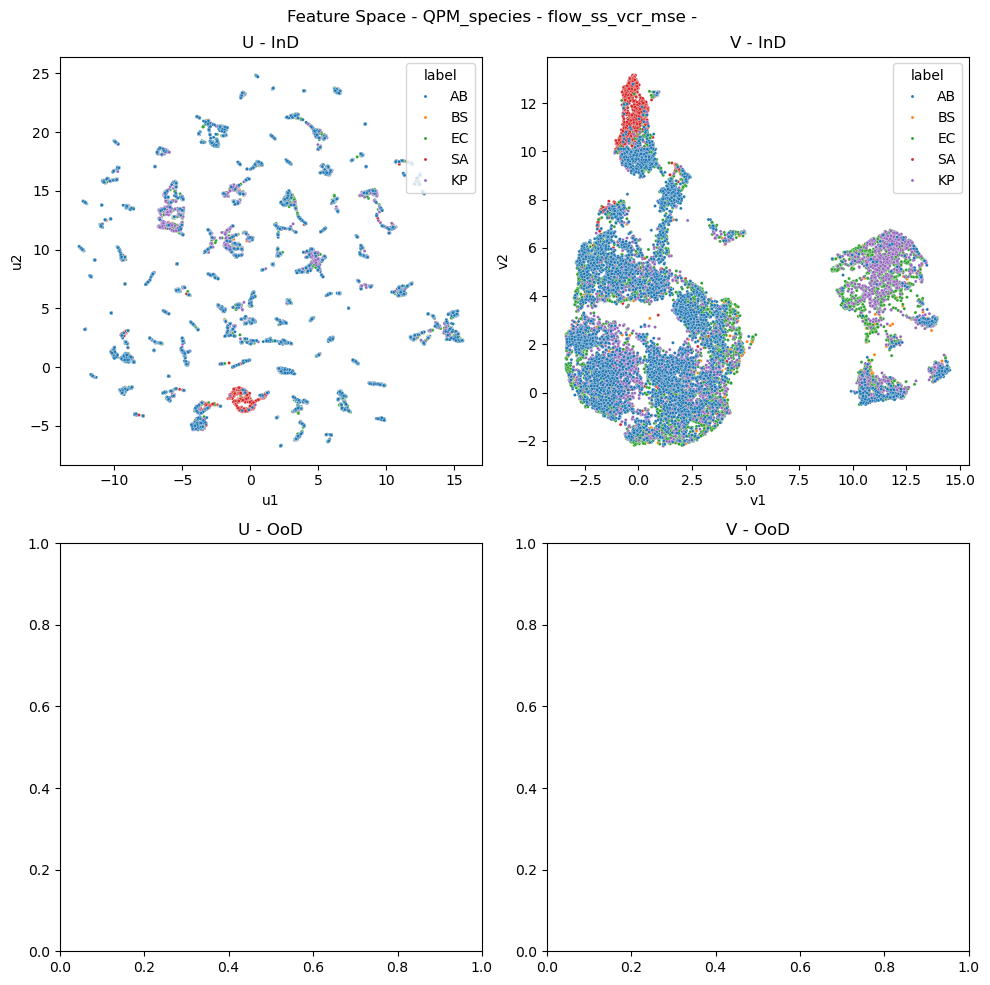

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

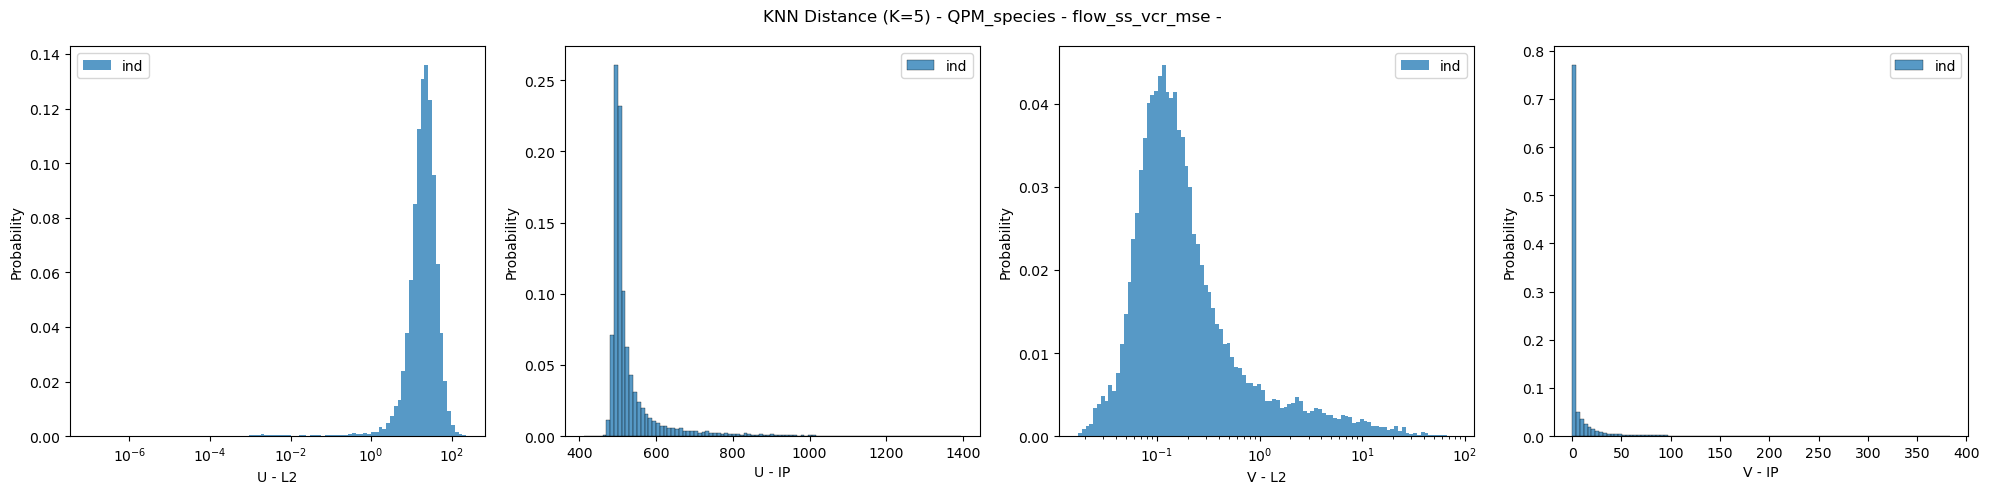

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

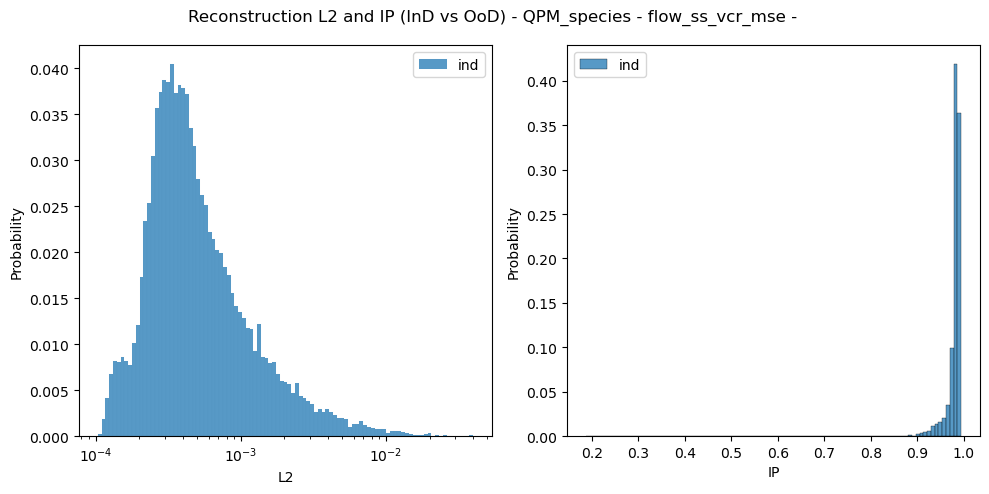

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

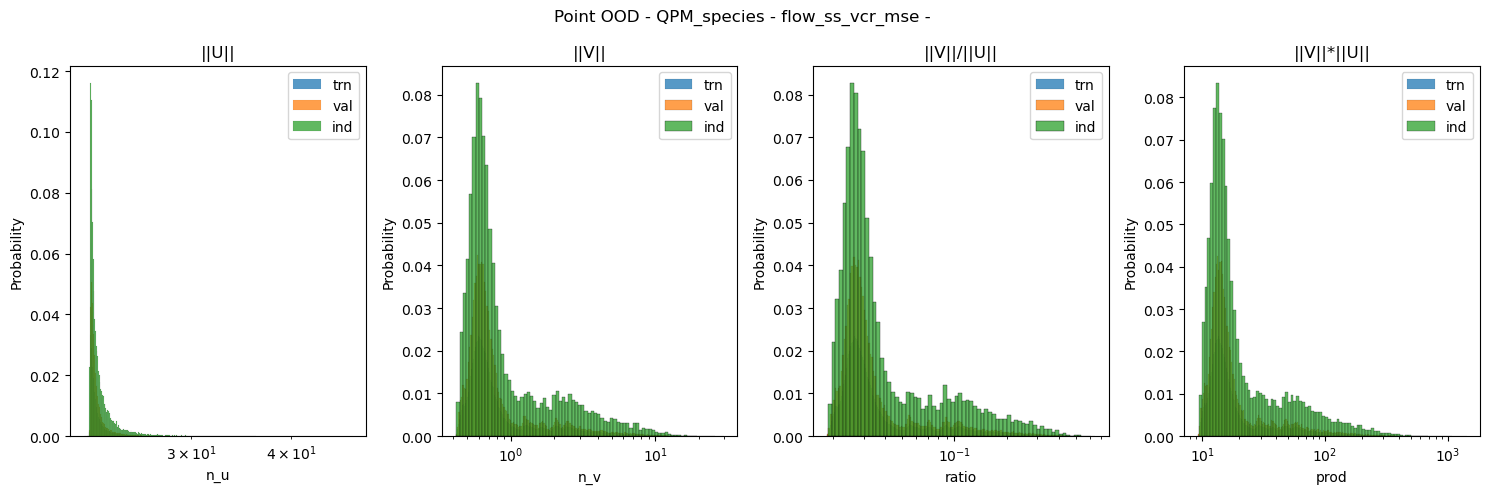

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


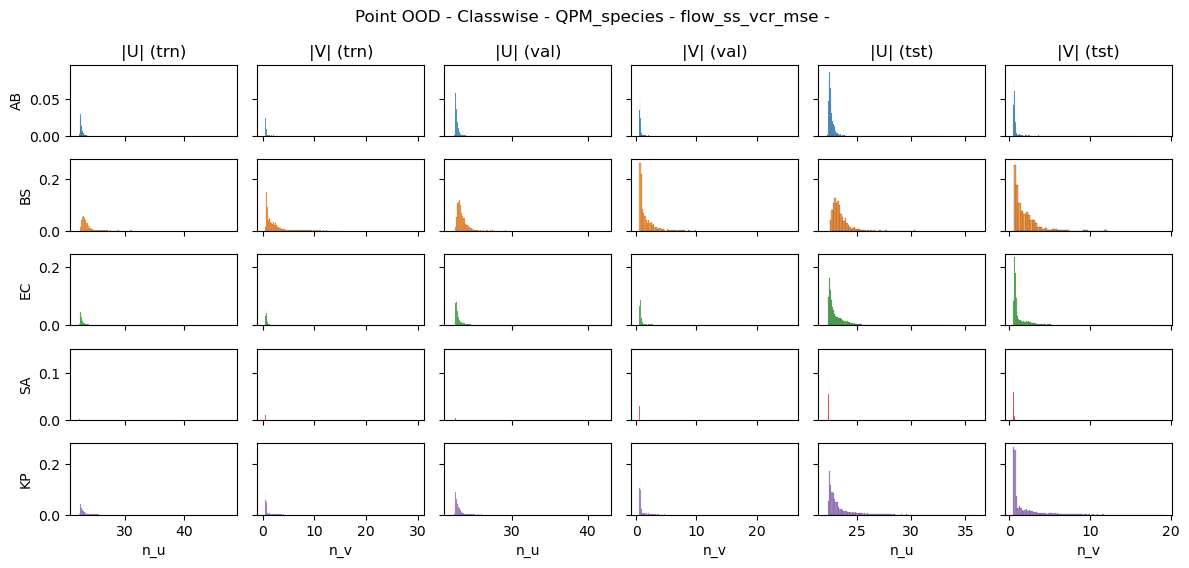

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

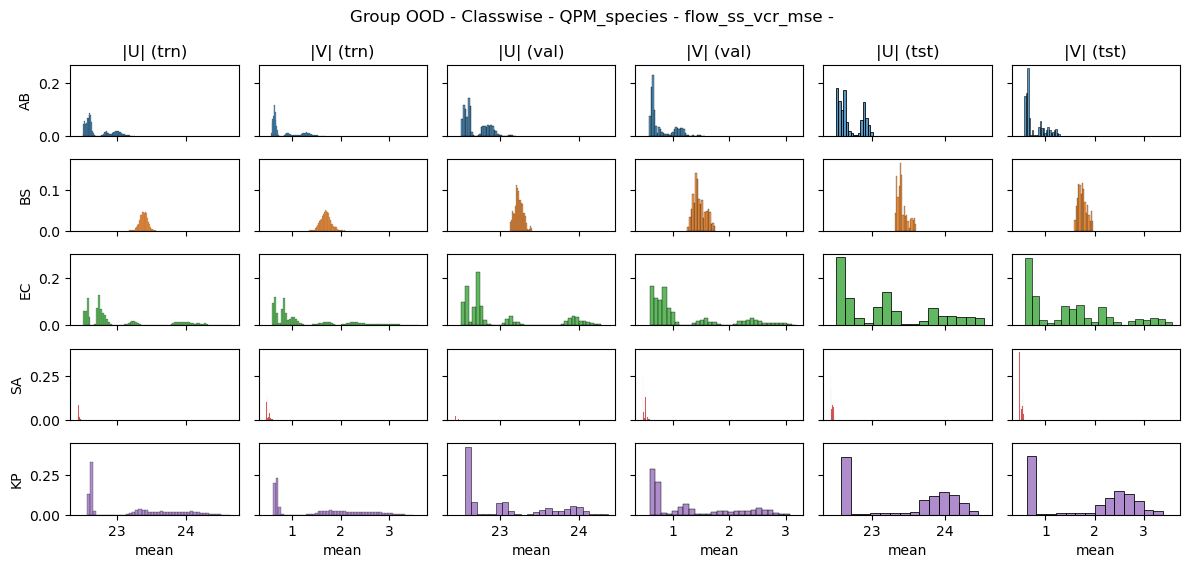

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)